# parPE steadystate example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create sbml model from scratch
!./createSteadystateExampleSBML.py > model_steadystate_scaled.sbml

In [3]:
sbml_file = 'model_steadystate_scaled.sbml'
model_name = 'model_steadystate_scaled'
model_output_dir= 'model_steadystate_scaled'

In [4]:
# Show model info
import libsbml
SBMLreader = libsbml.SBMLReader()
sbml_doc = SBMLreader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('Parameters: ', [p.getId() for p in sbml_model.getListOfParameters()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['x1', 'x2', 'x3']
Parameters:  ['p1', 'p2', 'p3', 'p4', 'p5', 'k0', 'observable_x1', 'observable_x2', 'observable_x3', 'scaling_x1', 'observable_x1_scaled', 'offset_x2', 'observable_x2_offsetted', 'observable_x1withsigma_sigma', 'observable_x1withsigma']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


## Generate model code

In [5]:
observables = []
fixed_parameters = ['k0']

def createModule(sbml_model_file, model_name, model_output_dir):
    """Create Python module from SBML model"""
    sbmlImporter = amici.SbmlImporter(sbml_model_file)
    sbml = sbmlImporter.sbml
    global observables
    observables = amici.assignmentRules2observables(sbml, filter=lambda variableId: 
                                                    variableId.startswith('observable_') and not variableId.endswith('_sigma'))
    
    print(observables)
    print(fixed_parameters)

    sbmlImporter.sbml2amici(model_name,
                            output_dir=model_output_dir,
                            observables=observables,
                            constantParameters=fixed_parameters,
                            sigmas={'observable_x1withsigma': 'observable_x1withsigma_sigma'})


createModule(sbml_file, model_name, model_output_dir)



{'observable_x1': 'x1', 'observable_x2': 'x2', 'observable_x3': 'x3', 'observable_x1_scaled': 'scaling_x1 * x1', 'observable_x2_offsetted': 'offset_x2 + x2', 'observable_x1withsigma': 'x1'}
['k0']


## Test simulation

In [6]:
def plotStateTrajectories(rdata):
    for ix in range(rdata['x'].shape[1]):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


[1.  0.5 0.4 2.  0.1 2.  3.  0.2]
{'t': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]), 'x': array([[0.1000178 , 0.4000123 , 0.6999792 ],
       [0.10003683, 0.40002545, 0.69995696],
       [0.1000762 , 0.40005266, 0.69991096],
       [0.10015767, 0.40010894, 0.69981577],
       [0.1003262 , 0.40022538, 0.69961885],
       [0.10067479, 0.40046616, 0.6992116 ],
       [0.10139555, 0.4009638 , 0.69836975],
       [0.10288464, 0.40199105, 0.69663131],
       [0.10595616, 0.4041061 , 0.69304903],
       [0.11227026, 0.40843807, 0.6856998 ],
       [0.12515789, 0.41721488, 0.6707597 ],
       [0.15106393, 0.43460508, 0.64095895],
       [0.20141095, 0.46753068, 0.58381562],
       [0.291

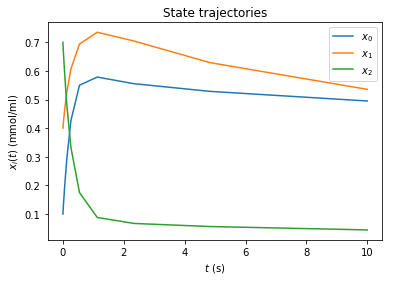

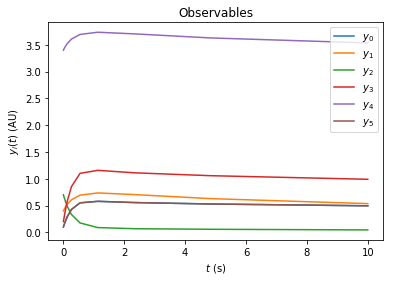

In [7]:
# load model
sys.path.insert(0, model_output_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Create in silico experimental data for parameter estimation

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [8]:
expectedLlh = 0.0
sigma_default = 0.1 # parameters are lin
sigma_parameter = 0.2
offset_batch_1 = 3.0
offset_batch_2 = 4.0
offsetted_observable_idx = 4
sigma_parameter_observable_idx = 5
model_offset_parameter_idx = 6
sigma_parameter_idx = 7
timepoints = np.logspace(-5, 1, 20)

model = modelModule.getModel()
default_parameters = np.array(model.getParameters())
default_parameters[sigma_parameter_idx] = sigma_parameter
true_parameters = default_parameters.copy()
true_parameters = np.append(true_parameters, offset_batch_2) # add second offset parameter
print('true_parameters: %s' % true_parameters)

def createData():
    # setup model & solver
    model = modelModule.getModel()
    model.setTimepoints(amici.DoubleVector(timepoints))
    model.setParameters(amici.DoubleVector(default_parameters))
    print('Default parameters: ', default_parameters)
    
    solver = model.getSolver()
    solver.setMaxSteps(10000)

    # generate conditon-vectors
    conditions = [np.array(model.getFixedParameters())]
    conditions.append(conditions[0] * 1.1)
    conditions.append(conditions[0] * 1.2)
    conditions.append(conditions[0] * 1.3)

    conditionDf = createConditionDataframe(fixed_parameters, conditions)
    
    df = pd.DataFrame(data={
        'observable': [],
        'condition': [],
        'conditionRef': [],
        'scalingParameter': [],
        'time': [],
        'measurement': [],
        'sigma': []
    })

    global expectedLlh
    for icondition, condition in enumerate(conditions):      
        print('Condition %d: %s' % (icondition, condition))
        
        # different offset for two "batches"
        batch_id = icondition % 2
        if batch_id == 0:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_1
        else:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_2
        
        sigmay = np.ones(shape=(model.nt(), model.nytrue)) * sigma_default
        sigmay[:, sigma_parameter_observable_idx] = np.nan # observable with sigma parameter
        
        # simulate condition
        rdata = getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay)
        
        print('\tllh: ', rdata['llh'])
        print('\tsllh', rdata['sllh'])

        expectedLlh += rdata['llh']
        
        conditionName = 'condition-%d' % icondition
        
        # Append data
        for iy, observableName in enumerate(observables.keys()):
            scalingParameter = [''] 
            sigma = sigmay[:, iy]
            
            if observableName == 'observable_x1_scaled':
                #scalingParameter = ['scaling_x1_%s' % conditionName]
                scalingParameter = ['scaling_x1_common']
            elif observableName == 'observable_x2_offsetted':
                #scalingParameter = ['offset_x2_%s' % conditionName]
                #scalingParameter = ['offset_x2_common']
                scalingParameter = ['offset_x2_batch-%d' % batch_id]
            elif observableName == 'observable_x1withsigma':
                #scalingParameter = ['observable_x1withsigma_sigma_%s' % conditionName]
                scalingParameter = ['observable_x1withsigma_sigma_common']
            
            df = df.append(pd.DataFrame(
            {'observable'      : [observableName] * model.nt(),
             'condition'       : [conditionName]  * model.nt(),
             'conditionRef'    : ['']  * model.nt(),
             'scalingParameter': scalingParameter * model.nt(),
             'time'            : np.array(model.getTimepoints()),
             'measurement'     : rdata['y'][:, iy],
             'sigma'           : sigma
             }), ignore_index=True)
    print('Expected llh: ', expectedLlh)
            
    return df, conditionDf


def createConditionDataframe(fixed_parameters, conditions):
    """Create dataframe with fixed-parameters for each condition to simulate"""
    conditionDf = pd.DataFrame(index = fixed_parameters)
    conditionDf['ID'] = conditionDf.index
    for icondition, condition in enumerate(conditions):
        conditionDf['condition-%d' % icondition] = condition
    
    return conditionDf


def getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay):
    model.setParameters(amici.DoubleVector(simulationParameters))
    
    # simulate without measurements
    edata = amici.ExpData(model.get())
    edata.fixedParameters = amici.DoubleVector(condition)
    edata.my = amici.DoubleVector(np.full(shape=model.nt() * model.nytrue, fill_value=np.nan))
    rdata = amici.runAmiciSimulation(model, solver, edata)        
    # fixedParametersPreequilibration = 

    # confirm gradient is 0 for real measurements and save expected llh
    measurement = rdata['y']
    #measurement = np.random.normal(loc=rdata['y'], scale=np.sqrt(sigmay))
    #print((measurement-rdata['y'])/rdata['y'])
    #measurement[:, sigma_parameter_observable_idx] = np.random.normal(
    #    loc=rdata['y'][:, sigma_parameter_observable_idx], 
    #    scale=np.sqrt(simulationParameters[sigma_parameter_idx]))

    edata.my = amici.DoubleVector(measurement.flatten())
    edata.sigmay = amici.DoubleVector(sigmay.flatten())
    solver.setSensitivityMethod(amici.AMICI_SENSI_FSA)
    solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_FIRST)
    model.requireSensitivitiesForAllParameters()
    rdata = amici.runAmiciSimulation(model, solver, edata)
    
    return rdata

df, conditionDf = createData()

true_parameters: [1.  0.5 0.4 2.  0.1 2.  3.  0.2 4. ]
Default parameters:  [1.  0.5 0.4 2.  0.1 2.  3.  0.2]
Condition 0: [1.]
	llh:  152.1746435635258
	sllh [-1.26098767e-06 -1.35444901e-06  4.19581338e-06  1.52079808e-06
  5.89765005e-06  2.40838267e-06  3.97264106e-06 -1.00000000e+02]
Condition 1: [1.1]
	llh:  152.17464356352593
	sllh [   0.    0.    0.    0.    0.    0.    0. -100.]
Condition 2: [1.2]
	llh:  152.17464356352593
	sllh [   0.    0.    0.    0.    0.    0.    0. -100.]
Condition 3: [1.3]
	llh:  152.17464356352593
	sllh [   0.    0.    0.    0.    0.    0.    0. -100.]
Expected llh:  608.6985742541036


In [9]:
df

,condition,conditionRef,measurement,observable,scalingParameter,sigma,time
0,condition-0,,0.100018,observable_x1,,0.1,0.000010
1,condition-0,,0.100037,observable_x1,,0.1,0.000021
2,condition-0,,0.100076,observable_x1,,0.1,0.000043
3,condition-0,,0.100158,observable_x1,,0.1,0.000089
4,condition-0,,0.100326,observable_x1,,0.1,0.000183
5,condition-0,,0.100675,observable_x1,,0.1,0.000379
6,condition-0,,0.101396,observable_x1,,0.1,0.000785
7,condition-0,,0.102885,observable_x1,,0.1,0.001624
8,condition-0,,0.105956,observable_x1,,0.1,0.003360
9,condition-0,,0.112270,observable_x1,,0.1,0.006952


In [10]:
conditionDf

,ID,condition-0,condition-1,condition-2,condition-3
k0,k0,1.0,1.1,1.2,1.3


In [11]:
# write data frames to file
measurement_file = 'example_data.tsv'
fixed_parameter_file = 'example_data_fixed.tsv'
hdf5File = 'example_data.h5'

df.to_csv(measurement_file, sep='\t', index=False)
conditionDf.to_csv(fixed_parameter_file, sep='\t', index=False)

# convert to HDF5
import subprocess
out = subprocess.run(['%s/generateHDF5DataFileFromText.py' % os.path.join(os.getcwd(), '..', '..', '..', 'misc'),
    hdf5File,
    sbml_file,
    model_output_dir,
    measurement_file,
    fixed_parameter_file], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(out.stdout.decode("utf-8"))
assert out.returncode==0


Measurements shape (480, 7)
Changing t = Inf to t = 1e8.
Num conditions:  4
Num timepoints:  20 [1e-05, 2.0691380811147897e-05, 4.281332398719396e-05, 8.858667904100833e-05, 0.0001832980710832436, 0.000379269019073225, 0.0007847599703514606, 0.001623776739188721, 0.003359818286283781, 0.006951927961775605, 0.014384498882876632, 0.029763514416313162, 0.061584821106602614, 0.1274274985703132, 0.26366508987303555, 0.5455594781168515, 1.1288378916846884, 2.3357214690901213, 4.832930238571752, 10.0]
Fixed parameters orginal:  (1, 4)
Fixed parameters usable:  (1, 4)
Generate parameter list...
Number of simulation parameters: 8
Number of optimization parameters: 9
Generating fixed parameters matrix...
Number of fixed parameters: 1
Generating measurement matrix...
Number of observables: 6
Handling scaling parameters...
Ensure that scaling_x1_common is selected correctly as proportionality factor for hierarchical optimization ().
Number of proportionality factors for hierarchical optimization: 

In [12]:
# write true parameters as first starting point, an perturbed additional points
# two times the same point to check for reproducibility
import h5py
with h5py.File(hdf5File, 'r+') as f:
    pscale = f['/parameters/pscale'][:]
    true_parameters_scaled = true_parameters.copy()
    for i, p in enumerate(pscale):
        if p == 2:
            true_parameters_scaled[i] = np.log10(true_parameters[i])
    
    for i in range(10):
        parameters = true_parameters_scaled
        #parameters = parameters + np.random.normal(0.0, 0.2 + i * 0.1, true_parameters.shape)
        #parameters = np.random.uniform(-3, 5, true_parameters.shape)
        
        #print(parameters)
        f['/optimizationOptions/randomStarts'][:,2*i]   = parameters
        f['/optimizationOptions/randomStarts'][:,2*i+1] = parameters


In [13]:
# enable derivate checker
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test first-order
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test_print_all yes
!../../../misc/optimizationOptions.py example_data.h5 -s numStarts 4
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            4
                hierarchicalOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

## Gradient check

In [14]:
for i in range(3):
    !PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deletemegc/ example_data.h5


[2018-08-08 14:44:59] [ERR] [-1/]     0 g:   3.6596e+11  fd_c:            0  Δ/fd_c: 3.659604e+16  f:   2.2004e+23
[2018-08-08 14:44:59] [ERR] [-1/]     1 g: -1.45579e+06  fd_c:            0  Δ/fd_c: -1.455792e+11  f:   2.2004e+23
[2018-08-08 14:44:59] [ERR] [-1/]     2 g: -8.37433e+12  fd_c:            0  Δ/fd_c: -8.374333e+17  f:   2.2004e+23
[2018-08-08 14:45:00] [ERR] [-1/]     3 g:  4.35131e+12  fd_c:            0  Δ/fd_c: 4.351309e+17  f:   2.2004e+23
[2018-08-08 14:45:00] [ERR] [-1/]     4 g:  4.42513e+11  fd_c:            0  Δ/fd_c: 4.425127e+16  f:   2.2004e+23
[2018-08-08 14:45:00] [ERR] [-1/]     5 g:     -19.2333  fd_c:            0  Δ/fd_c: -1.923330e+06  f:   2.2004e+23
[2018-08-08 14:45:00] [ERR] [-1/]     6 g:  2.28596e+13  fd_c:            0  Δ/fd_c: 2.285960e+18  f:   2.2004e+23
[2018-08-08 14:45:00] [ERR] [-1/]     7 g:      -763358  fd_c:            0  Δ/fd_c: -7.633583e+10  f:   2.2004e+23
[2018-08-08 14:45:00] [ERR] [-1/]     8 g:  3.51817e+13  fd_c:            0 

## Optimize

In [15]:
!pwd
!(cd ../../../build && exec make -j12)
!../../../build/amici/examples/steadystate/example_steadystate_multi -o deleteme/ example_data.h5


/home/dweindl/src/parPE/amici/examples/steadystate
Scanning dependencies of target model_steadystate_scaled
[  1%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_Jv.cpp.o
[  2%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JSparseB.cpp.o
-- Found Git: /usr/bin/git (found version "2.17.1") 
[  9%] Built target parpecommon
[  9%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JDiag.cpp.o
[ 10%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JvB.cpp.o
[ 11%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_dJydsigma.cpp.o
[ 12%] Building CXX objec

CMakeFiles/unittests_amici.dir/__/src/simulationResultWriterTest.cpp.o: In function `std::_Vector_base<double, std::allocator<double> >::_Vector_impl::_Vector_impl()':
/home/dweindl/src/parPE/amici/src/simulationResultWriterTest.cpp:32: warning: the use of `tmpnam' is dangerous, better use `mkstemp'
[ 95%] Built target unittests_amici
[ 96%] Linking CXX executable example_steadystate_multi_simulator
[ 97%] Linking CXX executable example_steadystate_parallel
[ 98%] Linking CXX executable example_steadystate_multi
[ 98%] Built target example_steadystate_parallel
[ 98%] Built target example_steadystate_multi_simulator
[ 98%] Built target example_steadystate_multi
[ 99%] Linking CXX executable test_steadystate
CMakeFiles/test_steadystate.dir/__/__/__/common/src/testingMisc.cpp.o: In function `parpe::captureStreamToString[abi:cxx11](std::function<void ()> const&, _IO_FILE*, int)':
/home/dweindl/src/parPE/common/src/testingMisc.cpp:72: warning: the use of `tmpnam' is dangerous, better use `m

[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.0 (0): -534.6 (0) (0.0080s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.1 (1): -521.501 (0) (0.0081s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.2 (2): -519.688 (0) (0.0080s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.3 (3): -507.993 (0) (0.0079s)
[2018-08-08 14:45:26] [INF] [-1/] iter: 2 cost: 2083.78 time_iter: 0.0787728s time_optim: 0.237695s
   2  2.0837830e+03 0.00e+00 9.15e+05   7.2 2.85e+03    -  1.00e+00 3.92e-04f  3
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.0 (0): -413.624 (0) (0.0008s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.1 (1): -402.251 (0) (0.0008s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.2 (2): -390.804 (0) (0.0009s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.3 (3): -381.586 (0) (0.0008s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.0 (0): -413.624 (0) (0.0087s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.1 (1): -402.251 (0) (0.0084s)
[2018-08-08

[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.2 (2): 73.2587 (0) (0.0096s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.3 (3): 76.8426 (0) (0.0088s)
[2018-08-08 14:45:26] [INF] [-1/] iter: 10 cost: -293.87 time_iter: 0.0794373s time_optim: 0.726781s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.9387031e+02 0.00e+00 6.30e+02   1.7 9.25e-01    -  7.71e-01 2.50e-01f  3
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.0 (0): 96.4948 (0) (0.0009s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.1 (1): 97.4832 (0) (0.0009s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.2 (2): 98.2115 (0) (0.0009s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.3 (3): 99.0476 (0) (0.0009s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.0 (0): 96.4948 (0) (0.0094s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.1 (1): 97.4832 (0) (0.0092s)
[2018-08-08 14:45:26] [DBG] [-1/] Result for 0.0.0.2 (2): 98.2115 (0) (0.0091s)
[2018-08-08 14:45

[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.0 (0): 38.9256 (0) (0.0013s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.1 (1): 42.0809 (0) (0.0018s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.2 (2): 46.6136 (0) (0.0016s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.3 (3): 48.7534 (0) (0.0014s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.0 (0): 170.303 (0) (0.0012s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.1 (1): 169.759 (0) (0.0011s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.2 (2): 171.028 (0) (0.0011s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.3 (3): 170.415 (0) (0.0011s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.0 (0): 170.303 (0) (0.0173s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.1 (1): 169.759 (0) (0.0143s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.2 (2): 171.028 (0) (0.0150s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.3 (3): 170.415 (0) (0.0135s)
[2018-08-08 14:45:27] [INF] [-1/] iter: 

[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.0 (0): 202.043 (0) (0.0137s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.1 (1): 203.278 (0) (0.0129s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.2 (2): 204.182 (0) (0.0125s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.3 (3): 205.144 (0) (0.0135s)
[2018-08-08 14:45:27] [INF] [-1/] iter: 21 cost: -814.647 time_iter: 0.104065s time_optim: 1.79482s
  21 -8.1464675e+02 0.00e+00 7.84e+02  -4.0 7.94e-01    -  1.00e+00 2.50e-01f  3
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.0 (0): 196.492 (0) (0.0011s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.1 (1): 198.742 (0) (0.0011s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.2 (2): 196.722 (0) (0.0011s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.3 (3): 198.888 (0) (0.0012s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.0 (0): 196.492 (0) (0.0011s)
[2018-08-08 14:45:27] [DBG] [-1/] Result for 0.0.0.1 (1): 198.742 (0) (0.0011s)
[2018-08-08 14:45:2

[2018-08-08 14:45:28] [DBG] [-1/] Result for 0.0.0.0 (0): 237.944 (0) (0.0221s)
[2018-08-08 14:45:28] [DBG] [-1/] Result for 0.0.0.1 (1): 237.468 (0) (0.0242s)
[2018-08-08 14:45:28] [DBG] [-1/] Result for 0.0.0.2 (2): 236.855 (0) (0.0229s)
[2018-08-08 14:45:28] [DBG] [-1/] Result for 0.0.0.3 (3): 236.025 (0) (0.0222s)
[2018-08-08 14:45:28] [INF] [-1/] iter: 27 cost: -948.293 time_iter: 0.178994s time_optim: 2.49117s
  27 -9.4829272e+02 0.00e+00 1.80e+03 -10.4 3.53e-01    -  1.00e+00 5.00e-01f  2
[2018-08-08 14:45:28] [DBG] [-1/] Result for 0.0.0.0 (0): -160622 (0) (0.0015s)
[2018-08-08 14:45:28] [DBG] [-1/] Result for 0.0.0.1 (1): -157801 (0) (0.0024s)
[2018-08-08 14:45:28] [DBG] [-1/] Result for 0.0.0.2 (2): -155849 (0) (0.0022s)
[2018-08-08 14:45:28] [DBG] [-1/] Result for 0.0.0.3 (3): -154564 (0) (0.0020s)
[2018-08-08 14:45:28] [DBG] [-1/] Result for 0.0.0.0 (0): -160622 (0) (0.0020s)
[2018-08-08 14:45:28] [DBG] [-1/] Result for 0.0.0.1 (1): -157801 (0) (0.0015s)
[2018-08-08 14:45:2

[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.0 (0): -39844.3 (0) (0.0011s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.1 (1): -35263.5 (0) (0.0015s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.2 (2): -31773.8 (0) (0.0023s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.3 (3): -29160.1 (0) (0.0016s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.0 (0): -39844.3 (0) (0.0016s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.1 (1): -35263.5 (0) (0.0015s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.2 (2): -31773.8 (0) (0.0015s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.3 (3): -29160.1 (0) (0.0019s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.0 (0): -398.775 (0) (0.0020s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.1 (1): -417.8 (0) (0.0015s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.2 (2): -464.243 (0) (0.0019s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.3 (3): -492.5 (0) (0.0017s)
[2018-08-08 14:45:29] [DBG] [-1/

[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.2 (2): -39259.8 (0) (0.0024s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.3 (3): -8513.01 (0) (0.0020s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.0 (0): -39360.2 (0) (0.0023s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.1 (1): -8556.98 (0) (0.0016s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.2 (2): -39259.8 (0) (0.0014s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.3 (3): -8513.01 (0) (0.0014s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.0 (0): -16065.4 (0) (0.0015s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.1 (1): -8566.39 (0) (0.0021s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.2 (2): -15988.8 (0) (0.0016s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.3 (3): -8489.32 (0) (0.0013s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.0 (0): -15466.6 (0) (0.0013s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.1 (1): -13329.1 (0) (0.0011s)
[2018-08-08 14:45:29] [DBG] 

[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.0 (0): -108892 (0) (0.0022s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.1 (1): -106691 (0) (0.0016s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.2 (2): -86996.4 (0) (0.0016s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.3 (3): -89209.7 (0) (0.0015s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.0 (0): -3829.52 (0) (0.0012s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.1 (1): -6233.98 (0) (0.0016s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.2 (2): -3796.98 (0) (0.0015s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.3 (3): -6208.23 (0) (0.0011s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.0 (0): -927.946 (0) (0.0010s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.1 (1): -1478.09 (0) (0.0010s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.2 (2): -923.183 (0) (0.0011s)
[2018-08-08 14:45:29] [DBG] [-1/] Result for 0.0.0.3 (3): -1474.23 (0) (0.0011s)
[2018-08-08 14:45:29] [DBG] [-

[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.0 (0): 120.445 (0) (0.0011s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.1 (1): 123.325 (0) (0.0016s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.2 (2): 125.914 (0) (0.0014s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.3 (3): 128.241 (0) (0.0011s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.0 (0): 237.525 (0) (0.0011s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.1 (1): 238.34 (0) (0.0012s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.2 (2): 237.681 (0) (0.0011s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.3 (3): 237.872 (0) (0.0014s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.0 (0): 255.836 (0) (0.0011s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.1 (1): 257.229 (0) (0.0011s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.2 (2): 254.848 (0) (0.0011s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.3 (3): 255.302 (0) (0.0011s)
[2018-08-08 14:45:30] [DBG] [-1/] Result 

[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.1 (1): 253.684 (0) (0.0012s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.2 (2): 237.719 (0) (0.0014s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.3 (3): 255.859 (0) (0.0016s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.0 (0): 250.417 (0) (0.0010s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.1 (1): 264.505 (0) (0.0013s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.2 (2): 253.804 (0) (0.0011s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.3 (3): 267.7 (0) (0.0011s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.0 (0): 252.88 (0) (0.0010s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.1 (1): 265.035 (0) (0.0010s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.2 (2): 256.378 (0) (0.0012s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.3 (3): 267.9 (0) (0.0016s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.0 (0): 252.88 (0) (0.0170s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0

[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.2 (2): 243.908 (0) (0.0009s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.3 (3): 257.512 (0) (0.0013s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.0 (0): 256.718 (0) (0.0009s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.1 (1): 269.973 (0) (0.0008s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.2 (2): 256.66 (0) (0.0008s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.3 (3): 269.662 (0) (0.0009s)
[2018-08-08 14:45:30] [DBG] [-1/] Result for 0.0.0.0 (0): 256.718 (0) (0.0102s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.1 (1): 269.973 (0) (0.0103s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.2 (2): 256.66 (0) (0.0101s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.3 (3): 269.662 (0) (0.0111s)
[2018-08-08 14:45:31] [INF] [-1/] iter: 44 cost: -1053.01 time_iter: 0.0926844s time_optim: 5.08401s
  44 -1.0530137e+03 0.00e+00 4.65e+04   1.0 7.28e+00    -  1.00e+00 1.05e-02f  5
[2018-08-08 14:45:31

[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.2 (2): 238.393 (0) (0.0012s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.3 (3): 253.317 (0) (0.0012s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.0 (0): 261.91 (0) (0.0010s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.1 (1): 271.256 (0) (0.0009s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.2 (2): 262.404 (0) (0.0009s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.3 (3): 271.56 (0) (0.0008s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.0 (0): 265.464 (0) (0.0009s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.1 (1): 272.373 (0) (0.0009s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.2 (2): 266.558 (0) (0.0008s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.3 (3): 273.3 (0) (0.0010s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.0 (0): 265.735 (0) (0.0008s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.1 (1): 271.658 (0) (0.0011s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for

[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.2 (2): 276.486 (0) (0.0119s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.3 (3): 273.865 (0) (0.0106s)
[2018-08-08 14:45:31] [INF] [-1/] iter: 49 cost: -1100.85 time_iter: 0.113304s time_optim: 5.6607s
  49 -1.1008540e+03 0.00e+00 4.30e+04   0.7 3.55e+00    -  1.00e+00 2.56e-02f  6
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.0 (0): -1.36966e+10 (0) (0.0012s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.1 (1): -1.37062e+10 (0) (0.0012s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.2 (2): -1.37154e+10 (0) (0.0012s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.3 (3): -1.37243e+10 (0) (0.0013s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.0 (0): -1.36966e+10 (0) (0.0012s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.1 (1): -1.37062e+10 (0) (0.0011s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.2 (2): -1.37154e+10 (0) (0.0014s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.3 (3): -1.3724

[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.2 (2): 212.123 (0) (0.0011s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.3 (3): 210.804 (0) (0.0013s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.0 (0): 259.684 (0) (0.0013s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.1 (1): 258.208 (0) (0.0011s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.2 (2): 255.242 (0) (0.0012s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.3 (3): 254.783 (0) (0.0012s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.0 (0): 269.982 (0) (0.0014s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.1 (1): 269.746 (0) (0.0012s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.2 (2): 268.24 (0) (0.0012s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.3 (3): 268.707 (0) (0.0011s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.0 (0): 271.508 (0) (0.0012s)
[2018-08-08 14:45:31] [DBG] [-1/] Result for 0.0.0.1 (1): 272.111 (0) (0.0012s)
[2018-08-08 14:45:31] [DBG] [-1/] Result 

[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.0 (0): -9.50275e+09 (0) (0.0012s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.1 (1): -9.49906e+09 (0) (0.0012s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.2 (2): -9.49583e+09 (0) (0.0016s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.3 (3): -9.49304e+09 (0) (0.0012s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.0 (0): -1.25779e+06 (0) (0.0010s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.1 (1): -1.26192e+06 (0) (0.0009s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.2 (2): -1.25638e+06 (0) (0.0009s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.3 (3): -1.26181e+06 (0) (0.0009s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.0 (0): -73343.6 (0) (0.0008s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.1 (1): -75247.6 (0) (0.0009s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.2 (2): -74561 (0) (0.0008s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.3 (3): -76664.9 (0) (0.0008s

[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.2 (2): 254.703 (0) (0.0101s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.3 (3): 255.769 (0) (0.0100s)
[2018-08-08 14:45:32] [INF] [-1/] iter: 57 cost: -1021 time_iter: 0.0930207s time_optim: 6.53645s
  57 -1.0210003e+03 0.00e+00 2.41e+03   1.6 2.12e+00    -  8.18e-01 6.10e-02f  5
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.0 (0): -1.20657e+09 (0) (0.0015s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.1 (1): -1.20669e+09 (0) (0.0015s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.2 (2): -1.20604e+09 (0) (0.0014s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.3 (3): -1.20489e+09 (0) (0.0014s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.0 (0): -1.20657e+09 (0) (0.0014s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.1 (1): -1.20669e+09 (0) (0.0014s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.2 (2): -1.20604e+09 (0) (0.0014s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.3 (3): -1.20489

[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.0 (0): 263.328 (0) (0.0142s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.1 (1): 264.291 (0) (0.0144s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.2 (2): 265.178 (0) (0.0162s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.3 (3): 265.583 (0) (0.0175s)
[2018-08-08 14:45:32] [INF] [-1/] iter: 60 cost: -1058.38 time_iter: 0.124298s time_optim: 6.8952s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.0583809e+03 0.00e+00 1.26e+04   1.6 1.19e+00    -  1.00e+00 2.50e-01f  3
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.0 (0): -904138 (0) (0.0012s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.1 (1): -934638 (0) (0.0010s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.2 (2): -968546 (0) (0.0011s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.3 (3): -1.00582e+06 (0) (0.0010s)
[2018-08-08 14:45:32] [DBG] [-1/] Result for 0.0.0.0 (0): -904138 (0) (0.0013s)
[2018-08-08 14

[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.0 (0): 272.527 (0) (0.0008s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.1 (1): 271.418 (0) (0.0009s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.2 (2): 271.379 (0) (0.0009s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.3 (3): 268.867 (0) (0.0009s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.0 (0): 272.527 (0) (0.0136s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.1 (1): 271.418 (0) (0.0113s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.2 (2): 271.379 (0) (0.0127s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.3 (3): 268.867 (0) (0.0130s)
[2018-08-08 14:45:33] [INF] [-1/] iter: 63 cost: -1084.19 time_iter: 0.0971336s time_optim: 7.35653s
  63 -1.0841900e+03 0.00e+00 2.63e+03   1.6 3.72e-01    -  1.00e+00 2.50e-01f  3
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.0 (0): -2.37779e+09 (0) (0.0009s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.1 (1): -2.40604e+09 (0) (0.0010s)
[2018-08

[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.2 (2): 28.9378 (0) (0.0010s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.3 (3): 137.808 (0) (0.0011s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.0 (0): 201.23 (0) (0.0011s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.1 (1): 237.695 (0) (0.0012s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.2 (2): 202.755 (0) (0.0012s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.3 (3): 238.85 (0) (0.0008s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.0 (0): 254.958 (0) (0.0008s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.1 (1): 268.533 (0) (0.0008s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.2 (2): 255.525 (0) (0.0009s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.3 (3): 269.012 (0) (0.0008s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.0 (0): 269.308 (0) (0.0009s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.1 (1): 275.035 (0) (0.0008s)
[2018-08-08 14:45:33] [DBG] [-1/] Result f

[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.3 (3): -568.785 (0) (0.0011s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.0 (0): 134.149 (0) (0.0009s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.1 (1): 132.21 (0) (0.0012s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.2 (2): 129.85 (0) (0.0012s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.3 (3): 127.099 (0) (0.0012s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.0 (0): 248.527 (0) (0.0008s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.1 (1): 247.651 (0) (0.0008s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.2 (2): 246.687 (0) (0.0008s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.3 (3): 245.606 (0) (0.0008s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.0 (0): 273.934 (0) (0.0011s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.1 (1): 273.611 (0) (0.0012s)
[2018-08-08 14:45:33] [DBG] [-1/] Result for 0.0.0.2 (2): 273.039 (0) (0.0012s)
[2018-08-08 14:45:33] [DBG] [-1/] Result 

[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.1 (1): 282.284 (0) (0.0008s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.2 (2): 282.92 (0) (0.0009s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.3 (3): 281.512 (0) (0.0009s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.0 (0): 282.676 (0) (0.0104s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.1 (1): 282.284 (0) (0.0102s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.2 (2): 282.92 (0) (0.0104s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.3 (3): 281.512 (0) (0.0110s)
[2018-08-08 14:45:34] [INF] [-1/] iter: 71 cost: -1129.39 time_iter: 0.131642s time_optim: 8.21234s
  71 -1.1293923e+03 0.00e+00 1.15e+04   2.5 1.08e+01    -  9.86e-01 5.13e-04f 11
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.0 (0): 208.214 (0) (0.0009s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.1 (1): 189.916 (0) (0.0008s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.2 (2): 151.41 (0) (0.0008s)
[2018-08-08 14:45:34] 

[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.3 (3): 224.804 (0) (0.0011s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.0 (0): 276.09 (0) (0.0012s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.1 (1): 284.286 (0) (0.0013s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.2 (2): 272.208 (0) (0.0012s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.3 (3): 281.32 (0) (0.0012s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.0 (0): 286.389 (0) (0.0013s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.1 (1): 295.918 (0) (0.0012s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.2 (2): 285.743 (0) (0.0010s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.3 (3): 295.561 (0) (0.0009s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.0 (0): 288.349 (0) (0.0009s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.1 (1): 298.319 (0) (0.0013s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.2 (2): 288.902 (0) (0.0013s)
[2018-08-08 14:45:34] [DBG] [-1/] Result f

[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.1 (1): 253.843 (0) (0.0126s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.2 (2): 253.5 (0) (0.0125s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.3 (3): 254.041 (0) (0.0164s)
[2018-08-08 14:45:34] [INF] [-1/] iter: 77 cost: -1014.76 time_iter: 0.13695s time_optim: 8.92879s
  77 -1.0147623e+03 0.00e+00 4.03e+03   1.8 3.33e+00    -  1.00e+00 1.56e-02f  7
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.0 (0): -5.00701e+11 (0) (0.0028s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.1 (1): -5.0217e+11 (0) (0.0021s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.2 (2): -5.03515e+11 (0) (0.0019s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.3 (3): -5.04751e+11 (0) (0.0031s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.0 (0): -5.00701e+11 (0) (0.0021s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.1 (1): -5.0217e+11 (0) (0.0025s)
[2018-08-08 14:45:34] [DBG] [-1/] Result for 0.0.0.2 (2): -5.03515e+11 (0)

[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.0 (0): 258.807 (0) (0.0148s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.1 (1): 255.95 (0) (0.0134s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.2 (2): 258.221 (0) (0.0145s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.3 (3): 255.307 (0) (0.0139s)
[2018-08-08 14:45:35] [INF] [-1/] iter: 80 cost: -1028.28 time_iter: 0.176268s time_optim: 9.40982s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -1.0282849e+03 0.00e+00 4.66e+03   1.8 2.12e+00    -  1.00e+00 3.91e-03f  9
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.0 (0): -8776.89 (0) (0.0015s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.1 (1): -9020.69 (0) (0.0010s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.2 (2): -9162.13 (0) (0.0013s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.3 (3): -9452 (0) (0.0011s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.0 (0): -8776.89 (0) (0.0009s)
[2018-08-08 14:45

[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.1 (1): 263.081 (0) (0.0154s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.2 (2): 263.017 (0) (0.0161s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.3 (3): 262.947 (0) (0.0138s)
[2018-08-08 14:45:35] [INF] [-1/] iter: 83 cost: -1051.05 time_iter: 0.169746s time_optim: 9.86466s
  83 -1.0510507e+03 0.00e+00 2.80e+03   1.8 4.41e+00    -  7.70e-01 7.81e-03f  8
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.0 (0): -1.36365e+06 (0) (0.0009s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.1 (1): -1.40957e+06 (0) (0.0009s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.2 (2): -1.45056e+06 (0) (0.0010s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.3 (3): -1.48681e+06 (0) (0.0013s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.0 (0): -1.36365e+06 (0) (0.0030s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.1 (1): -1.40957e+06 (0) (0.0016s)
[2018-08-08 14:45:35] [DBG] [-1/] Result for 0.0.0.2 (2): -1.45056e+0

[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.1 (1): 270.986 (0) (0.0106s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.2 (2): 269.386 (0) (0.0127s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.3 (3): 272.09 (0) (0.0097s)
[2018-08-08 14:45:36] [INF] [-1/] iter: 86 cost: -1080.47 time_iter: 0.115335s time_optim: 10.2079s
  86 -1.0804736e+03 0.00e+00 2.42e+04   1.8 1.72e+00    -  1.00e+00 7.81e-03f  8
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.0 (0): -1.24401e+08 (0) (0.0013s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.1 (1): -1.19755e+08 (0) (0.0013s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.2 (2): -1.1568e+08 (0) (0.0013s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.3 (3): -1.12026e+08 (0) (0.0013s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.0 (0): -1.24401e+08 (0) (0.0013s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.1 (1): -1.19755e+08 (0) (0.0015s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.2 (2): -1.1568e+08 (

[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.2 (2): 268.694 (0) (0.0102s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.3 (3): 274.126 (0) (0.0101s)
[2018-08-08 14:45:36] [INF] [-1/] iter: 88 cost: -1083.65 time_iter: 0.128958s time_optim: 10.4537s
  88 -1.0836456e+03 0.00e+00 1.77e+04   1.8 7.20e+00    -  9.99e-01 1.95e-03f 10
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.0 (0): -1.03664e+06 (0) (0.0009s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.1 (1): -1.07311e+06 (0) (0.0009s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.2 (2): -1.11411e+06 (0) (0.0009s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.3 (3): -1.15851e+06 (0) (0.0008s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.0 (0): -1.03664e+06 (0) (0.0008s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.1 (1): -1.07311e+06 (0) (0.0008s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.2 (2): -1.11411e+06 (0) (0.0008s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.3 (3): -1.158

[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.1 (1): 279.765 (0) (0.0100s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.2 (2): 281.725 (0) (0.0130s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.3 (3): 280.011 (0) (0.0102s)
[2018-08-08 14:45:36] [INF] [-1/] iter: 91 cost: -1122.95 time_iter: 0.115725s time_optim: 10.7679s
  91 -1.1229530e+03 0.00e+00 4.54e+03   1.8 6.30e+01    -  9.43e-02 8.85e-04f  7
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.0 (0): -294.356 (0) (0.0009s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.1 (1): -394.761 (0) (0.0008s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.2 (2): -521.068 (0) (0.0008s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.3 (3): -652.103 (0) (0.0009s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.0 (0): -294.356 (0) (0.0009s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.1 (1): -394.761 (0) (0.0008s)
[2018-08-08 14:45:36] [DBG] [-1/] Result for 0.0.0.2 (2): -521.068 (0) (0.0008s)
[2018-08-08 

[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.2 (2): 288.753 (0) (0.0116s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.3 (3): 286.929 (0) (0.0134s)
[2018-08-08 14:45:37] [INF] [-1/] iter: 94 cost: -1156.68 time_iter: 0.108826s time_optim: 11.0721s
  94 -1.1566777e+03 0.00e+00 1.66e+04   1.8 1.37e+00    -  1.00e+00 3.12e-02f  6
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.0 (0): -927952 (0) (0.0017s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.1 (1): -926916 (0) (0.0015s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.2 (2): -832941 (0) (0.0014s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.3 (3): -844426 (0) (0.0014s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.0 (0): -927952 (0) (0.0014s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.1 (1): -926916 (0) (0.0015s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.2 (2): -832941 (0) (0.0014s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.3 (3): -844426 (0) (0.0014s)
[2018-08-08 14:45:3

[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.3 (3): 286.45 (0) (0.0101s)
[2018-08-08 14:45:37] [INF] [-1/] iter: 96 cost: -1157.42 time_iter: 0.117146s time_optim: 11.3151s
  96 -1.1574211e+03 0.00e+00 1.07e+04   1.8 2.19e+00    -  1.00e+00 3.91e-03f  9
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.0 (0): 224.46 (0) (0.0009s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.1 (1): 227.466 (0) (0.0008s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.2 (2): 225.501 (0) (0.0008s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.3 (3): 228.332 (0) (0.0008s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.0 (0): 224.46 (0) (0.0008s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.1 (1): 227.466 (0) (0.0008s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.2 (2): 225.501 (0) (0.0009s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.3 (3): 228.332 (0) (0.0008s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.0 (0): 266.655 (0) (0.0008s)
[2018-08-08 14:45:37] 

[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.0 (0): 292.077 (0) (0.0093s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.1 (1): 291.812 (0) (0.0108s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.2 (2): 292.008 (0) (0.0094s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.3 (3): 291.705 (0) (0.0092s)
[2018-08-08 14:45:37] [INF] [-1/] iter: 99 cost: -1167.6 time_iter: 0.103016s time_optim: 11.5975s
  99 -1.1676020e+03 0.00e+00 1.28e+04   1.8 1.68e+01    -  2.98e-01 1.26e-03f  8
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.0 (0): -4.8653e+10 (0) (0.0010s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.1 (1): -4.9028e+10 (0) (0.0010s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.2 (2): -4.93829e+10 (0) (0.0013s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.3 (3): -4.97195e+10 (0) (0.0013s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.0 (0): -4.8653e+10 (0) (0.0013s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.1 (1): -4.9028e+10 (0) (0.0

[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.2 (2): 152.175 (0) (0.0089s)
[2018-08-08 14:45:37] [DBG] [-1/] Result for 0.0.0.3 (3): 152.175 (0) (0.0091s)
Total number of variables............................:        9
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

[2018-08-08 14:45:37] [INF] [-1/] iter: 0 cost: -608.699 time_iter: 0.0536733s time_optim: 0.0536736s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -6.0869857e+02 0.00e+00 1.00e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00   0

[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.1 (1): -290.725 (0) (0.0086s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.2 (2): -279.89 (0) (0.0099s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.3 (3): -270.043 (0) (0.0085s)
[2018-08-08 14:45:38] [INF] [-1/] iter: 6 cost: 1143.36 time_iter: 0.0592721s time_optim: 0.42488s
   6  1.1433602e+03 0.00e+00 9.01e+01   4.5 7.35e-02    -  1.00e+00 1.00e+00f  1
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.0 (0): -283.258 (0) (0.0011s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.1 (1): -271.22 (0) (0.0011s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.2 (2): -260.295 (0) (0.0011s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.3 (3): -250.373 (0) (0.0011s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.0 (0): -283.258 (0) (0.0110s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.1 (1): -271.22 (0) (0.0103s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.2 (2): -260.295 (0) (0.0082s)
[2018-08-08 1

[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.2 (2): 140.15 (0) (0.0110s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.3 (3): 137.714 (0) (0.0141s)
[2018-08-08 14:45:38] [INF] [-1/] iter: 13 cost: -554.868 time_iter: 0.0794372s time_optim: 0.928004s
  13 -5.5486800e+02 0.00e+00 1.13e+02   1.0 1.51e-01    -  1.00e+00 1.00e+00f  1
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.0 (0): 147.563 (0) (0.0012s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.1 (1): 147.491 (0) (0.0012s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.2 (2): 147.772 (0) (0.0013s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.3 (3): 147.673 (0) (0.0013s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.0 (0): 147.563 (0) (0.0134s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.1 (1): 147.491 (0) (0.0131s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.2 (2): 147.772 (0) (0.0165s)
[2018-08-08 14:45:38] [DBG] [-1/] Result for 0.0.0.3 (3): 147.673 (0) (0.0125s)
[2018-08-08 14:45:

[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.0 (0): 195.536 (0) (0.0121s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.1 (1): 196.379 (0) (0.0149s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.2 (2): 195.409 (0) (0.0110s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.3 (3): 196.21 (0) (0.0146s)
[2018-08-08 14:45:39] [INF] [-1/] iter: 19 cost: -783.535 time_iter: 0.114764s time_optim: 1.59061s
  19 -7.8353520e+02 0.00e+00 1.71e+02  -2.1 1.41e+00    -  1.00e+00 1.25e-01f  4
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.0 (0): -18335.6 (0) (0.0014s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.1 (1): -18309.1 (0) (0.0011s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.2 (2): -18273.1 (0) (0.0010s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.3 (3): -18194.8 (0) (0.0009s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.0 (0): -18335.6 (0) (0.0010s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.1 (1): -18309.1 (0) (0.0012s)
[2018-08-08 14

[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.3 (3): 204.04 (0) (0.0010s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.0 (0): 202.075 (0) (0.0011s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.1 (1): 203.314 (0) (0.0012s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.2 (2): 203.222 (0) (0.0012s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.3 (3): 204.04 (0) (0.0013s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.0 (0): 218.932 (0) (0.0009s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.1 (1): 219.2 (0) (0.0010s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.2 (2): 218.635 (0) (0.0013s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.3 (3): 218.813 (0) (0.0011s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.0 (0): 218.932 (0) (0.0103s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.1 (1): 219.2 (0) (0.0104s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0.0.0.2 (2): 218.635 (0) (0.0104s)
[2018-08-08 14:45:39] [DBG] [-1/] Result for 0

[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.1 (1): -2.87782e+06 (0) (0.0010s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.2 (2): -2.95581e+06 (0) (0.0012s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.3 (3): -3.00917e+06 (0) (0.0012s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.0 (0): -2.77028e+06 (0) (0.0013s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.1 (1): -2.87782e+06 (0) (0.0012s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.2 (2): -2.95581e+06 (0) (0.0009s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.3 (3): -3.00917e+06 (0) (0.0012s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.0 (0): -2791.07 (0) (0.0009s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.1 (1): -2929.27 (0) (0.0011s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.2 (2): -3025.17 (0) (0.0013s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.3 (3): -3094.04 (0) (0.0013s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.0 (0): 227.826 (0) (0.0009s)
[

[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.1 (1): 253.356 (0) (0.0119s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.2 (2): 247.715 (0) (0.0127s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.3 (3): 242.157 (0) (0.0098s)
[2018-08-08 14:45:40] [INF] [-1/] iter: 32 cost: -999.893 time_iter: 0.103816s time_optim: 2.85136s
  32 -9.9989268e+02 0.00e+00 7.46e+03 -10.7 1.50e+01    -  1.00e+00 7.09e-03f  5
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.0 (0): -4.0744e+06 (0) (0.0009s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.1 (1): -4.17482e+06 (0) (0.0008s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.2 (2): -4.28139e+06 (0) (0.0008s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.3 (3): -4.39299e+06 (0) (0.0012s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.0 (0): -4.0744e+06 (0) (0.0010s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.1 (1): -4.17482e+06 (0) (0.0009s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.2 (2): -4.28139e+06 

[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.0 (0): 122.429 (0) (0.0012s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.1 (1): 69.4731 (0) (0.0013s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.2 (2): 124.72 (0) (0.0010s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.3 (3): 71.4697 (0) (0.0009s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.0 (0): 216.158 (0) (0.0009s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.1 (1): 197.957 (0) (0.0010s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.2 (2): 215.699 (0) (0.0009s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.3 (3): 197.355 (0) (0.0009s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.0 (0): 247.203 (0) (0.0009s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.1 (1): 239.21 (0) (0.0009s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.2 (2): 243.712 (0) (0.0009s)
[2018-08-08 14:45:40] [DBG] [-1/] Result for 0.0.0.3 (3): 235.29 (0) (0.0009s)
[2018-08-08 14:45:40] [DBG] [-1/] Result fo

[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.0 (0): 245.334 (0) (0.0011s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.1 (1): 252.844 (0) (0.0012s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.2 (2): 248.802 (0) (0.0011s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.3 (3): 254.873 (0) (0.0009s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.0 (0): 256.014 (0) (0.0009s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.1 (1): 258.967 (0) (0.0009s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.2 (2): 254.761 (0) (0.0009s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.3 (3): 256.376 (0) (0.0008s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.0 (0): 256.014 (0) (0.0112s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.1 (1): 258.967 (0) (0.0113s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.2 (2): 254.761 (0) (0.0111s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.3 (3): 256.376 (0) (0.0124s)
[2018-08-08 14:45:41] [INF] [-1/] iter: 

[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.1 (1): 264.04 (0) (0.0143s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.2 (2): 257.243 (0) (0.0133s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.3 (3): 266.476 (0) (0.0177s)
[2018-08-08 14:45:41] [INF] [-1/] iter: 40 cost: -1041.52 time_iter: 0.144542s time_optim: 3.85333s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -1.0415188e+03 0.00e+00 3.24e+04  -1.9 2.39e+03    -  1.00e+00 3.85e-05f  5
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.0 (0): -2.26908e+06 (0) (0.0012s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.1 (1): -2.41219e+06 (0) (0.0013s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.2 (2): -2.58473e+06 (0) (0.0012s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.3 (3): -2.78055e+06 (0) (0.0011s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.0 (0): -2.26908e+06 (0) (0.0012s)
[2018-08-08 14:45:41] [DBG] [-1/] Result for 0.0.0.1 (1): -2.41219e+06 (0)

[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.1 (1): 265.031 (0) (0.0144s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.2 (2): 254.46 (0) (0.0135s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.3 (3): 264.078 (0) (0.0109s)
[2018-08-08 14:45:42] [INF] [-1/] iter: 43 cost: -1038.81 time_iter: 0.116774s time_optim: 4.36636s
  43 -1.0388118e+03 0.00e+00 5.66e+04   1.0 1.95e+00    -  1.00e+00 8.92e-02f  4
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.0 (0): -1.41739e+07 (0) (0.0011s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.1 (1): -1.4897e+07 (0) (0.0012s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.2 (2): -1.57363e+07 (0) (0.0011s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.3 (3): -1.66616e+07 (0) (0.0012s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.0 (0): -1.41739e+07 (0) (0.0010s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.1 (1): -1.4897e+07 (0) (0.0008s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.2 (2): -1.57363e+07 (

[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.0 (0): 265.212 (0) (0.0008s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.1 (1): 270.282 (0) (0.0009s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.2 (2): 267.37 (0) (0.0009s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.3 (3): 272.039 (0) (0.0011s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.0 (0): 265.212 (0) (0.0121s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.1 (1): 270.282 (0) (0.0102s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.2 (2): 267.37 (0) (0.0098s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.3 (3): 272.039 (0) (0.0103s)
[2018-08-08 14:45:42] [INF] [-1/] iter: 46 cost: -1074.9 time_iter: 0.103344s time_optim: 4.6869s
  46 -1.0749026e+03 0.00e+00 4.16e+04   1.4 1.58e+00    -  1.00e+00 3.12e-02f  6
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.0 (0): -482961 (0) (0.0009s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.1 (1): -490062 (0) (0.0008s)
[2018-08-08 14:45:42] [

[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.2 (2): 267.257 (0) (0.0105s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.3 (3): 272.759 (0) (0.0105s)
[2018-08-08 14:45:42] [INF] [-1/] iter: 48 cost: -1077.86 time_iter: 0.119824s time_optim: 4.90973s
  48 -1.0778568e+03 0.00e+00 4.00e+04   1.4 2.30e+00    -  1.00e+00 1.95e-03f 10
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.0 (0): -4.54767e+06 (0) (0.0008s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.1 (1): -4.8318e+06 (0) (0.0009s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.2 (2): -5.18034e+06 (0) (0.0008s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.3 (3): -5.55328e+06 (0) (0.0008s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.0 (0): -4.54767e+06 (0) (0.0008s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.1 (1): -4.8318e+06 (0) (0.0008s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.2 (2): -5.18034e+06 (0) (0.0009s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.3 (3): -5.55328

[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.0 (0): 270.047 (0) (0.0146s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.1 (1): 271.638 (0) (0.0129s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.2 (2): 271.991 (0) (0.0120s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.3 (3): 273.659 (0) (0.0131s)
[2018-08-08 14:45:42] [INF] [-1/] iter: 51 cost: -1087.33 time_iter: 0.131031s time_optim: 5.3065s
  51 -1.0873345e+03 0.00e+00 2.16e+04   2.4 5.17e+00    -  1.00e+00 3.12e-02f  6
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.0 (0): -481.498 (0) (0.0010s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.1 (1): -424.872 (0) (0.0009s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.2 (2): -441.731 (0) (0.0011s)
[2018-08-08 14:45:42] [DBG] [-1/] Result for 0.0.0.3 (3): -386.718 (0) (0.0014s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.0 (0): -481.498 (0) (0.0012s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.1 (1): -424.872 (0) (0.0014s)
[2018-08-08 14

[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.2 (2): -68452.2 (0) (0.0012s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.3 (3): -57204.7 (0) (0.0012s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.0 (0): -7635.08 (0) (0.0013s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.1 (1): -5057.12 (0) (0.0014s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.2 (2): -7312.83 (0) (0.0013s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.3 (3): -4763.86 (0) (0.0020s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.0 (0): -732.376 (0) (0.0013s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.1 (1): -172.381 (0) (0.0014s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.2 (2): -695.407 (0) (0.0012s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.3 (3): -141.223 (0) (0.0013s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.0 (0): 111.822 (0) (0.0012s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.1 (1): 217.974 (0) (0.0012s)
[2018-08-08 14:45:43] [DBG] [-

[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.2 (2): 250.558 (0) (0.0147s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.3 (3): 249.561 (0) (0.0130s)
[2018-08-08 14:45:43] [INF] [-1/] iter: 56 cost: -999.83 time_iter: 0.104591s time_optim: 6.02784s
  56 -9.9982962e+02 0.00e+00 1.17e+03   2.3 1.56e+00    -  1.00e+00 2.50e-01f  3
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.0 (0): -6.88631e+07 (0) (0.0016s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.1 (1): -6.7299e+07 (0) (0.0014s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.2 (2): -6.57969e+07 (0) (0.0013s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.3 (3): -6.43613e+07 (0) (0.0014s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.0 (0): -6.88631e+07 (0) (0.0012s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.1 (1): -6.7299e+07 (0) (0.0012s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.2 (2): -6.57969e+07 (0) (0.0009s)
[2018-08-08 14:45:43] [DBG] [-1/] Result for 0.0.0.3 (3): -6.43613e

[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.1 (1): 181.932 (0) (0.0010s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.2 (2): 189.549 (0) (0.0014s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.3 (3): 185.644 (0) (0.0018s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.0 (0): 246.188 (0) (0.0012s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.1 (1): 243.712 (0) (0.0009s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.2 (2): 246.118 (0) (0.0009s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.3 (3): 243.441 (0) (0.0012s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.0 (0): 258.282 (0) (0.0014s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.1 (1): 256.626 (0) (0.0012s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.2 (2): 257.77 (0) (0.0014s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.3 (3): 256.059 (0) (0.0017s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.0 (0): 258.282 (0) (0.0151s)
[2018-08-08 14:45:44] [DBG] [-1/] Result 

[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.3 (3): 53.9229 (0) (0.0012s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.0 (0): 233.666 (0) (0.0012s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.1 (1): 227.471 (0) (0.0013s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.2 (2): 227.997 (0) (0.0013s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.3 (3): 221.138 (0) (0.0009s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.0 (0): 262.008 (0) (0.0010s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.1 (1): 259.221 (0) (0.0013s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.2 (2): 259.464 (0) (0.0012s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.3 (3): 256.553 (0) (0.0013s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.0 (0): 267.912 (0) (0.0009s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.1 (1): 266.227 (0) (0.0009s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.2 (2): 266.194 (0) (0.0013s)
[2018-08-08 14:45:44] [DBG] [-1/] Result

[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.0 (0): 272.945 (0) (0.0144s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.1 (1): 273.287 (0) (0.0129s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.2 (2): 273.338 (0) (0.0120s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.3 (3): 273.614 (0) (0.0140s)
[2018-08-08 14:45:44] [INF] [-1/] iter: 65 cost: -1093.18 time_iter: 0.109719s time_optim: 7.30892s
  65 -1.0931838e+03 0.00e+00 6.72e+03   1.6 7.17e-01    -  7.84e-01 2.50e-01f  3
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.0 (0): -29904.4 (0) (0.0009s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.1 (1): -10847.3 (0) (0.0009s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.2 (2): -29814 (0) (0.0009s)
[2018-08-08 14:45:44] [DBG] [-1/] Result for 0.0.0.3 (3): -10828.4 (0) (0.0009s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.0 (0): -29904.4 (0) (0.0014s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.1 (1): -10847.3 (0) (0.0013s)
[2018-08-08 14:

[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.3 (3): -1.05783e+06 (0) (0.0011s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.0 (0): -6955.42 (0) (0.0010s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.1 (1): -6950.36 (0) (0.0011s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.2 (2): -7056.1 (0) (0.0012s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.3 (3): -7253.15 (0) (0.0012s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.0 (0): 81.2149 (0) (0.0010s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.1 (1): 86.1351 (0) (0.0009s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.2 (2): 88.1036 (0) (0.0010s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.3 (3): 82.5551 (0) (0.0009s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.0 (0): 270.802 (0) (0.0008s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.1 (1): 270.778 (0) (0.0008s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.2 (2): 271.272 (0) (0.0009s)
[2018-08-08 14:45:45] [DBG] [-1/

[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.2 (2): 282.446 (0) (0.0123s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.3 (3): 280.696 (0) (0.0115s)
[2018-08-08 14:45:45] [INF] [-1/] iter: 70 cost: -1129 time_iter: 0.103505s time_optim: 7.94032s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.1289951e+03 0.00e+00 6.79e+03  -0.2 9.91e-01    -  1.00e+00 1.25e-01f  4
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.0 (0): -3.13381e+08 (0) (0.0020s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.1 (1): -3.07618e+08 (0) (0.0016s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.2 (2): -3.02404e+08 (0) (0.0015s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.3 (3): -2.97732e+08 (0) (0.0018s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.0 (0): -3.13381e+08 (0) (0.0018s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.1 (1): -3.07618e+08 (0) (0.0016s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.2 (2): -3.02404e+08 

[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.3 (3): 246.756 (0) (0.0008s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.0 (0): 268.739 (0) (0.0009s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.1 (1): 288.502 (0) (0.0010s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.2 (2): 269.456 (0) (0.0010s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.3 (3): 289.022 (0) (0.0010s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.0 (0): 288.088 (0) (0.0009s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.1 (1): 298.343 (0) (0.0009s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.2 (2): 289.551 (0) (0.0009s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.3 (3): 299.636 (0) (0.0009s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.0 (0): 288.088 (0) (0.0143s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.1 (1): 298.343 (0) (0.0111s)
[2018-08-08 14:45:45] [DBG] [-1/] Result for 0.0.0.2 (2): 289.551 (0) (0.0112s)
[2018-08-08 14:45:45] [DBG] [-1/] Result

[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.1 (1): -175111 (0) (0.0016s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.2 (2): -165802 (0) (0.0013s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.3 (3): -170757 (0) (0.0012s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.0 (0): -5464.73 (0) (0.0009s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.1 (1): -7002.65 (0) (0.0010s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.2 (2): -5428.28 (0) (0.0009s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.3 (3): -6957.12 (0) (0.0009s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.0 (0): -235.183 (0) (0.0009s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.1 (1): -533.576 (0) (0.0012s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.2 (2): -238.13 (0) (0.0012s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.3 (3): -534.54 (0) (0.0012s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.0 (0): 206.478 (0) (0.0010s)
[2018-08-08 14:45:46] [DBG] [-1/] 

[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.2 (2): 257.425 (0) (0.0111s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.3 (3): 250.815 (0) (0.0107s)
[2018-08-08 14:45:46] [INF] [-1/] iter: 78 cost: -1017.56 time_iter: 0.111106s time_optim: 8.97457s
  78 -1.0175636e+03 0.00e+00 2.14e+03   1.8 6.83e+00    -  5.53e-01 1.11e-02f  6
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.0 (0): -5.45952e+07 (0) (0.0008s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.1 (1): -5.66195e+07 (0) (0.0008s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.2 (2): -5.86986e+07 (0) (0.0008s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.3 (3): -6.08039e+07 (0) (0.0008s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.0 (0): -5.45952e+07 (0) (0.0008s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.1 (1): -5.66195e+07 (0) (0.0009s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.2 (2): -5.86986e+07 (0) (0.0009s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.3 (3): -6.080

[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.0 (0): 259.036 (0) (0.0107s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.1 (1): 257.816 (0) (0.0099s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.2 (2): 258.323 (0) (0.0099s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.3 (3): 257.174 (0) (0.0099s)
[2018-08-08 14:45:46] [INF] [-1/] iter: 81 cost: -1032.35 time_iter: 0.0941497s time_optim: 9.29944s
  81 -1.0323491e+03 0.00e+00 6.97e+03   1.8 7.16e-01    -  1.00e+00 6.25e-02f  5
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.0 (0): -3.16621e+06 (0) (0.0009s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.1 (1): -2.89006e+06 (0) (0.0009s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.2 (2): -2.6357e+06 (0) (0.0009s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.3 (3): -2.40395e+06 (0) (0.0010s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.0 (0): -3.16621e+06 (0) (0.0009s)
[2018-08-08 14:45:46] [DBG] [-1/] Result for 0.0.0.1 (1): -2.89006e+06 (0)

[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.1 (1): 267.935 (0) (0.0103s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.2 (2): 269.582 (0) (0.0103s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.3 (3): 270.301 (0) (0.0103s)
[2018-08-08 14:45:47] [INF] [-1/] iter: 84 cost: -1074.27 time_iter: 0.0924647s time_optim: 9.60142s
  84 -1.0742715e+03 0.00e+00 2.86e+04   1.8 8.03e+00    -  7.95e-01 2.41e-02f  4
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.0 (0): -1.42293e+06 (0) (0.0010s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.1 (1): -1.44488e+06 (0) (0.0014s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.2 (2): -1.47069e+06 (0) (0.0013s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.3 (3): -1.49425e+06 (0) (0.0013s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.0 (0): -1.42293e+06 (0) (0.0009s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.1 (1): -1.44488e+06 (0) (0.0009s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.2 (2): -1.47069e+

[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.3 (3): -924.659 (0) (0.0011s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.0 (0): 144.834 (0) (0.0012s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.1 (1): 156.61 (0) (0.0013s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.2 (2): 128.718 (0) (0.0010s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.3 (3): 147.75 (0) (0.0009s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.0 (0): 249.098 (0) (0.0009s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.1 (1): 258.149 (0) (0.0009s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.2 (2): 247.562 (0) (0.0010s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.3 (3): 257.415 (0) (0.0010s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.0 (0): 265.325 (0) (0.0010s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.1 (1): 271.242 (0) (0.0011s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.2 (2): 265.893 (0) (0.0010s)
[2018-08-08 14:45:47] [DBG] [-1/] Result 

[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.2 (2): 270.522 (0) (0.0112s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.3 (3): 274.656 (0) (0.0100s)
[2018-08-08 14:45:47] [INF] [-1/] iter: 89 cost: -1090.64 time_iter: 0.106651s time_optim: 10.193s
  89 -1.0906426e+03 0.00e+00 2.17e+04   1.8 1.08e+00    -  1.00e+00 1.56e-02f  7
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.0 (0): -1777.84 (0) (0.0009s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.1 (1): -2526.38 (0) (0.0008s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.2 (2): -1766.3 (0) (0.0008s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.3 (3): -2516.85 (0) (0.0008s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.0 (0): -1777.84 (0) (0.0009s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.1 (1): -2526.38 (0) (0.0009s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.2 (2): -1766.3 (0) (0.0008s)
[2018-08-08 14:45:47] [DBG] [-1/] Result for 0.0.0.3 (3): -2516.85 (0) (0.0008s)
[2018-08-08 14

[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.0 (0): 279.114 (0) (0.0012s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.1 (1): 276.234 (0) (0.0011s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.2 (2): 274.65 (0) (0.0009s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.3 (3): 272.51 (0) (0.0009s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.0 (0): 288.088 (0) (0.0008s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.1 (1): 287.254 (0) (0.0008s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.2 (2): 286.026 (0) (0.0009s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.3 (3): 285.155 (0) (0.0009s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.0 (0): 288.322 (0) (0.0008s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.1 (1): 287.684 (0) (0.0008s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.2 (2): 287.122 (0) (0.0009s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.3 (3): 286.299 (0) (0.0009s)
[2018-08-08 14:45:48] [DBG] [-1/] Result f

[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.0 (0): 291.337 (0) (0.0120s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.1 (1): 290.837 (0) (0.0120s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.2 (2): 288.209 (0) (0.0107s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.3 (3): 286.487 (0) (0.0104s)
[2018-08-08 14:45:48] [INF] [-1/] iter: 95 cost: -1156.87 time_iter: 0.130309s time_optim: 10.8384s
  95 -1.1568698e+03 0.00e+00 1.14e+04   1.8 1.53e+01    -  4.42e-01 1.99e-03f  9
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.0 (0): -157706 (0) (0.0011s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.1 (1): -162309 (0) (0.0011s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.2 (2): -159750 (0) (0.0012s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.3 (3): -163765 (0) (0.0012s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.0 (0): -157706 (0) (0.0011s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.1 (1): -162309 (0) (0.0011s)
[2018-08-08 14:45:4

[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.0 (0): 291.31 (0) (0.0111s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.1 (1): 290.709 (0) (0.0107s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.2 (2): 290.269 (0) (0.0101s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.3 (3): 289.41 (0) (0.0111s)
[2018-08-08 14:45:48] [INF] [-1/] iter: 98 cost: -1161.7 time_iter: 0.100663s time_optim: 11.1478s
  98 -1.1616981e+03 0.00e+00 9.75e+02   1.8 3.91e+00    -  1.00e+00 9.99e-03f  6
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.0 (0): -1.69788e+08 (0) (0.0009s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.1 (1): -1.68126e+08 (0) (0.0009s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.2 (2): -1.66662e+08 (0) (0.0011s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.3 (3): -1.65362e+08 (0) (0.0009s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.0 (0): -1.69788e+08 (0) (0.0008s)
[2018-08-08 14:45:48] [DBG] [-1/] Result for 0.0.0.1 (1): -1.68126e+08 (0) (0

[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.1 (1): 291.783 (0) (0.0127s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.2 (2): 292.359 (0) (0.0111s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.3 (3): 291.753 (0) (0.0102s)
[2018-08-08 14:45:49] [INF] [-1/] iter: 100 cost: -1168.21 time_iter: 0.133281s time_optim: 11.3909s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.1682097e+03 0.00e+00 1.15e+04   1.8 9.96e+00    -  1.00e+00 7.63e-04f 11

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:  -6.3418380648859068e+02   -1.1682097432310761e+03
Dual infeasibility......:   1.1530051402638212e+04    2.1239139584935805e+04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.4140412975115933e+02    4.4468284044177460e+02
Overall NLP error.......:   1.1530051402638212e+04    2.1239139584935805e+04


Number 

[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.2 (2): -519.688 (0) (0.0092s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.3 (3): -507.993 (0) (0.0083s)
[2018-08-08 14:45:49] [INF] [-1/] iter: 2 cost: 2083.78 time_iter: 0.082923s time_optim: 0.230949s
   2  2.0837830e+03 0.00e+00 9.15e+05   7.2 2.85e+03    -  1.00e+00 3.92e-04f  3
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.0 (0): -413.624 (0) (0.0008s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.1 (1): -402.251 (0) (0.0008s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.2 (2): -390.804 (0) (0.0008s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.3 (3): -381.586 (0) (0.0009s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.0 (0): -413.624 (0) (0.0085s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.1 (1): -402.251 (0) (0.0094s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.2 (2): -390.804 (0) (0.0081s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.3 (3): -381.586 (0) (0.0088s)
[2018-08-0

[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.2 (2): 73.2587 (0) (0.0094s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.3 (3): 76.8426 (0) (0.0091s)
[2018-08-08 14:45:49] [INF] [-1/] iter: 10 cost: -293.87 time_iter: 0.0795176s time_optim: 0.732751s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.9387031e+02 0.00e+00 6.30e+02   1.7 9.25e-01    -  7.71e-01 2.50e-01f  3
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.0 (0): 96.4948 (0) (0.0009s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.1 (1): 97.4832 (0) (0.0008s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.2 (2): 98.2115 (0) (0.0009s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.3 (3): 99.0476 (0) (0.0011s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.0 (0): 96.4948 (0) (0.0092s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.1 (1): 97.4832 (0) (0.0097s)
[2018-08-08 14:45:49] [DBG] [-1/] Result for 0.0.0.2 (2): 98.2115 (0) (0.0117s)
[2018-08-08 14:45

[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.1 (1): 169.759 (0) (0.0119s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.2 (2): 171.028 (0) (0.0118s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.3 (3): 170.415 (0) (0.0109s)
[2018-08-08 14:45:50] [INF] [-1/] iter: 17 cost: -681.506 time_iter: 0.0901343s time_optim: 1.26378s
  17 -6.8150589e+02 0.00e+00 3.41e+02  -0.9 6.73e-01    -  1.00e+00 5.00e-01f  2
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.0 (0): 157.915 (0) (0.0009s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.1 (1): 157.976 (0) (0.0009s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.2 (2): 159.025 (0) (0.0009s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.3 (3): 158.892 (0) (0.0009s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.0 (0): 157.915 (0) (0.0009s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.1 (1): 157.976 (0) (0.0012s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.2 (2): 159.025 (0) (0.0009s)
[2018-08-08 14:45:

[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.2 (2): 204.182 (0) (0.0106s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.3 (3): 205.144 (0) (0.0101s)
[2018-08-08 14:45:50] [INF] [-1/] iter: 21 cost: -814.647 time_iter: 0.085581s time_optim: 1.60792s
  21 -8.1464675e+02 0.00e+00 7.84e+02  -4.0 7.94e-01    -  1.00e+00 2.50e-01f  3
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.0 (0): 196.492 (0) (0.0009s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.1 (1): 198.742 (0) (0.0009s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.2 (2): 196.722 (0) (0.0009s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.3 (3): 198.888 (0) (0.0009s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.0 (0): 196.492 (0) (0.0008s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.1 (1): 198.742 (0) (0.0009s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.2 (2): 196.722 (0) (0.0009s)
[2018-08-08 14:45:50] [DBG] [-1/] Result for 0.0.0.3 (3): 198.888 (0) (0.0009s)
[2018-08-08 14:45:5

[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.2 (2): 236.855 (0) (0.0101s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.3 (3): 236.025 (0) (0.0103s)
[2018-08-08 14:45:51] [INF] [-1/] iter: 27 cost: -948.293 time_iter: 0.0790378s time_optim: 2.06978s
  27 -9.4829272e+02 0.00e+00 1.80e+03 -10.4 3.53e-01    -  1.00e+00 5.00e-01f  2
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.0 (0): -160622 (0) (0.0009s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.1 (1): -157801 (0) (0.0009s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.2 (2): -155849 (0) (0.0009s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.3 (3): -154564 (0) (0.0008s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.0 (0): -160622 (0) (0.0008s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.1 (1): -157801 (0) (0.0009s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.2 (2): -155849 (0) (0.0009s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.3 (3): -154564 (0) (0.0008s)
[2018-08-08 14:45:

[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.0 (0): 255.413 (0) (0.0121s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.1 (1): 250.94 (0) (0.0104s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.2 (2): 245.213 (0) (0.0098s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.3 (3): 238.64 (0) (0.0105s)
[2018-08-08 14:45:51] [INF] [-1/] iter: 31 cost: -990.207 time_iter: 0.0958978s time_optim: 2.45611s
  31 -9.9020691e+02 0.00e+00 6.96e+03 -11.0 1.73e+00    -  1.00e+00 6.25e-02f  5
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.0 (0): -3.7392e+06 (0) (0.0009s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.1 (1): -3.75908e+06 (0) (0.0010s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.2 (2): -3.78982e+06 (0) (0.0009s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.3 (3): -3.82865e+06 (0) (0.0010s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.0 (0): -3.7392e+06 (0) (0.0009s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.1 (1): -3.75908e+06 (0) (0

[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.2 (2): 196.601 (0) (0.0011s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.3 (3): 193.411 (0) (0.0011s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.0 (0): 241.473 (0) (0.0012s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.1 (1): 241.427 (0) (0.0012s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.2 (2): 240.538 (0) (0.0012s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.3 (3): 235.033 (0) (0.0011s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.0 (0): 253.786 (0) (0.0011s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.1 (1): 252.669 (0) (0.0013s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.2 (2): 250.181 (0) (0.0008s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.3 (3): 245.61 (0) (0.0008s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.0 (0): 256.538 (0) (0.0008s)
[2018-08-08 14:45:51] [DBG] [-1/] Result for 0.0.0.1 (1): 255.422 (0) (0.0008s)
[2018-08-08 14:45:51] [DBG] [-1/] Result 

[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.3 (3): 251.009 (0) (0.0009s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.0 (0): 257.154 (0) (0.0012s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.1 (1): 256.497 (0) (0.0009s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.2 (2): 252.612 (0) (0.0008s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.3 (3): 250.636 (0) (0.0008s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.0 (0): 257.154 (0) (0.0110s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.1 (1): 256.497 (0) (0.0115s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.2 (2): 252.612 (0) (0.0102s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.3 (3): 250.636 (0) (0.0104s)
[2018-08-08 14:45:52] [INF] [-1/] iter: 36 cost: -1016.9 time_iter: 0.121357s time_optim: 3.02782s
  36 -1.0168998e+03 0.00e+00 8.10e+03  -6.0 1.32e+01    -  1.00e+00 1.87e-03f  9
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.0 (0): -1.87329e+07 (0) (0.0011s)
[2018-08-08 14:

[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.0 (0): 253.956 (0) (0.0105s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.1 (1): 262.06 (0) (0.0124s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.2 (2): 256.488 (0) (0.0104s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.3 (3): 263.918 (0) (0.0108s)
[2018-08-08 14:45:52] [INF] [-1/] iter: 39 cost: -1036.42 time_iter: 0.0947673s time_optim: 3.38294s
  39 -1.0364226e+03 0.00e+00 2.71e+04  -1.8 9.81e+03    -  6.77e-04 2.14e-05f  4
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.0 (0): -139734 (0) (0.0009s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.1 (1): -160316 (0) (0.0009s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.2 (2): -179674 (0) (0.0008s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.3 (3): -198250 (0) (0.0009s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.0 (0): -139734 (0) (0.0010s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.1 (1): -160316 (0) (0.0011s)
[2018-08-08 14:45:5

[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.3 (3): 217.024 (0) (0.0009s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.0 (0): 246.225 (0) (0.0010s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.1 (1): 255.254 (0) (0.0010s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.2 (2): 244.918 (0) (0.0008s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.3 (3): 254.193 (0) (0.0009s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.0 (0): 253.249 (0) (0.0010s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.1 (1): 264.306 (0) (0.0011s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.2 (2): 253.898 (0) (0.0012s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.3 (3): 264.82 (0) (0.0012s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.0 (0): 253.249 (0) (0.0139s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.1 (1): 264.306 (0) (0.0105s)
[2018-08-08 14:45:52] [DBG] [-1/] Result for 0.0.0.2 (2): 253.898 (0) (0.0117s)
[2018-08-08 14:45:52] [DBG] [-1/] Result 

[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.1 (1): 272.087 (0) (0.0130s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.2 (2): 257.471 (0) (0.0146s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.3 (3): 270.391 (0) (0.0142s)
[2018-08-08 14:45:53] [INF] [-1/] iter: 45 cost: -1058.92 time_iter: 0.158726s time_optim: 4.1161s
  45 -1.0589191e+03 0.00e+00 3.54e+04   1.0 5.54e+00    -  1.00e+00 3.78e-03f  8
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.0 (0): -72097.6 (0) (0.0013s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.1 (1): -68311.1 (0) (0.0014s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.2 (2): -68845.5 (0) (0.0012s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.3 (3): -65366.9 (0) (0.0014s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.0 (0): -72097.6 (0) (0.0014s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.1 (1): -68311.1 (0) (0.0014s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.2 (2): -68845.5 (0) (0.0014s)
[2018-08-08 1

[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.0 (0): 266.013 (0) (0.0103s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.1 (1): 271.828 (0) (0.0108s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.2 (2): 267.257 (0) (0.0101s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.3 (3): 272.759 (0) (0.0102s)
[2018-08-08 14:45:53] [INF] [-1/] iter: 48 cost: -1077.86 time_iter: 0.121678s time_optim: 4.47996s
  48 -1.0778568e+03 0.00e+00 4.00e+04   1.4 2.30e+00    -  1.00e+00 1.95e-03f 10
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.0 (0): -4.54767e+06 (0) (0.0012s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.1 (1): -4.8318e+06 (0) (0.0009s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.2 (2): -5.18034e+06 (0) (0.0011s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.3 (3): -5.55328e+06 (0) (0.0009s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.0 (0): -4.54767e+06 (0) (0.0009s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.1 (1): -4.8318e+06 (0) (

[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.0 (0): 158.837 (0) (0.0010s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.1 (1): 118.131 (0) (0.0010s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.2 (2): 145.33 (0) (0.0012s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.3 (3): 110.297 (0) (0.0012s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.0 (0): 238.48 (0) (0.0012s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.1 (1): 236.484 (0) (0.0009s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.2 (2): 234.517 (0) (0.0008s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.3 (3): 234.875 (0) (0.0009s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.0 (0): 270.047 (0) (0.0008s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.1 (1): 271.638 (0) (0.0009s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.2 (2): 271.991 (0) (0.0008s)
[2018-08-08 14:45:53] [DBG] [-1/] Result for 0.0.0.3 (3): 273.659 (0) (0.0008s)
[2018-08-08 14:45:53] [DBG] [-1/] Result f

[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.0 (0): -1.26815e+06 (0) (0.0010s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.1 (1): -1.0786e+06 (0) (0.0012s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.2 (2): -1.23022e+06 (0) (0.0011s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.3 (3): -1.04475e+06 (0) (0.0010s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.0 (0): -388367 (0) (0.0009s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.1 (1): -338069 (0) (0.0009s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.2 (2): -372734 (0) (0.0009s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.3 (3): -324321 (0) (0.0008s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.0 (0): -70952.8 (0) (0.0009s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.1 (1): -59439.8 (0) (0.0008s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.2 (2): -68452.2 (0) (0.0009s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.3 (3): -57204.7 (0) (0.0009s)
[2018-08-08 14:45

[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.0 (0): 250.34 (0) (0.0112s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.1 (1): 249.371 (0) (0.0103s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.2 (2): 250.558 (0) (0.0102s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.3 (3): 249.561 (0) (0.0139s)
[2018-08-08 14:45:54] [INF] [-1/] iter: 56 cost: -999.83 time_iter: 0.0888557s time_optim: 5.35361s
  56 -9.9982962e+02 0.00e+00 1.17e+03   2.3 1.56e+00    -  1.00e+00 2.50e-01f  3
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.0 (0): -6.88631e+07 (0) (0.0013s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.1 (1): -6.7299e+07 (0) (0.0013s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.2 (2): -6.57969e+07 (0) (0.0013s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.3 (3): -6.43613e+07 (0) (0.0015s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.0 (0): -6.88631e+07 (0) (0.0023s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.1 (1): -6.7299e+07 (0) (0

[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.3 (3): -61.7312 (0) (0.0011s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.0 (0): 184.692 (0) (0.0009s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.1 (1): 181.932 (0) (0.0010s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.2 (2): 189.549 (0) (0.0012s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.3 (3): 185.644 (0) (0.0014s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.0 (0): 246.188 (0) (0.0012s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.1 (1): 243.712 (0) (0.0010s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.2 (2): 246.118 (0) (0.0009s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.3 (3): 243.441 (0) (0.0009s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.0 (0): 258.282 (0) (0.0012s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.1 (1): 256.626 (0) (0.0012s)
[2018-08-08 14:45:54] [DBG] [-1/] Result for 0.0.0.2 (2): 257.77 (0) (0.0012s)
[2018-08-08 14:45:54] [DBG] [-1/] Result

[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.1 (1): 268.061 (0) (0.0108s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.2 (2): 267.775 (0) (0.0105s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.3 (3): 266.689 (0) (0.0104s)
[2018-08-08 14:45:55] [INF] [-1/] iter: 62 cost: -1071.7 time_iter: 0.138546s time_optim: 6.11472s
  62 -1.0716968e+03 0.00e+00 9.52e+03   1.6 1.12e+01    -  4.78e-01 2.27e-04f 12
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.0 (0): -627.195 (0) (0.0013s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.1 (1): -624.979 (0) (0.0010s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.2 (2): -661.667 (0) (0.0009s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.3 (3): -746.62 (0) (0.0009s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.0 (0): -627.195 (0) (0.0009s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.1 (1): -624.979 (0) (0.0009s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.2 (2): -661.667 (0) (0.0010s)
[2018-08-08 14

[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.1 (1): -2748.45 (0) (0.0008s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.2 (2): -7669.77 (0) (0.0010s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.3 (3): -2738.4 (0) (0.0011s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.0 (0): -2072.67 (0) (0.0009s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.1 (1): -756.175 (0) (0.0008s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.2 (2): -2060.61 (0) (0.0008s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.3 (3): -749.958 (0) (0.0009s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.0 (0): -495.868 (0) (0.0009s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.1 (1): -129.062 (0) (0.0008s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.2 (2): -488.542 (0) (0.0008s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.3 (3): -124.893 (0) (0.0008s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.0 (0): 24.9703 (0) (0.0008s)
[2018-08-08 14:45:55] [DBG] [-

[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.0 (0): 280.608 (0) (0.0131s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.1 (1): 280.658 (0) (0.0117s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.2 (2): 280.28 (0) (0.0111s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.3 (3): 280.192 (0) (0.0116s)
[2018-08-08 14:45:55] [INF] [-1/] iter: 68 cost: -1121.74 time_iter: 0.112322s time_optim: 6.74218s
  68 -1.1217380e+03 0.00e+00 1.02e+04   0.9 2.06e+00    -  1.00e+00 2.22e-02f  6
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.0 (0): -9.41972e+09 (0) (0.0011s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.1 (1): -9.59218e+09 (0) (0.0011s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.2 (2): -9.75354e+09 (0) (0.0011s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.3 (3): -9.90465e+09 (0) (0.0011s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.0 (0): -9.41972e+09 (0) (0.0011s)
[2018-08-08 14:45:55] [DBG] [-1/] Result for 0.0.0.1 (1): -9.59218e+09 (0) 

[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.2 (2): -11274.1 (0) (0.0011s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.3 (3): -11432.7 (0) (0.0014s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.0 (0): -3370.07 (0) (0.0013s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.1 (1): -3387.86 (0) (0.0011s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.2 (2): -3220.53 (0) (0.0011s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.3 (3): -3244.85 (0) (0.0011s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.0 (0): -591.994 (0) (0.0011s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.1 (1): -597.242 (0) (0.0010s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.2 (2): -548.633 (0) (0.0010s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.3 (3): -555.665 (0) (0.0011s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.0 (0): 77.0059 (0) (0.0010s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.1 (1): 75.9713 (0) (0.0010s)
[2018-08-08 14:45:56] [DBG] [-

[2018-08-08 14:45:56] [INF] [-1/] iter: 73 cost: -1175.62 time_iter: 0.139388s time_optim: 7.39628s
  73 -1.1756176e+03 0.00e+00 4.76e+04   2.6 2.81e+01    -  1.00e+00 1.54e-03f  8
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.0 (0): -10144.7 (0) (0.0011s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.1 (1): -9914.39 (0) (0.0012s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.2 (2): -10335.1 (0) (0.0011s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.3 (3): -10131.3 (0) (0.0011s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.0 (0): -10144.7 (0) (0.0011s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.1 (1): -9914.39 (0) (0.0011s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.2 (2): -10335.1 (0) (0.0012s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.3 (3): -10131.3 (0) (0.0011s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.0 (0): -14923.8 (0) (0.0011s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.1 (1): -15284 (0) (0.0011s)
[2018-08-08

[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.1 (1): 252.752 (0) (0.0129s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.2 (2): 252.47 (0) (0.0129s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.3 (3): 252.785 (0) (0.0141s)
[2018-08-08 14:45:56] [INF] [-1/] iter: 76 cost: -1010.49 time_iter: 0.137523s time_optim: 7.79537s
  76 -1.0104947e+03 0.00e+00 5.39e+03   1.8 1.53e+01    -  4.45e-01 1.16e-02f  6
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.0 (0): -745999 (0) (0.0015s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.1 (1): -722148 (0) (0.0014s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.2 (2): -720205 (0) (0.0013s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.3 (3): -697400 (0) (0.0016s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.0 (0): -745999 (0) (0.0015s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.1 (1): -722148 (0) (0.0014s)
[2018-08-08 14:45:56] [DBG] [-1/] Result for 0.0.0.2 (2): -720205 (0) (0.0013s)
[2018-08-08 14:45:56

[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.1 (1): 243.103 (0) (0.0012s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.2 (2): 241.241 (0) (0.0015s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.3 (3): 238.365 (0) (0.0012s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.0 (0): 258.584 (0) (0.0015s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.1 (1): 255.933 (0) (0.0016s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.2 (2): 257.811 (0) (0.0016s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.3 (3): 255.01 (0) (0.0013s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.0 (0): 258.584 (0) (0.0174s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.1 (1): 255.933 (0) (0.0138s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.2 (2): 257.811 (0) (0.0141s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.3 (3): 255.01 (0) (0.0139s)
[2018-08-08 14:45:57] [INF] [-1/] iter: 79 cost: -1027.34 time_iter: 0.129326s time_optim: 8.20457s
  79 -1.0273377e+03 0.

[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.0 (0): -8054.25 (0) (0.0018s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.1 (1): -7205.22 (0) (0.0016s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.2 (2): -6442.45 (0) (0.0013s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.3 (3): -5830.86 (0) (0.0012s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.0 (0): 81.4516 (0) (0.0016s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.1 (1): 101.63 (0) (0.0011s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.2 (2): 118.476 (0) (0.0012s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.3 (3): 131.274 (0) (0.0017s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.0 (0): 259.496 (0) (0.0017s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.1 (1): 262.005 (0) (0.0017s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.2 (2): 260.817 (0) (0.0017s)
[2018-08-08 14:45:57] [DBG] [-1/] Result for 0.0.0.3 (3): 262.943 (0) (0.0019s)
[2018-08-08 14:45:57] [DBG] [-1/] Res

[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.2 (2): -1.47069e+06 (0) (0.0016s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.3 (3): -1.49425e+06 (0) (0.0019s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.0 (0): -88858.7 (0) (0.0019s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.1 (1): -91439.3 (0) (0.0018s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.2 (2): -95130.4 (0) (0.0019s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.3 (3): -98239.5 (0) (0.0020s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.0 (0): -4916.01 (0) (0.0017s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.1 (1): -5194.36 (0) (0.0017s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.2 (2): -5746.84 (0) (0.0018s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.3 (3): -6131.21 (0) (0.0019s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.0 (0): -109.953 (0) (0.0018s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.1 (1): -131.263 (0) (0.0019s)
[2018-08-08 14:45:58

[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.3 (3): -12571.7 (0) (0.0014s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.0 (0): -781.465 (0) (0.0015s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.1 (1): -823.746 (0) (0.0016s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.2 (2): -946.239 (0) (0.0019s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.3 (3): -924.659 (0) (0.0019s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.0 (0): 144.834 (0) (0.0017s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.1 (1): 156.61 (0) (0.0019s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.2 (2): 128.718 (0) (0.0018s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.3 (3): 147.75 (0) (0.0019s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.0 (0): 249.098 (0) (0.0019s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.1 (1): 258.149 (0) (0.0018s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.2 (2): 247.562 (0) (0.0015s)
[2018-08-08 14:45:58] [DBG] [-1/] Res

[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.0 (0): 270.556 (0) (0.0018s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.1 (1): 274.908 (0) (0.0019s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.2 (2): 270.522 (0) (0.0019s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.3 (3): 274.656 (0) (0.0019s)
[2018-08-08 14:45:58] [DBG] [-1/] Result for 0.0.0.0 (0): 270.556 (0) (0.0212s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.1 (1): 274.908 (0) (0.0225s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.2 (2): 270.522 (0) (0.0215s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.3 (3): 274.656 (0) (0.0217s)
[2018-08-08 14:45:59] [INF] [-1/] iter: 89 cost: -1090.64 time_iter: 0.213329s time_optim: 10.0152s
  89 -1.0906426e+03 0.00e+00 2.17e+04   1.8 1.08e+00    -  1.00e+00 1.56e-02f  7
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.0 (0): -1777.84 (0) (0.0025s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.1 (1): -2526.38 (0) (0.0014s)
[2018-08-08 14:45

[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.2 (2): 286.218 (0) (0.0152s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.3 (3): 285.035 (0) (0.0150s)
[2018-08-08 14:45:59] [INF] [-1/] iter: 92 cost: -1143.77 time_iter: 0.131935s time_optim: 10.4765s
  92 -1.1437674e+03 0.00e+00 3.91e+04   1.8 7.53e-01    -  1.00e+00 2.50e-01f  3
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.0 (0): -2.98098e+06 (0) (0.0013s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.1 (1): -3.09607e+06 (0) (0.0012s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.2 (2): -3.15388e+06 (0) (0.0013s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.3 (3): -3.16751e+06 (0) (0.0013s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.0 (0): -2.98098e+06 (0) (0.0013s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.1 (1): -3.09607e+06 (0) (0.0012s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.2 (2): -3.15388e+06 (0) (0.0013s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.3 (3): -3.167

[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.1 (1): 290.837 (0) (0.0015s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.2 (2): 288.209 (0) (0.0015s)
[2018-08-08 14:45:59] [DBG] [-1/] Result for 0.0.0.3 (3): 286.487 (0) (0.0015s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.0 (0): 291.337 (0) (0.0230s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.1 (1): 290.837 (0) (0.0234s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.2 (2): 288.209 (0) (0.0203s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.3 (3): 286.487 (0) (0.0226s)
[2018-08-08 14:46:00] [INF] [-1/] iter: 95 cost: -1156.87 time_iter: 0.226496s time_optim: 11.0332s
  95 -1.1568698e+03 0.00e+00 1.14e+04   1.8 1.53e+01    -  4.42e-01 1.99e-03f  9
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.0 (0): -157706 (0) (0.0024s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.1 (1): -162309 (0) (0.0021s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.2 (2): -159750 (0) (0.0021s)
[2018-08-08 14:46:0

[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.0 (0): 291.147 (0) (0.0051s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.1 (1): 288.431 (0) (0.0076s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.2 (2): 290.187 (0) (0.0028s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.3 (3): 287.388 (0) (0.0014s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.0 (0): 291.31 (0) (0.0015s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.1 (1): 290.709 (0) (0.0014s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.2 (2): 290.269 (0) (0.0015s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.3 (3): 289.41 (0) (0.0017s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.0 (0): 291.31 (0) (0.0175s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.1 (1): 290.709 (0) (0.0184s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.2 (2): 290.269 (0) (0.0186s)
[2018-08-08 14:46:00] [DBG] [-1/] Result for 0.0.0.3 (3): 289.41 (0) (0.0176s)
[2018-08-08 14:46:00] [INF] [-1/] iter: 98 c

[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.1 (1): 288.806 (0) (0.0014s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.2 (2): 291.017 (0) (0.0020s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.3 (3): 289.032 (0) (0.0016s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.0 (0): 292.159 (0) (0.0020s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.1 (1): 291.27 (0) (0.0019s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.2 (2): 292.308 (0) (0.0018s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.3 (3): 291.322 (0) (0.0020s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.0 (0): 292.315 (0) (0.0020s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.1 (1): 291.783 (0) (0.0020s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.2 (2): 292.359 (0) (0.0017s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.3 (3): 291.753 (0) (0.0015s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.0 (0): 292.315 (0) (0.0167s)
[2018-08-08 14:46:01] [DBG] [-1/] Result 

[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.2 (2): -71314.6 (0) (0.0047s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.3 (3): -71462.2 (0) (0.0025s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.0 (0): -70722.6 (0) (0.0021s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.1 (1): -70927.6 (0) (0.0022s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.2 (2): -71314.6 (0) (0.0020s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.3 (3): -71462.2 (0) (0.0041s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.0 (0): -2357.25 (0) (0.0017s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.1 (1): -2341.55 (0) (0.0019s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.2 (2): -2374.4 (0) (0.0021s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.3 (3): -2356.86 (0) (0.0021s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.0 (0): -534.6 (0) (0.0019s)
[2018-08-08 14:46:01] [DBG] [-1/] Result for 0.0.0.1 (1): -521.501 (0) (0.0020s)
[2018-08-08 14:46:01] [DBG] [-1

[2018-08-08 14:46:02] [DBG] [-1/] Result for 0.0.0.0 (0): 70.1247 (0) (0.0156s)
[2018-08-08 14:46:02] [DBG] [-1/] Result for 0.0.0.1 (1): 73.6443 (0) (0.0172s)
[2018-08-08 14:46:02] [DBG] [-1/] Result for 0.0.0.2 (2): 73.2587 (0) (0.0169s)
[2018-08-08 14:46:02] [DBG] [-1/] Result for 0.0.0.3 (3): 76.8426 (0) (0.0162s)
[2018-08-08 14:46:02] [INF] [-1/] iter: 10 cost: -293.87 time_iter: 0.144973s time_optim: 1.69336s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.9387031e+02 0.00e+00 6.30e+02   1.7 9.25e-01    -  7.71e-01 2.50e-01f  3
[2018-08-08 14:46:02] [DBG] [-1/] Result for 0.0.0.0 (0): 96.4948 (0) (0.0016s)
[2018-08-08 14:46:02] [DBG] [-1/] Result for 0.0.0.1 (1): 97.4832 (0) (0.0020s)
[2018-08-08 14:46:02] [DBG] [-1/] Result for 0.0.0.2 (2): 98.2115 (0) (0.0015s)
[2018-08-08 14:46:02] [DBG] [-1/] Result for 0.0.0.3 (3): 99.0476 (0) (0.0018s)
[2018-08-08 14:46:02] [DBG] [-1/] Result for 0.0.0.0 (0): 96.4948 (0) (0.0198s)
[2018-08-08 14:46:0

[2018-08-08 14:46:03] [DBG] [-1/] Result for 0.0.0.0 (0): 38.9256 (0) (0.0017s)
[2018-08-08 14:46:03] [DBG] [-1/] Result for 0.0.0.1 (1): 42.0809 (0) (0.0020s)
[2018-08-08 14:46:03] [DBG] [-1/] Result for 0.0.0.2 (2): 46.6136 (0) (0.0016s)
[2018-08-08 14:46:03] [DBG] [-1/] Result for 0.0.0.3 (3): 48.7534 (0) (0.0014s)
[2018-08-08 14:46:03] [DBG] [-1/] Result for 0.0.0.0 (0): 170.303 (0) (0.0014s)
[2018-08-08 14:46:03] [DBG] [-1/] Result for 0.0.0.1 (1): 169.759 (0) (0.0015s)
[2018-08-08 14:46:03] [DBG] [-1/] Result for 0.0.0.2 (2): 171.028 (0) (0.0015s)
[2018-08-08 14:46:03] [DBG] [-1/] Result for 0.0.0.3 (3): 170.415 (0) (0.0014s)
[2018-08-08 14:46:03] [DBG] [-1/] Result for 0.0.0.0 (0): 170.303 (0) (0.0161s)
[2018-08-08 14:46:03] [DBG] [-1/] Result for 0.0.0.1 (1): 169.759 (0) (0.0172s)
[2018-08-08 14:46:03] [DBG] [-1/] Result for 0.0.0.2 (2): 171.028 (0) (0.0154s)
[2018-08-08 14:46:03] [DBG] [-1/] Result for 0.0.0.3 (3): 170.415 (0) (0.0166s)
[2018-08-08 14:46:03] [INF] [-1/] iter: 

[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.0 (0): 202.043 (0) (0.0146s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.1 (1): 203.278 (0) (0.0136s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.2 (2): 204.182 (0) (0.0130s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.3 (3): 205.144 (0) (0.0133s)
[2018-08-08 14:46:04] [INF] [-1/] iter: 21 cost: -814.647 time_iter: 0.114649s time_optim: 3.01579s
  21 -8.1464675e+02 0.00e+00 7.84e+02  -4.0 7.94e-01    -  1.00e+00 2.50e-01f  3
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.0 (0): 196.492 (0) (0.0011s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.1 (1): 198.742 (0) (0.0012s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.2 (2): 196.722 (0) (0.0011s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.3 (3): 198.888 (0) (0.0011s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.0 (0): 196.492 (0) (0.0011s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.1 (1): 198.742 (0) (0.0011s)
[2018-08-08 14:46:0

[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.0 (0): 209.399 (0) (0.0015s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.1 (1): 205.516 (0) (0.0011s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.2 (2): 201.511 (0) (0.0012s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.3 (3): 197.197 (0) (0.0011s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.0 (0): 237.944 (0) (0.0011s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.1 (1): 237.468 (0) (0.0011s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.2 (2): 236.855 (0) (0.0011s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.3 (3): 236.025 (0) (0.0011s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.0 (0): 237.944 (0) (0.0125s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.1 (1): 237.468 (0) (0.0123s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.2 (2): 236.855 (0) (0.0128s)
[2018-08-08 14:46:04] [DBG] [-1/] Result for 0.0.0.3 (3): 236.025 (0) (0.0151s)
[2018-08-08 14:46:04] [INF] [-1/] iter: 

[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.2 (2): 246.216 (0) (0.0121s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.3 (3): 241.764 (0) (0.0119s)
[2018-08-08 14:46:05] [INF] [-1/] iter: 30 cost: -989.787 time_iter: 0.116561s time_optim: 3.95148s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -9.8978696e+02 0.00e+00 2.15e+03 -11.0 7.90e+00    -  1.00e+00 1.53e-02f  5
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.0 (0): -39844.3 (0) (0.0010s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.1 (1): -35263.5 (0) (0.0010s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.2 (2): -31773.8 (0) (0.0011s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.3 (3): -29160.1 (0) (0.0011s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.0 (0): -39844.3 (0) (0.0010s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.1 (1): -35263.5 (0) (0.0010s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.2 (2): -31773.8 (0) (0.0010s)
[2018-08-08

[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.3 (3): 249.172 (0) (0.0142s)
[2018-08-08 14:46:05] [INF] [-1/] iter: 33 cost: -1013.96 time_iter: 0.116628s time_optim: 4.29321s
  33 -1.0139628e+03 0.00e+00 1.92e+04 -11.0 1.47e+00    -  1.00e+00 6.25e-02f  5
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.0 (0): -39360.2 (0) (0.0014s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.1 (1): -8556.98 (0) (0.0012s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.2 (2): -39259.8 (0) (0.0012s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.3 (3): -8513.01 (0) (0.0013s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.0 (0): -39360.2 (0) (0.0014s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.1 (1): -8556.98 (0) (0.0012s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.2 (2): -39259.8 (0) (0.0012s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.3 (3): -8513.01 (0) (0.0012s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.0 (0): -16065.4 (0) (0.0016s)
[2018-08-0

[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.3 (3): 248.351 (0) (0.0132s)
[2018-08-08 14:46:05] [INF] [-1/] iter: 35 cost: -1014.78 time_iter: 0.139762s time_optim: 4.59146s
  35 -1.0147762e+03 0.00e+00 1.07e+04  -7.0 1.48e+01    -  1.00e+00 6.75e-03f  7
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.0 (0): -108892 (0) (0.0015s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.1 (1): -106691 (0) (0.0016s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.2 (2): -86996.4 (0) (0.0022s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.3 (3): -89209.7 (0) (0.0021s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.0 (0): -108892 (0) (0.0021s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.1 (1): -106691 (0) (0.0020s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.2 (2): -86996.4 (0) (0.0015s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.3 (3): -89209.7 (0) (0.0016s)
[2018-08-08 14:46:05] [DBG] [-1/] Result for 0.0.0.0 (0): -3829.52 (0) (0.0011s)
[2018-08-08 14

[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.0 (0): 257.93 (0) (0.0130s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.1 (1): 259.971 (0) (0.0135s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.2 (2): 256.673 (0) (0.0127s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.3 (3): 257.572 (0) (0.0139s)
[2018-08-08 14:46:06] [INF] [-1/] iter: 38 cost: -1032.15 time_iter: 0.135189s time_optim: 5.01115s
  38 -1.0321451e+03 0.00e+00 1.02e+04  -3.7 3.88e+01    -  1.00e+00 2.55e-03f  7
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.0 (0): -4.23856e+06 (0) (0.0015s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.1 (1): -4.38036e+06 (0) (0.0015s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.2 (2): -4.53381e+06 (0) (0.0015s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.3 (3): -4.69698e+06 (0) (0.0016s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.0 (0): -4.23856e+06 (0) (0.0010s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.1 (1): -4.38036e+06 (0) 

[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.1 (1): 265.035 (0) (0.0129s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.2 (2): 256.378 (0) (0.0161s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.3 (3): 267.9 (0) (0.0121s)
[2018-08-08 14:46:06] [INF] [-1/] iter: 41 cost: -1042.19 time_iter: 0.129486s time_optim: 5.40025s
  41 -1.0421924e+03 0.00e+00 3.99e+04  -0.0 4.51e+02    -  1.00e+00 9.59e-05f  6
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.0 (0): -442.403 (0) (0.0018s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.1 (1): -12459.6 (0) (0.0023s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.2 (2): -424.869 (0) (0.0019s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.3 (3): -12430.4 (0) (0.0017s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.0 (0): -442.403 (0) (0.0018s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.1 (1): -12459.6 (0) (0.0017s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.2 (2): -424.869 (0) (0.0018s)
[2018-08-08 14

[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.0 (0): 256.718 (0) (0.0139s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.1 (1): 269.973 (0) (0.0156s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.2 (2): 256.66 (0) (0.0132s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.3 (3): 269.662 (0) (0.0136s)
[2018-08-08 14:46:06] [INF] [-1/] iter: 44 cost: -1053.01 time_iter: 0.126319s time_optim: 5.78777s
  44 -1.0530137e+03 0.00e+00 4.65e+04   1.0 7.28e+00    -  1.00e+00 1.05e-02f  5
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.0 (0): -8.97067e+07 (0) (0.0012s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.1 (1): -8.80442e+07 (0) (0.0012s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.2 (2): -8.65566e+07 (0) (0.0012s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.3 (3): -8.52177e+07 (0) (0.0011s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.0 (0): -8.97067e+07 (0) (0.0012s)
[2018-08-08 14:46:06] [DBG] [-1/] Result for 0.0.0.1 (1): -8.80442e+07 (0) 

[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.0 (0): 265.735 (0) (0.0157s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.1 (1): 271.658 (0) (0.0135s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.2 (2): 267.315 (0) (0.0123s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.3 (3): 272.978 (0) (0.0148s)
[2018-08-08 14:46:07] [INF] [-1/] iter: 47 cost: -1077.69 time_iter: 0.138259s time_optim: 6.20124s
  47 -1.0776868e+03 0.00e+00 4.51e+04   1.8 1.16e+01    -  1.00e+00 1.54e-03f  7
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.0 (0): -6.3801e+06 (0) (0.0012s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.1 (1): -6.8592e+06 (0) (0.0011s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.2 (2): -7.26792e+06 (0) (0.0011s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.3 (3): -7.61625e+06 (0) (0.0011s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.0 (0): -6.3801e+06 (0) (0.0012s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.1 (1): -6.8592e+06 (0) (0.

[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.2 (2): -8167.42 (0) (0.0012s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.3 (3): -9006.99 (0) (0.0014s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.0 (0): -495.741 (0) (0.0014s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.1 (1): -588.117 (0) (0.0011s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.2 (2): -578.758 (0) (0.0013s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.3 (3): -703.9 (0) (0.0013s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.0 (0): 176.86 (0) (0.0011s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.1 (1): 154.353 (0) (0.0011s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.2 (2): 173.498 (0) (0.0011s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.3 (3): 144.925 (0) (0.0014s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.0 (0): 281.085 (0) (0.0012s)
[2018-08-08 14:46:07] [DBG] [-1/] Result for 0.0.0.1 (1): 271.654 (0) (0.0010s)
[2018-08-08 14:46:07] [DBG] [-1/] Res

[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.2 (2): 271.486 (0) (0.0123s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.3 (3): 272.524 (0) (0.0118s)
[2018-08-08 14:46:08] [INF] [-1/] iter: 52 cost: -1087.63 time_iter: 0.124301s time_optim: 6.87618s
  52 -1.0876286e+03 0.00e+00 1.38e+04   2.3 2.70e+00    -  7.47e-01 7.81e-03f  8
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.0 (0): -2397.34 (0) (0.0010s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.1 (1): -947.771 (0) (0.0010s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.2 (2): -2391.92 (0) (0.0019s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.3 (3): -941.281 (0) (0.0010s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.0 (0): -2397.34 (0) (0.0010s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.1 (1): -947.771 (0) (0.0010s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.2 (2): -2391.92 (0) (0.0011s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.3 (3): -941.281 (0) (0.0010s)
[2018-08-08

[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.0 (0): 262.117 (0) (0.0119s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.1 (1): 255.5 (0) (0.0142s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.2 (2): 262.7 (0) (0.0117s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.3 (3): 256.011 (0) (0.0123s)
[2018-08-08 14:46:08] [INF] [-1/] iter: 55 cost: -1036.33 time_iter: 0.139836s time_optim: 7.26308s
  55 -1.0363289e+03 0.00e+00 6.11e+03   2.3 6.68e+00    -  1.00e+00 1.33e-03f 10
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.0 (0): -141.733 (0) (0.0010s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.1 (1): -148.227 (0) (0.0010s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.2 (2): -127.292 (0) (0.0010s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.3 (3): -134.868 (0) (0.0010s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.0 (0): -141.733 (0) (0.0010s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.1 (1): -148.227 (0) (0.0010s)
[2018-08-08 14:46

[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.0 (0): 256.447 (0) (0.0131s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.1 (1): 255.927 (0) (0.0121s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.2 (2): 256.582 (0) (0.0117s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.3 (3): 255.964 (0) (0.0125s)
[2018-08-08 14:46:08] [INF] [-1/] iter: 58 cost: -1024.92 time_iter: 0.149195s time_optim: 7.63033s
  58 -1.0249210e+03 0.00e+00 1.89e+03   1.6 4.61e+00    -  7.18e-01 7.73e-03f  8
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.0 (0): -1.15486e+07 (0) (0.0010s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.1 (1): -1.14877e+07 (0) (0.0011s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.2 (2): -1.14199e+07 (0) (0.0012s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.3 (3): -1.13551e+07 (0) (0.0011s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.0 (0): -1.15486e+07 (0) (0.0010s)
[2018-08-08 14:46:08] [DBG] [-1/] Result for 0.0.0.1 (1): -1.14877e+07 (0)

[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.2 (2): 267.687 (0) (0.0125s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.3 (3): 266.745 (0) (0.0130s)
[2018-08-08 14:46:09] [INF] [-1/] iter: 61 cost: -1071.53 time_iter: 0.106811s time_optim: 7.95584s
  61 -1.0715277e+03 0.00e+00 7.13e+03   1.6 1.22e+00    -  1.00e+00 1.25e-01f  4
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.0 (0): -9.59259e+08 (0) (0.0016s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.1 (1): -9.55658e+08 (0) (0.0016s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.2 (2): -9.52771e+08 (0) (0.0016s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.3 (3): -9.50679e+08 (0) (0.0017s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.0 (0): -9.59259e+08 (0) (0.0016s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.1 (1): -9.55658e+08 (0) (0.0016s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.2 (2): -9.52771e+08 (0) (0.0017s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.3 (3): -9.506

[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.1 (1): -19948.7 (0) (0.0010s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.2 (2): -20613.1 (0) (0.0012s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.3 (3): -21355.5 (0) (0.0014s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.0 (0): -303.952 (0) (0.0010s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.1 (1): -345.622 (0) (0.0010s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.2 (2): -380.462 (0) (0.0009s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.3 (3): -432.74 (0) (0.0009s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.0 (0): 231.372 (0) (0.0009s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.1 (1): 224.085 (0) (0.0009s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.2 (2): 225.531 (0) (0.0009s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.3 (3): 216.761 (0) (0.0009s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.0 (0): 271.228 (0) (0.0009s)
[2018-08-08 14:46:09] [DBG] [-1/] 

[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.0 (0): 277.755 (0) (0.0012s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.1 (1): 278.632 (0) (0.0013s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.2 (2): 277.418 (0) (0.0011s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.3 (3): 278.4 (0) (0.0009s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.0 (0): 277.755 (0) (0.0118s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.1 (1): 278.632 (0) (0.0111s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.2 (2): 277.418 (0) (0.0112s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.3 (3): 278.4 (0) (0.0114s)
[2018-08-08 14:46:09] [INF] [-1/] iter: 67 cost: -1112.2 time_iter: 0.107931s time_optim: 8.65855s
  67 -1.1122041e+03 0.00e+00 4.75e+03   1.6 1.12e+01    -  5.11e-01 8.66e-03f  5
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.0 (0): -1.34688e+09 (0) (0.0011s)
[2018-08-08 14:46:09] [DBG] [-1/] Result for 0.0.0.1 (1): -1.37701e+09 (0) (0.0011s)
[2018-08-08 14

[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.3 (3): 280.229 (0) (0.0133s)
[2018-08-08 14:46:10] [INF] [-1/] iter: 69 cost: -1122.12 time_iter: 0.134519s time_optim: 8.90344s
  69 -1.1221159e+03 0.00e+00 8.47e+03   0.3 1.46e+00    -  1.00e+00 1.90e-03f 10
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.0 (0): -77256.9 (0) (0.0015s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.1 (1): -72522.2 (0) (0.0012s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.2 (2): -68274.2 (0) (0.0011s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.3 (3): -64651 (0) (0.0011s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.0 (0): -77256.9 (0) (0.0011s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.1 (1): -72522.2 (0) (0.0010s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.2 (2): -68274.2 (0) (0.0010s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.3 (3): -64651 (0) (0.0011s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.0 (0): -641.56 (0) (0.0009s)
[2018-08-08 14:

[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.0 (0): 294.43 (0) (0.0120s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.1 (1): 298.3 (0) (0.0120s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.2 (2): 297.176 (0) (0.0116s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.3 (3): 300.309 (0) (0.0123s)
[2018-08-08 14:46:10] [INF] [-1/] iter: 72 cost: -1190.21 time_iter: 0.0935917s time_optim: 9.25962s
  72 -1.1902149e+03 0.00e+00 4.89e+04   1.6 8.28e-01    -  1.00e+00 5.00e-01f  2
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.0 (0): -32691.4 (0) (0.0011s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.1 (1): -9930.69 (0) (0.0013s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.2 (2): -32668.8 (0) (0.0013s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.3 (3): -9947.76 (0) (0.0011s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.0 (0): -32691.4 (0) (0.0011s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.1 (1): -9930.69 (0) (0.0014s)
[2018-08-08 14:

[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.2 (2): 288.902 (0) (0.0130s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.3 (3): 298.91 (0) (0.0134s)
[2018-08-08 14:46:10] [INF] [-1/] iter: 74 cost: -1174.48 time_iter: 0.156676s time_optim: 9.54122s
  74 -1.1744806e+03 0.00e+00 2.53e+04   2.5 1.50e+00    -  1.00e+00 1.95e-03f 10
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.0 (0): 176.995 (0) (0.0013s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.1 (1): 95.4144 (0) (0.0014s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.2 (2): 177.978 (0) (0.0014s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.3 (3): 96.3398 (0) (0.0013s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.0 (0): 176.995 (0) (0.0013s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.1 (1): 95.4144 (0) (0.0014s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.2 (2): 177.978 (0) (0.0014s)
[2018-08-08 14:46:10] [DBG] [-1/] Result for 0.0.0.3 (3): 96.3398 (0) (0.0015s)
[2018-08-08 14:46:10

[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.2 (2): -85.0573 (0) (0.0013s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.3 (3): -211.586 (0) (0.0013s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.0 (0): 251.464 (0) (0.0013s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.1 (1): 225.225 (0) (0.0011s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.2 (2): 247.671 (0) (0.0013s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.3 (3): 220.699 (0) (0.0013s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.0 (0): 257.877 (0) (0.0009s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.1 (1): 251.446 (0) (0.0010s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.2 (2): 257.425 (0) (0.0010s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.3 (3): 250.815 (0) (0.0009s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.0 (0): 257.877 (0) (0.0113s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.1 (1): 251.446 (0) (0.0108s)
[2018-08-08 14:46:11] [DBG] [-1/] Resu

[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.0 (0): -8776.89 (0) (0.0010s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.1 (1): -9020.69 (0) (0.0011s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.2 (2): -9162.13 (0) (0.0011s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.3 (3): -9452 (0) (0.0009s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.0 (0): -8776.89 (0) (0.0011s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.1 (1): -9020.69 (0) (0.0009s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.2 (2): -9162.13 (0) (0.0009s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.3 (3): -9452 (0) (0.0008s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.0 (0): -124.365 (0) (0.0011s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.1 (1): -138.218 (0) (0.0010s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.2 (2): -132.446 (0) (0.0009s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.3 (3): -143.612 (0) (0.0010s)
[2018-08-08 14:46:11] [DBG] [-1/] 

[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.3 (3): 262.947 (0) (0.0118s)
[2018-08-08 14:46:11] [INF] [-1/] iter: 83 cost: -1051.05 time_iter: 0.123097s time_optim: 10.5547s
  83 -1.0510507e+03 0.00e+00 2.80e+03   1.8 4.41e+00    -  7.70e-01 7.81e-03f  8
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.0 (0): -1.36365e+06 (0) (0.0009s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.1 (1): -1.40957e+06 (0) (0.0008s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.2 (2): -1.45056e+06 (0) (0.0009s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.3 (3): -1.48681e+06 (0) (0.0010s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.0 (0): -1.36365e+06 (0) (0.0009s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.1 (1): -1.40957e+06 (0) (0.0009s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.2 (2): -1.45056e+06 (0) (0.0009s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.3 (3): -1.48681e+06 (0) (0.0008s)
[2018-08-08 14:46:11] [DBG] [-1/] Result for 0.0.0.0 (0): -

[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.1 (1): 270.986 (0) (0.0110s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.2 (2): 269.386 (0) (0.0111s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.3 (3): 272.09 (0) (0.0110s)
[2018-08-08 14:46:12] [INF] [-1/] iter: 86 cost: -1080.47 time_iter: 0.122447s time_optim: 10.8954s
  86 -1.0804736e+03 0.00e+00 2.42e+04   1.8 1.72e+00    -  1.00e+00 7.81e-03f  8
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.0 (0): -1.24401e+08 (0) (0.0020s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.1 (1): -1.19755e+08 (0) (0.0017s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.2 (2): -1.1568e+08 (0) (0.0016s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.3 (3): -1.12026e+08 (0) (0.0018s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.0 (0): -1.24401e+08 (0) (0.0014s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.1 (1): -1.19755e+08 (0) (0.0014s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.2 (2): -1.1568e+08 (

[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.0 (0): 267.575 (0) (0.0114s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.1 (1): 273.251 (0) (0.0115s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.2 (2): 268.694 (0) (0.0104s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.3 (3): 274.126 (0) (0.0105s)
[2018-08-08 14:46:12] [INF] [-1/] iter: 88 cost: -1083.65 time_iter: 0.136568s time_optim: 11.1599s
  88 -1.0836456e+03 0.00e+00 1.77e+04   1.8 7.20e+00    -  9.99e-01 1.95e-03f 10
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.0 (0): -1.03664e+06 (0) (0.0009s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.1 (1): -1.07311e+06 (0) (0.0009s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.2 (2): -1.11411e+06 (0) (0.0009s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.3 (3): -1.15851e+06 (0) (0.0010s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.0 (0): -1.03664e+06 (0) (0.0010s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.1 (1): -1.07311e+06 (0)

[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.0 (0): 281.452 (0) (0.0107s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.1 (1): 279.765 (0) (0.0102s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.2 (2): 281.725 (0) (0.0099s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.3 (3): 280.011 (0) (0.0101s)
[2018-08-08 14:46:12] [INF] [-1/] iter: 91 cost: -1122.95 time_iter: 0.106303s time_optim: 11.4638s
  91 -1.1229530e+03 0.00e+00 4.54e+03   1.8 6.30e+01    -  9.43e-02 8.85e-04f  7
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.0 (0): -294.356 (0) (0.0009s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.1 (1): -394.761 (0) (0.0009s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.2 (2): -521.068 (0) (0.0009s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.3 (3): -652.103 (0) (0.0010s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.0 (0): -294.356 (0) (0.0010s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.1 (1): -394.761 (0) (0.0008s)
[2018-08-08 1

[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.1 (1): 290.193 (0) (0.0109s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.2 (2): 288.753 (0) (0.0108s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.3 (3): 286.929 (0) (0.0106s)
[2018-08-08 14:46:12] [INF] [-1/] iter: 94 cost: -1156.68 time_iter: 0.101792s time_optim: 11.7578s
  94 -1.1566777e+03 0.00e+00 1.66e+04   1.8 1.37e+00    -  1.00e+00 3.12e-02f  6
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.0 (0): -927952 (0) (0.0015s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.1 (1): -926916 (0) (0.0014s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.2 (2): -832941 (0) (0.0014s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.3 (3): -844426 (0) (0.0014s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.0 (0): -927952 (0) (0.0016s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.1 (1): -926916 (0) (0.0017s)
[2018-08-08 14:46:12] [DBG] [-1/] Result for 0.0.0.2 (2): -832941 (0) (0.0014s)
[2018-08-08 14:46:1

[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.2 (2): 288.697 (0) (0.0105s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.3 (3): 286.45 (0) (0.0104s)
[2018-08-08 14:46:13] [INF] [-1/] iter: 96 cost: -1157.42 time_iter: 0.118174s time_optim: 12.004s
  96 -1.1574211e+03 0.00e+00 1.07e+04   1.8 2.19e+00    -  1.00e+00 3.91e-03f  9
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.0 (0): 224.46 (0) (0.0012s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.1 (1): 227.466 (0) (0.0011s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.2 (2): 225.501 (0) (0.0011s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.3 (3): 228.332 (0) (0.0009s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.0 (0): 224.46 (0) (0.0009s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.1 (1): 227.466 (0) (0.0008s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.2 (2): 225.501 (0) (0.0008s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.3 (3): 228.332 (0) (0.0008s)
[2018-08-08 14:46:13] [

[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.2 (2): 292.008 (0) (0.0117s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.3 (3): 291.705 (0) (0.0100s)
[2018-08-08 14:46:13] [INF] [-1/] iter: 99 cost: -1167.6 time_iter: 0.109204s time_optim: 12.3088s
  99 -1.1676020e+03 0.00e+00 1.28e+04   1.8 1.68e+01    -  2.98e-01 1.26e-03f  8
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.0 (0): -4.8653e+10 (0) (0.0011s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.1 (1): -4.9028e+10 (0) (0.0011s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.2 (2): -4.93829e+10 (0) (0.0011s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.3 (3): -4.97195e+10 (0) (0.0011s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.0 (0): -4.8653e+10 (0) (0.0011s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.1 (1): -4.9028e+10 (0) (0.0011s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.2 (2): -4.93829e+10 (0) (0.0011s)
[2018-08-08 14:46:13] [DBG] [-1/] Result for 0.0.0.3 (3): -4.97195e+1

In [16]:
filename = 'deleteme/_rank-0001.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
trajectory

array([[ -608.69857425,   467.64338096,  2083.78303326,  1588.26500119,
         1339.00832556,  1225.93330402,  1143.36022654,  1065.14581963,
          941.88364393,  -174.36786515,  -293.87030912,  -391.23709995,
         -433.41567715,  -554.86799973,  -590.49933839,  -630.6725765 ,
         -669.56809074,  -681.50589081,  -742.82508256,  -783.53520281,
         -805.27064541,  -814.6467477 ,  -847.7532475 ,  -857.30371433,
         -875.57933063,  -898.94768646,  -921.06424365,  -948.29272293,
         -951.54754716,  -981.7902211 ,  -989.78696493,  -990.20690698,
         -999.89268292, -1013.96281231, -1014.10539317, -1014.77621367,
        -1016.89979221, -1026.11697257, -1032.14507599, -1036.4226073 ,
        -1041.51875485, -1042.19242033, -1036.27347023, -1038.81182902,
        -1053.0136604 , -1058.91910992, -1074.90260035, -1077.68681223,
        -1077.85680539, -1100.85397454, -1106.21468272, -1087.33445305,
        -1087.6286294 , -1026.16052151, -1034.51248929, -1036.32

## Compare results

In [17]:
def compareResults(filename, expectedNllh):
    with h5py.File(filename, 'r') as f:
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp___ __Act___ __Err____")
    for i in range(len(true_parameters)):
        print('%d: %6f %6f %6f' % (i, true_parameters[i], final_parameters[i], final_parameters[i]-true_parameters[i]))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [18]:
compareResults('deleteme/_rank-0001.h5', -expectedLlh)

#  __Exp___ __Act___ __Err____
0: 1.000000 0.988604 -0.011396
1: 0.500000 0.490467 -0.009533
2: 0.400000 0.393969 -0.006031
3: 2.000000 2.014562 0.014562
4: 0.100000 0.097319 -0.002681
5: 2.000000 1.990000 -0.010000
6: 3.000000 2.999496 -0.000504
7: 0.200000 0.000167 -0.199833
8: 4.000000 3.974934 -0.025066
Status: 1
Cost: -1168.209743 (expected: -608.698574)


In [19]:
!pwd

/home/dweindl/src/parPE/amici/examples/steadystate


In [20]:
!rm sim.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

Running for start 0
Running for start 1
Running for start 2
Running for start 3


In [21]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.12515789 0.15106393
 0.20141095 0.2919014  0.4262984  0.5501094  0.57846337 0.55532334
 0.52854605 0.49494912] [0.10001783 0.1000369  0.10007634 0.10015796 0.1003268  0.10067603
 0.10139812 0.10288994 0.10596699 0.11229216 0.12520105 0.1511445
 0.20154488 0.29207324 0.42642067 0.55015011 0.57847752 0.55530097
 0.52866524 0.49497167]
[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067478
 0.1013955  0.10288446 0.10595538 0.11226692 0.12514382 0.15100555
 0.20117735 0.29103957 0.42365386 0.54454426 0.57142826 0.54788272
 0.51985373 0.48528684] [0.10001783 0.1000369  0.10007634 0.10015796 0.1003268  0.10067602
 0.10139808 0.10288975 0.1059662  0.1122888  0.12518687 0.15108571
 0.20130972 0.29120599 0.42376095 0.54455589 0.57142369 0.54787622
 0.51999562 0.48530389]
[0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067477
 0.10139546 0.10288428 0.10595459 

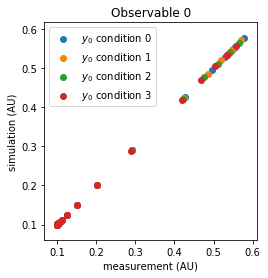

[0.4000123  0.40002545 0.40005266 0.40010894 0.40022538 0.40046616
 0.4009638  0.40199105 0.4041061  0.40843806 0.41721488 0.43460507
 0.46753068 0.52445703 0.60713044 0.69376801 0.73500837 0.70439349
 0.62886747 0.5355812 ] [0.40001243 0.40002572 0.40005321 0.40011008 0.40022773 0.40047104
 0.40097389 0.40201189 0.4041491  0.40852647 0.41739539 0.43496854
 0.46824194 0.52577065 0.60929503 0.69670961 0.73839152 0.70825844
 0.63302877 0.53912894]
[0.4000123  0.40002545 0.40005266 0.40010894 0.40022538 0.40046615
 0.40096376 0.40199086 0.40410531 0.40843473 0.41720084 0.43454691
 0.46729775 0.5235843  0.60424229 0.6861011  0.72067371 0.68526733
 0.60642    0.51180379] [0.40001243 0.40002571 0.40005321 0.40011008 0.40022773 0.40047103
 0.40097385 0.4020117  0.40414831 0.40852311 0.41738124 0.43490996
 0.46800742 0.52489239 0.60639146 0.68901538 0.72403439 0.68912724
 0.61056414 0.51525341]
[0.4000123  0.40002545 0.40005266 0.40010894 0.40022537 0.40046614
 0.40096372 0.40199068 0.40410453

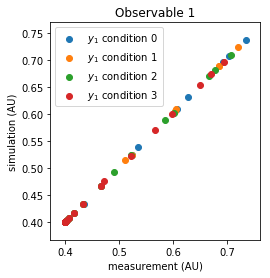

[0.6999792  0.69995696 0.69991095 0.69981577 0.69961885 0.6992116
 0.69836975 0.69663131 0.69304904 0.68569981 0.67075971 0.64095895
 0.58381563 0.4828983  0.33274096 0.17502923 0.08824506 0.06727818
 0.05651057 0.04468553] [0.6999791  0.69995675 0.6999105  0.69981483 0.69961692 0.69920759
 0.69836147 0.69661421 0.69301381 0.68562761 0.67061319 0.64066763
 0.58325981 0.48192074 0.33126267 0.17327792 0.08666848 0.06600666
 0.05553016 0.04391412]
[0.6999785  0.69995552 0.69990796 0.69980957 0.69960603 0.69918508
 0.69831495 0.6965182  0.69281623 0.68522334 0.66979577 0.63905514
 0.58023656 0.47681239 0.32424342 0.16659765 0.08234215 0.06252316
 0.05190231 0.04051998] [0.6999784  0.6999553  0.69990751 0.69980863 0.69960409 0.69918108
 0.69830667 0.69650111 0.69278102 0.68515118 0.66964946 0.63876466
 0.57968405 0.47584665 0.32280048 0.16492332 0.08087218 0.06136008
 0.05102327 0.03983143]
[0.6999778  0.69995407 0.69990496 0.69980337 0.6995932  0.69915856
 0.69826015 0.69640511 0.69258351 

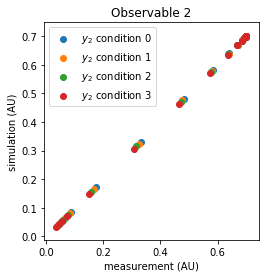

[0.2000356  0.20007366 0.20015241 0.20031533 0.2006524  0.20134958
 0.20279109 0.20576929 0.21191232 0.22454052 0.25031579 0.30212786
 0.4028219  0.58380281 0.8525968  1.1002188  1.15692673 1.11064669
 1.0570921  0.98989824] [0.19903553 0.19907346 0.19915196 0.19931438 0.19965037 0.20034535
 0.2017823  0.20475102 0.21087436 0.22346144 0.24915013 0.30077761
 0.40107439 0.58122586 0.8485773  1.09479892 1.15117049 1.10504914
 1.05204403 0.98499381]
[0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134956
 0.20279101 0.20576892 0.21191075 0.22453385 0.25028764 0.3020111
 0.40235471 0.58207915 0.84730771 1.08908853 1.14285653 1.09576545
 1.03970746 0.97057368] [0.19903553 0.19907346 0.19915196 0.19931437 0.19965037 0.20034533
 0.20178221 0.20475065 0.21087279 0.22345475 0.24912193 0.30066062
 0.40060641 0.57950003 0.84328445 1.08366642 1.13713337 1.0902739
 1.03479149 0.96575494]
[0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134954
 0.20279092 0.20576855 0.21190918 0

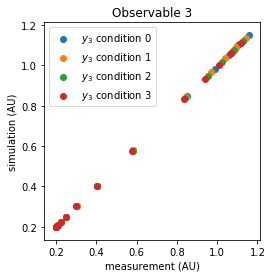

[3.4000123  3.40002545 3.40005266 3.40010894 3.40022538 3.40046616
 3.4009638  3.40199105 3.4041061  3.40843806 3.41721488 3.43460507
 3.46753068 3.52445703 3.60713044 3.69376801 3.73500837 3.70439349
 3.62886747 3.5355812 ] [3.39950827 3.39952155 3.39954905 3.39960592 3.39972357 3.39996688
 3.40046973 3.40150773 3.40364494 3.40802231 3.41689122 3.43446438
 3.46773778 3.52526649 3.60879086 3.69620545 3.73788736 3.70775427
 3.63252461 3.53862478]
[4.4000123  4.40002545 4.40005266 4.40010894 4.40022538 4.40046615
 4.40096376 4.40199086 4.40410531 4.40843473 4.41720084 4.43454691
 4.46729775 4.5235843  4.60424229 4.6861011  4.72067371 4.68526733
 4.60642    4.51180379] [4.37494662 4.37495991 4.3749874  4.37504428 4.37516193 4.37540522
 4.37590804 4.3769459  4.3790825  4.3834573  4.39231544 4.40984416
 4.44294161 4.49982659 4.58132566 4.66394958 4.69896859 4.66406144
 4.58549833 4.49018761]
[3.4000123  3.40002545 3.40005266 3.40010894 3.40022537 3.40046614
 3.40096372 3.40199068 3.40410453

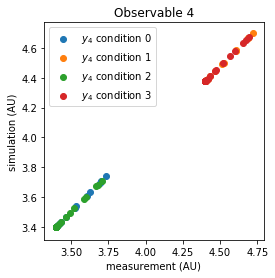

[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.12515789 0.15106393
 0.20141095 0.2919014  0.4262984  0.5501094  0.57846337 0.55532334
 0.52854605 0.49494912] [0.10001783 0.1000369  0.10007634 0.10015796 0.1003268  0.10067603
 0.10139812 0.10288994 0.10596699 0.11229216 0.12520105 0.1511445
 0.20154488 0.29207324 0.42642067 0.55015011 0.57847752 0.55530097
 0.52866524 0.49497167]
[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067478
 0.1013955  0.10288446 0.10595538 0.11226692 0.12514382 0.15100555
 0.20117735 0.29103957 0.42365386 0.54454426 0.57142826 0.54788272
 0.51985373 0.48528684] [0.10001783 0.1000369  0.10007634 0.10015796 0.1003268  0.10067602
 0.10139808 0.10288975 0.1059662  0.1122888  0.12518687 0.15108571
 0.20130972 0.29120599 0.42376095 0.54455589 0.57142369 0.54787622
 0.51999562 0.48530389]
[0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067477
 0.10139546 0.10288428 0.10595459 

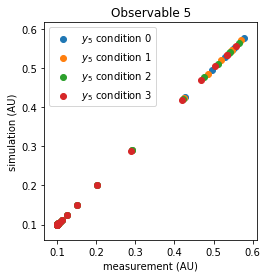

In [22]:
def plotCorrelation(ymes, ysim):
    for iy in range(ysim.shape[2]):
        fig, ax = plt.subplots()
        for icondition in range(ysim.shape[0]):
            x = ymes[icondition, :, iy]
            y = ysim[icondition, :, iy]
            print(x, y)
            ax.scatter(x, y, label='$y_%d$ condition %d' % (iy, icondition))
        plt.xlabel('measurement (AU)')
        plt.ylabel('simulation (AU)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Observable %d' % iy)
        plt.legend()
        plt.show()
        
plotCorrelation(ymes, ysim)

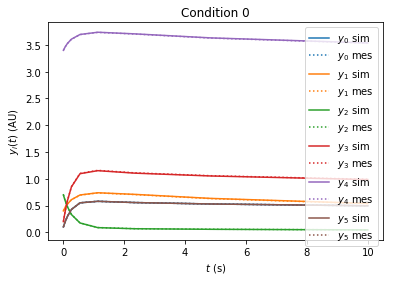

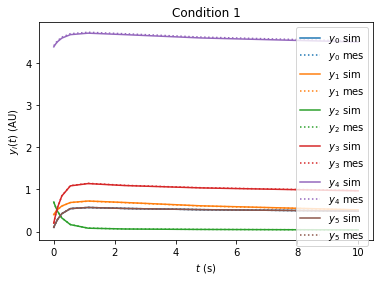

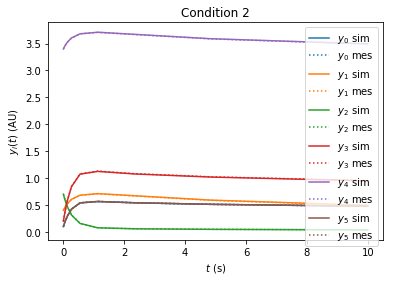

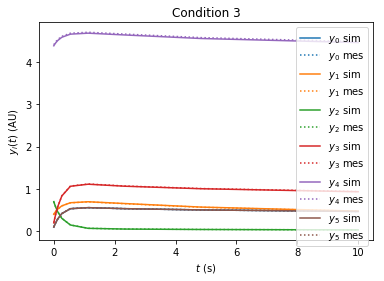

In [23]:
def plotTrajectoryFit(ymes, ysim, timepoints):
    for icondition in range(ysim.shape[0]):
        fig, ax = plt.subplots()
        for iy in range(ysim.shape[2]):
            ax.plot(timepoints, ysim[icondition, :, iy], label='$y_%d$ sim' % (iy), c='C%d'%iy)
            ax.plot(timepoints, ymes[icondition, :, iy], label='$y_%d$ mes' % (iy), linestyle='dotted', c='C%d'%iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.title('Condition %d' %icondition)
        plt.legend()
        plt.show()

plotTrajectoryFit(ymes, ysim, timepoints)

## Hierarchical optimization

In [24]:
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 1
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            4
                hierarchicalOptimization            1
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

In [25]:
# gradient check 
!PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deletemegc/ example_data.h5


HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-08-08 14:46:19] [WRN] [-1/]     0 g:  5.78032e+06  fd_c:  5.78023e+06  Δ/fd_c: 1.490970e-05  f:  4.50262e+07
[2018-08-08 14:46:19] [INF] [-1/]     1 g: -4.23811e+06  fd_c: -4.23812e+06  Δ/fd_c: -3.292771e-06  f:  4.50262e+07
[2018-08-08 14:46:19] [WRN] [-1/]     2 g: -4.71903e+06  fd_c: -4.71884e+06  Δ/fd_c: 3.986624e-05  f:  4.50262e+07
[2018-08-08 14:46:19] [WRN] [-1/]     3 g:       814181  fd_c:       814328  Δ/fd_c: -1.804779e-04  f:  4.50262e+07
[2018-08-08 14:46:19] [INF] [-1/]     4 g:  2.08873e+08  fd_c:  2.08873e+08  Δ/fd_c: -1.825721e-06  f:  4.50262e+07
[2018-08-08 14:46:19] [INF] [-1/] Walltime on master: 0.183615s, CPU time of all processes: 0.411168s


In [26]:
# optimization
!mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deletemehierarchical/ example_data.h5


[2018-08-08 14:46:20] [INF] [0/dweindl] Running with 4 MPI processes.
[2018-08-08 14:46:20] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2018-08-08 14:46:20] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2018-08-08 14:46:20] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2018-08-08 14:46:20] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2018-08-08 14:46:20] [DBG] [3/dweindl] Seeding RNG with 1533732380
[2018-08-08 14:46:20] [DBG] [0/dweindl] Seeding RNG with 1533732380
[2018-08-08 14:46:20] [DBG] [1/dweindl] Seeding RNG with 1533732380
[2018-08-08 14:46:20] [DBG] [2/dweindl] Seeding RNG with 1533732380
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-08-08 14:46:20] [DBG] [0/dweindl] Writing results to deletemehierarchical/_rank00000.h5.
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality,

[2018-08-08 14:46:20] [DBG] [3/dweindl] Result for 0.0.0.1 (4): 464.763 (0) (0.0298s)
[2] Message received after waiting 0.000267s.
[2018-08-08 14:46:20] [DBG] [2/dweindl] Result for 0.0.0.0 (7): -8976.06 (0) (0.0011s)
[2018-08-08 14:46:20] [DBG] [2/dweindl] Result for 0.0.0.1 (7): -15973.9 (0) (0.0011s)
[3] Message received after waiting 0.000225s.
[2018-08-08 14:46:20] [DBG] [2/dweindl] Result for 0.0.0.2 (7): -8971.85 (0) (0.0012s)
[2018-08-08 14:46:20] [DBG] [3/dweindl] Result for 0.0.0.0 (8): -8976.06 (0) (0.0012s)
[2018-08-08 14:46:20] [DBG] [2/dweindl] Result for 0.0.0.3 (7): -15970 (0) (0.0013s)
[2018-08-08 14:46:20] [DBG] [3/dweindl] Result for 0.0.0.1 (8): -15973.9 (0) (0.0016s)
[2] Message received after waiting 0.000909s.
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.3 (6): 483.184 (0) (0.0166s)
[2018-08-08 14:46:20] [DBG] [3/dweindl] Result for 0.0.0.2 (8): -8971.85 (0) (0.0025s)
[2018-08-08 14:46:20] [DBG] [3/dweindl] Result for 0.0.0.3 (8): -15970 (0) (0.0013s

[2] Message received after waiting 0.002167s.
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.0 (27): -9751.05 (0) (0.0156s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.1 (27): -16825 (0) (0.0022s)
[2018-08-08 14:46:20] [DBG] [2/dweindl] Result for 0.0.0.0 (30): -9751.05 (0) (0.0043s)
[2018-08-08 14:46:20] [DBG] [2/dweindl] Result for 0.0.0.1 (30): -16825 (0) (0.0022s)
[2018-08-08 14:46:20] [DBG] [3/dweindl] Result for 0.0.0.0 (29): -9798.69 (0) (0.0147s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.2 (27): -9670 (0) (0.0023s)
[2018-08-08 14:46:20] [DBG] [2/dweindl] Result for 0.0.0.2 (30): -9670 (0) (0.0025s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.3 (27): -16734.9 (0) (0.0022s)
[2018-08-08 14:46:20] [DBG] [2/dweindl] Result for 0.0.0.3 (30): -16734.9 (0) (0.0026s)
[2018-08-08 14:46:20] [DBG] [3/dweindl] Result for 0.0.0.1 (29): -16900.9 (0) (0.0044s)
[1] Message received after waiting 0.003813s.
[2018-08-08 14:46:20] [DBG] [3/dweindl

[2018-08-08 14:46:20] [DBG] [2/dweindl] Result for 0.0.0.2 (56): 70.7389 (0) (0.0159s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.3 (57): 72.6953 (0) (0.0152s)
[3] Message received after waiting 0.011301s.
[1] Message received after waiting 0.000225s.
[2018-08-08 14:46:20] [INF] [0/dweindl] iter: 1 cost: -278.405 time_iter: 0.2134s time_optim: 0.352722s
[2] Message received after waiting 0.004039s.
   1 -2.7840454e+02 0.00e+00 2.00e+01   1.8 6.96e+01    -  5.62e-01 7.45e-03f  4
[2018-08-08 14:46:20] [DBG] [3/dweindl] Result for 0.0.0.0 (58): 66.3431 (0) (0.0142s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.2 (60): 70.7389 (0) (0.0158s)
[3] Message received after waiting 0.001654s.
[1] Message received after waiting 0.000255s.
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.0 (62): -9393.94 (0) (0.0014s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.1 (62): -16456.1 (0) (0.0013s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.2 (6

[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.0 (95): -9466.69 (0) (0.0012s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.1 (95): -16552.2 (0) (0.0013s)
[2] Message received after waiting 0.003332s.
[2018-08-08 14:46:20] [INF] [0/dweindl] iter: 3 cost: -347.736 time_iter: 0.159909s time_optim: 0.613687s
   3 -3.4773555e+02 0.00e+00 2.75e-05   0.8 2.16e-01    -  1.00e+00 1.00e+00f  1
[3] Message received after waiting 0.003620s.
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.2 (95): -9429.18 (0) (0.0105s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.3 (95): -16509.7 (0) (0.0011s)
[1] Message received after waiting 0.001073s.
[2018-08-08 14:46:20] [DBG] [2/dweindl] Result for 0.0.0.0 (96): 83.4061 (0) (0.0136s)
[2] Message received after waiting 0.000253s.
[2018-08-08 14:46:20] [DBG] [3/dweindl] Result for 0.0.0.1 (97): 85.896 (0) (0.0160s)
[3] Message received after waiting 0.000275s.
[2018-08-08 14:46:20] [DBG] [3/dweindl] Result for 0.0.0.0

[2018-08-08 14:46:20] [DBG] [2/dweindl] Result for 0.0.0.0 (132): 88.8584 (0) (0.0155s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.1 (133): 91.7077 (0) (0.0137s)
[2] Message received after waiting 0.000287s.
[1] Message received after waiting 0.000213s.
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.0 (136): -9565.38 (0) (0.0013s)
[2018-08-08 14:46:20] [DBG] [3/dweindl] Result for 0.0.0.2 (134): 94.2828 (0) (0.0208s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.1 (136): -16684.2 (0) (0.0013s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.2 (136): -9516.72 (0) (0.0013s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.3 (136): -16628.5 (0) (0.0019s)
[1] Message received after waiting 0.001206s.
[3] Message received after waiting 0.001048s.
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.0 (137): -9565.38 (0) (0.0016s)
[2018-08-08 14:46:20] [DBG] [1/dweindl] Result for 0.0.0.1 (137): -16684.2 (0) (0.0013s)
[2018-08-08 14:46:

[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.0 (162): 75.1723 (0) (0.0155s)
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.2 (164): 81.7481 (0) (0.0154s)
[1] Message received after waiting 0.000398s.
[2018-08-08 14:46:21] [DBG] [3/dweindl] Result for 0.0.0.1 (163): 78.6417 (0) (0.0216s)
[2] Message received after waiting 0.000259s.
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.0 (166): -9588.92 (0) (0.0011s)
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.1 (166): -16715.7 (0) (0.0011s)
[3] Message received after waiting 0.000229s.
[2018-08-08 14:46:21] [DBG] [3/dweindl] Result for 0.0.0.0 (167): -9588.92 (0) (0.0012s)
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.2 (166): -9537.23 (0) (0.0011s)
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.3 (166): -16656.5 (0) (0.0012s)
[2018-08-08 14:46:21] [DBG] [3/dweindl] Result for 0.0.0.1 (167): -16715.7 (0) (0.0013s)
[2] Message received after waiting 0.001027s.
[2018-08-08 14:46:

[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.1 (199): 69.8312 (0) (0.0161s)
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.2 (200): 73.0901 (0) (0.0195s)
[3] Message received after waiting 0.000309s.
[1] Message received after waiting 0.000280s.
[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.0 (202): -9580.43 (0) (0.0013s)
[2] Message received after waiting 0.000207s.
[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.1 (202): -16707.3 (0) (0.0012s)
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.0 (203): -9580.43 (0) (0.0012s)
[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.2 (202): -9528.29 (0) (0.0014s)
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.1 (203): -16707.3 (0) (0.0012s)
[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.3 (202): -16647.4 (0) (0.0013s)
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.2 (203): -9528.29 (0) (0.0032s)
[1] Message received after waiting 0.003830s.
[2018-08-08 14:46

[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.0 (233): 118.381 (0) (0.0320s)
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.2 (235): 119.388 (0) (0.0282s)
[1] Message received after waiting 0.005539s.
[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.0 (237): -9202.76 (0) (0.0014s)
[2] Message received after waiting 0.000653s.
[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.1 (237): -16238.8 (0) (0.0019s)
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.0 (238): -9202.76 (0) (0.0013s)
[2018-08-08 14:46:21] [DBG] [3/dweindl] Result for 0.0.0.3 (236): 119.836 (0) (0.0227s)
[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.2 (237): -9177.21 (0) (0.0013s)
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.1 (238): -16238.8 (0) (0.0015s)
[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.3 (237): -16208.9 (0) (0.0013s)
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.2 (238): -9177.21 (0) (0.0014s)
[1] Message received 

[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.2 (265): -8364.09 (0) (0.0013s)
[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.3 (265): -15132.7 (0) (0.0016s)
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.1 (264): -15742.6 (0) (0.0042s)
[1] Message received after waiting 0.000006s.
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.2 (264): -8808.78 (0) (0.0040s)
[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.0 (267): -8365.43 (0) (0.0015s)
[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.1 (267): -15130.7 (0) (0.0019s)
[3] Message received after waiting 0.012338s.
[2018-08-08 14:46:21] [DBG] [2/dweindl] Result for 0.0.0.3 (264): -15737.6 (0) (0.0031s)
[2018-08-08 14:46:21] [DBG] [3/dweindl] Result for 0.0.0.0 (266): -8814.29 (0) (0.0021s)
[2018-08-08 14:46:21] [DBG] [1/dweindl] Result for 0.0.0.2 (267): -8364.09 (0) (0.0032s)
[2018-08-08 14:46:21] [DBG] [3/dweindl] Result for 0.0.0.1 (266): -15742.6 (0) (0.0015s)
[2018-08-08 14:46:

[2] Message received after waiting 0.006782s.
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.0 (298): -8647.06 (0) (0.0016s)
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.1 (298): -15528.9 (0) (0.0016s)
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.2 (298): -8646.61 (0) (0.0017s)
[3] Message received after waiting 0.007300s.
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.3 (298): -15531.1 (0) (0.0018s)
[2018-08-08 14:46:22] [DBG] [3/dweindl] Result for 0.0.0.0 (299): -8647.06 (0) (0.0019s)
[2018-08-08 14:46:22] [DBG] [3/dweindl] Result for 0.0.0.1 (299): -15528.9 (0) (0.0015s)
[2018-08-08 14:46:22] [DBG] [3/dweindl] Result for 0.0.0.2 (299): -8646.61 (0) (0.0016s)
[1] Message received after waiting 0.006509s.
[2] Message received after waiting 0.000089s.
[2018-08-08 14:46:22] [DBG] [3/dweindl] Result for 0.0.0.3 (299): -15531.1 (0) (0.0014s)
[3] Message received after waiting 0.000057s.
[2018-08-08 14:46:22] [DBG] [1/dweindl] Result for 0.0.0.0

[2018-08-08 14:46:22] [DBG] [1/dweindl] Result for 0.0.0.3 (328): -15831.2 (0) (0.0017s)
[3] Message received after waiting 0.007219s.
[1] Message received after waiting 0.000059s.
[2018-08-08 14:46:22] [DBG] [3/dweindl] Result for 0.0.0.0 (330): -8875.76 (0) (0.0016s)
[2018-08-08 14:46:22] [DBG] [1/dweindl] Result for 0.0.0.0 (331): -8875.76 (0) (0.0016s)
[2018-08-08 14:46:22] [DBG] [3/dweindl] Result for 0.0.0.1 (330): -15827 (0) (0.0019s)
[2018-08-08 14:46:22] [DBG] [1/dweindl] Result for 0.0.0.1 (331): -15827 (0) (0.0016s)
[2018-08-08 14:46:22] [DBG] [3/dweindl] Result for 0.0.0.2 (330): -8877.16 (0) (0.0016s)
[2018-08-08 14:46:22] [DBG] [1/dweindl] Result for 0.0.0.2 (331): -8877.16 (0) (0.0016s)
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.0 (329): -9396.47 (0) (0.0143s)
[2018-08-08 14:46:22] [DBG] [1/dweindl] Result for 0.0.0.3 (331): -15831.2 (0) (0.0020s)
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.1 (329): -16476.4 (0) (0.0018s)
[2018-08-08 14:46:22] 

[2] Message received after waiting 0.000429s.
[3] Message received after waiting 0.004534s.
[2018-08-08 14:46:22] [INF] [0/dweindl] iter: 12 cost: -709.455 time_iter: 0.261729s time_optim: 2.37057s
  12 -7.0945503e+02 0.00e+00 1.50e-04  -6.8 1.73e+00    -  1.00e+00 6.25e-02f  5
[1] Message received after waiting 0.006842s.
[2018-08-08 14:46:22] [DBG] [3/dweindl] Result for 0.0.0.0 (355): 175.922 (0) (0.0176s)
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.1 (356): 176.931 (0) (0.0285s)
[3] Message received after waiting 0.000290s.
[2] Message received after waiting 0.000251s.
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.0 (359): -9407.42 (0) (0.0015s)
[2018-08-08 14:46:22] [DBG] [1/dweindl] Result for 0.0.0.2 (357): 177.865 (0) (0.0229s)
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.1 (359): -16530.7 (0) (0.0016s)
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.2 (359): -9389.14 (0) (0.0014s)
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0

[1] Message received after waiting 0.000312s.
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.2 (382): 195.537 (0) (0.0182s)
[2] Message received after waiting 0.000277s.
[2018-08-08 14:46:22] [DBG] [3/dweindl] Result for 0.0.0.1 (381): 195.538 (0) (0.0300s)
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.0 (384): -9407.42 (0) (0.0014s)
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.1 (384): -16530.7 (0) (0.0013s)
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.2 (384): -9389.14 (0) (0.0013s)
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.3 (384): -16509.6 (0) (0.0013s)
[2] Message received after waiting 0.003704s.
[3] Message received after waiting 0.003926s.
[2018-08-08 14:46:22] [DBG] [1/dweindl] Result for 0.0.0.3 (383): 195.533 (0) (0.0179s)
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.0 (385): -9009.12 (0) (0.0014s)
[2018-08-08 14:46:22] [DBG] [3/dweindl] Result for 0.0.0.0 (386): -9241.11 (0) (0.0013s)
[2018-08-08 14:46:

[1] Message received after waiting 0.007173s.
[2018-08-08 14:46:22] [DBG] [1/dweindl] Result for 0.0.0.0 (407): -9070.34 (0) (0.0013s)
[2018-08-08 14:46:22] [DBG] [1/dweindl] Result for 0.0.0.1 (407): -16095.8 (0) (0.0014s)
[2018-08-08 14:46:22] [DBG] [1/dweindl] Result for 0.0.0.2 (407): -9063.21 (0) (0.0013s)
[2018-08-08 14:46:22] [INF] [0/dweindl] iter: 13 cost: -782.144 time_iter: 0.217932s time_optim: 2.73968s
[2018-08-08 14:46:22] [DBG] [1/dweindl] Result for 0.0.0.3 (407): -16088.2 (0) (0.0014s)
  13 -7.8214376e+02 0.00e+00 1.38e-04  -6.8 5.32e-01    -  9.89e-01 5.00e-01f  2
[3] Message received after waiting 0.007483s.
[2018-08-08 14:46:22] [DBG] [3/dweindl] Result for 0.0.0.0 (408): -9129.78 (0) (0.0013s)
[2] Message received after waiting 0.004559s.
[2018-08-08 14:46:22] [DBG] [3/dweindl] Result for 0.0.0.1 (408): -16169.8 (0) (0.0012s)
[1] Message received after waiting 0.001086s.
[2018-08-08 14:46:22] [DBG] [2/dweindl] Result for 0.0.0.0 (409): -9070.34 (0) (0.0015s)
[2018-

[2018-08-08 14:46:23] [DBG] [1/dweindl] Result for 0.0.0.1 (440): 204.69 (0) (0.0166s)
[1] Message received after waiting 0.000299s.
[2] Message received after waiting 0.000158s.
[2018-08-08 14:46:23] [DBG] [3/dweindl] Result for 0.0.0.3 (442): 204.333 (0) (0.0228s)
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.1 (444): 217.509 (0) (0.0149s)
[2018-08-08 14:46:23] [DBG] [1/dweindl] Result for 0.0.0.0 (443): 217.533 (0) (0.0174s)
[2018-08-08 14:46:23] [INF] [0/dweindl] iter: 14 cost: -818.435 time_iter: 0.227792s time_optim: 2.96748s
  14 -8.1843480e+02 0.00e+00 2.46e-04  -6.8 3.19e-01    -  1.00e+00 2.50e-01f  3
[3] Message received after waiting 0.004408s.
[1] Message received after waiting 0.001071s.
[2] Message received after waiting 0.003716s.
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.0 (447): -8978.08 (0) (0.0013s)
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.1 (447): -15975.4 (0) (0.0013s)
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0

[1] Message received after waiting 0.001810s.
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.2 (469): -8846.15 (0) (0.0056s)
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.3 (469): -15803.8 (0) (0.0013s)
[2] Message received after waiting 0.000007s.
[2018-08-08 14:46:23] [DBG] [3/dweindl] Result for 0.0.0.0 (470): 217.533 (0) (0.0226s)
[3] Message received after waiting 0.000464s.
[2018-08-08 14:46:23] [DBG] [1/dweindl] Result for 0.0.0.1 (471): 217.509 (0) (0.0277s)
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.2 (472): 217.476 (0) (0.0158s)
[2] Message received after waiting 0.000280s.
[1] Message received after waiting 0.000197s.
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.0 (474): -8722.02 (0) (0.0014s)
[2018-08-08 14:46:23] [DBG] [1/dweindl] Result for 0.0.0.0 (475): -8848.34 (0) (0.0016s)
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.1 (474): -15635.3 (0) (0.0015s)
[2018-08-08 14:46:23] [DBG] [1/dweindl] Result for 0.0.0.1 (4

[2018-08-08 14:46:23] [DBG] [1/dweindl] Result for 0.0.0.3 (498): -15753.2 (0) (0.0013s)
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.2 (499): -8808.62 (0) (0.0033s)
[3] Message received after waiting 0.006336s.
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.3 (499): -15753.2 (0) (0.0016s)
[1] Message received after waiting 0.003934s.
[2018-08-08 14:46:23] [DBG] [1/dweindl] Result for 0.0.0.0 (501): -8809.7 (0) (0.0013s)
[2018-08-08 14:46:23] [DBG] [3/dweindl] Result for 0.0.0.0 (500): -8848.34 (0) (0.0014s)
[2018-08-08 14:46:23] [DBG] [1/dweindl] Result for 0.0.0.1 (501): -15752.5 (0) (0.0014s)
[2] Message received after waiting 0.003463s.
[2018-08-08 14:46:23] [DBG] [3/dweindl] Result for 0.0.0.1 (500): -15804.7 (0) (0.0013s)
[2018-08-08 14:46:23] [DBG] [1/dweindl] Result for 0.0.0.2 (501): -8808.62 (0) (0.0015s)
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.0 (502): -8809.7 (0) (0.0013s)
[2018-08-08 14:46:23] [DBG] [3/dweindl] Result for 0.0.0.2 (500

[2018-08-08 14:46:23] [DBG] [3/dweindl] Result for 0.0.0.1 (533): -16041 (0) (0.0021s)
[2018-08-08 14:46:23] [DBG] [3/dweindl] Result for 0.0.0.2 (533): -9021.48 (0) (0.0013s)
[2] Message received after waiting 0.011498s.
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.0 (534): -9027.17 (0) (0.0033s)
[2018-08-08 14:46:23] [DBG] [3/dweindl] Result for 0.0.0.3 (533): -16035.3 (0) (0.0043s)
[1] Message received after waiting 0.000728s.
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.1 (534): -16041 (0) (0.0055s)
[2018-08-08 14:46:23] [DBG] [1/dweindl] Result for 0.0.0.0 (535): -9027.17 (0) (0.0015s)
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.2 (534): -9021.48 (0) (0.0015s)
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.3 (534): -16035.3 (0) (0.0015s)
[3] Message received after waiting 0.002504s.
[2018-08-08 14:46:23] [DBG] [3/dweindl] Result for 0.0.0.0 (536): -8861.58 (0) (0.0014s)
[2018-08-08 14:46:23] [DBG] [1/dweindl] Result for 0.0.0.1 (535):

[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.3 (558): -16016.9 (0) (0.0098s)
[2018-08-08 14:46:23] [DBG] [3/dweindl] Result for 0.0.0.0 (559): 232.018 (0) (0.0292s)
[2] Message received after waiting 0.007853s.
[3] Message received after waiting 0.000287s.
[2018-08-08 14:46:23] [DBG] [1/dweindl] Result for 0.0.0.1 (560): 232.315 (0) (0.0372s)
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.2 (561): 232.571 (0) (0.0164s)
[2018-08-08 14:46:23] [DBG] [3/dweindl] Result for 0.0.0.3 (562): 232.789 (0) (0.0176s)
[2] Message received after waiting 0.006198s.
[1] Message received after waiting 0.008531s.
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.0 (564): -9014.37 (0) (0.0013s)
[2018-08-08 14:46:23] [DBG] [1/dweindl] Result for 0.0.0.0 (563): -9027.17 (0) (0.0013s)
[2018-08-08 14:46:23] [INF] [0/dweindl] iter: 18 cost: -929.692 time_iter: 0.253058s time_optim: 3.84577s
[2018-08-08 14:46:23] [DBG] [2/dweindl] Result for 0.0.0.1 (564): -16022.8 (0) (0.0015s)
  

[2018-08-08 14:46:24] [DBG] [1/dweindl] Result for 0.0.0.2 (586): 241.02 (0) (0.0236s)
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.3 (587): 240.591 (0) (0.0193s)
[2018-08-08 14:46:24] [DBG] [2/dweindl] Result for 0.0.0.0 (588): 241.531 (0) (0.0159s)
[2] Message received after waiting 0.004287s.
[3] Message received after waiting 0.006369s.
[1] Message received after waiting 0.007624s.
[2018-08-08 14:46:24] [INF] [0/dweindl] iter: 19 cost: -964.482 time_iter: 0.279926s time_optim: 4.04298s
  19 -9.6448208e+02 0.00e+00 5.65e-04  -6.8 4.93e-02    -  1.00e+00 2.50e-01f  3
[2018-08-08 14:46:24] [DBG] [1/dweindl] Result for 0.0.0.2 (590): 241.02 (0) (0.0166s)
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.3 (591): 240.591 (0) (0.0169s)
[2018-08-08 14:46:24] [DBG] [2/dweindl] Result for 0.0.0.1 (589): 241.341 (0) (0.0230s)
[3] Message received after waiting 0.000468s.
[1] Message received after waiting 0.000195s.
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.

[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.3 (615): -15943.6 (0) (0.0029s)
[2] Message received after waiting 0.007430s.
[2018-08-08 14:46:24] [DBG] [2/dweindl] Result for 0.0.0.0 (616): -8956.25 (0) (0.0013s)
[2018-08-08 14:46:24] [DBG] [2/dweindl] Result for 0.0.0.1 (616): -15947.3 (0) (0.0013s)
[3] Message received after waiting 0.000297s.
[2018-08-08 14:46:24] [DBG] [2/dweindl] Result for 0.0.0.2 (616): -8952.08 (0) (0.0014s)
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.0 (617): -8942.9 (0) (0.0015s)
[2018-08-08 14:46:24] [DBG] [2/dweindl] Result for 0.0.0.3 (616): -15943.6 (0) (0.0015s)
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.1 (617): -15929.3 (0) (0.0014s)
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.2 (617): -8938.78 (0) (0.0013s)
[2] Message received after waiting 0.003247s.
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.3 (617): -15925.7 (0) (0.0016s)
[2018-08-08 14:46:24] [INF] [0/dweindl] iter: 19 cost: -964.48

[2] Message received after waiting 0.021620s.
[2018-08-08 14:46:24] [DBG] [1/dweindl] Result for 0.0.0.1 (639): 246.631 (0) (0.0329s)
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.2 (640): 246.125 (0) (0.0313s)
[1] Message received after waiting 0.005114s.
[2018-08-08 14:46:24] [DBG] [1/dweindl] Result for 0.0.0.0 (642): -8951.7 (0) (0.0013s)
[2018-08-08 14:46:24] [DBG] [1/dweindl] Result for 0.0.0.1 (642): -15941.2 (0) (0.0014s)
[2018-08-08 14:46:24] [DBG] [1/dweindl] Result for 0.0.0.2 (642): -8947.55 (0) (0.0017s)
[2018-08-08 14:46:24] [DBG] [1/dweindl] Result for 0.0.0.3 (642): -15937.5 (0) (0.0014s)
[3] Message received after waiting 0.007273s.
[2018-08-08 14:46:24] [DBG] [2/dweindl] Result for 0.0.0.3 (641): 245.467 (0) (0.0285s)
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.0 (643): -8923.71 (0) (0.0014s)
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.1 (643): -15904.2 (0) (0.0029s)
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.2 (643):

[1] Message received after waiting 0.019563s.
[2018-08-08 14:46:24] [DBG] [2/dweindl] Result for 0.0.0.0 (669): 250.306 (0) (0.0349s)
[3] Message received after waiting 0.000006s.
[2] Message received after waiting 0.002822s.
[2018-08-08 14:46:24] [DBG] [1/dweindl] Result for 0.0.0.1 (670): 249.466 (0) (0.0312s)
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.2 (671): 248.48 (0) (0.0266s)
[1] Message received after waiting 0.001471s.
[2018-08-08 14:46:24] [DBG] [1/dweindl] Result for 0.0.0.0 (673): -8891.68 (0) (0.0014s)
[2018-08-08 14:46:24] [DBG] [1/dweindl] Result for 0.0.0.1 (673): -15861.5 (0) (0.0014s)
[2018-08-08 14:46:24] [DBG] [1/dweindl] Result for 0.0.0.2 (673): -8888.79 (0) (0.0014s)
[3] Message received after waiting 0.005384s.
[2018-08-08 14:46:24] [DBG] [2/dweindl] Result for 0.0.0.3 (672): 247.398 (0) (0.0224s)
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.0 (674): -8924.73 (0) (0.0014s)
[2018-08-08 14:46:24] [DBG] [3/dweindl] Result for 0.0.0.1 (674

[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.1 (696): 249.466 (0) (0.0168s)
[2018-08-08 14:46:25] [INF] [0/dweindl] iter: 22 cost: -1008.99 time_iter: 0.311521s time_optim: 4.94142s
  22 -1.0089861e+03 0.00e+00 1.05e-03  -6.8 8.86e-03    -  1.00e+00 2.50e-01f  3
[2018-08-08 14:46:25] [DBG] [3/dweindl] Result for 0.0.0.0 (695): 250.306 (0) (0.0315s)
[2] Message received after waiting 0.007244s.
[1] Message received after waiting 0.008967s.
[3] Message received after waiting 0.001080s.
[2018-08-08 14:46:25] [DBG] [3/dweindl] Result for 0.0.0.0 (699): -8937.88 (0) (0.0013s)
[2018-08-08 14:46:25] [DBG] [3/dweindl] Result for 0.0.0.1 (699): -15923.4 (0) (0.0014s)
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.3 (698): 247.398 (0) (0.0163s)
[2018-08-08 14:46:25] [DBG] [3/dweindl] Result for 0.0.0.2 (699): -8934.22 (0) (0.0025s)
[2018-08-08 14:46:25] [DBG] [3/dweindl] Result for 0.0.0.3 (699): -15920.4 (0) (0.0014s)
[2018-08-08 14:46:25] [DBG] [1/dweindl] Result for 0.0.

[2] Message received after waiting 0.000221s.
[1] Message received after waiting 0.006078s.
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.0 (722): 260.64 (0) (0.0167s)
[2018-08-08 14:46:25] [DBG] [3/dweindl] Result for 0.0.0.2 (720): 261.137 (0) (0.0310s)
[2] Message received after waiting 0.000310s.
[2018-08-08 14:46:25] [DBG] [1/dweindl] Result for 0.0.0.3 (721): 261.304 (0) (0.0181s)
[3] Message received after waiting 0.000237s.
[2018-08-08 14:46:25] [INF] [0/dweindl] iter: 23 cost: -1043.99 time_iter: 0.229627s time_optim: 5.13262s
  23 -1.0439892e+03 0.00e+00 4.15e-03  -6.8 2.42e-02    -  1.00e+00 5.00e-01f  2
[1] Message received after waiting 0.006031s.
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.1 (723): 260.908 (0) (0.0155s)
[2] Message received after waiting 0.000432s.
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.0 (726): -8924.22 (0) (0.0014s)
[2018-08-08 14:46:25] [DBG] [3/dweindl] Result for 0.0.0.2 (724): 261.137 (0) (0.0216s)
[2018-08-

[2018-08-08 14:46:25] [DBG] [1/dweindl] Result for 0.0.0.1 (749): -15920.2 (0) (0.0014s)
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.0 (750): -8930.99 (0) (0.0014s)
[2018-08-08 14:46:25] [DBG] [1/dweindl] Result for 0.0.0.2 (749): -8931.98 (0) (0.0014s)
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.1 (750): -15914.1 (0) (0.0014s)
[2018-08-08 14:46:25] [DBG] [1/dweindl] Result for 0.0.0.3 (749): -15917.2 (0) (0.0016s)
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.2 (750): -8927.41 (0) (0.0014s)
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.3 (750): -15911.2 (0) (0.0015s)
[2] Message received after waiting 0.001626s.
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.0 (752): -8935.66 (0) (0.0013s)
[2018-08-08 14:46:25] [DBG] [3/dweindl] Result for 0.0.0.0 (745): 268.523 (0) (0.0562s)
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.1 (752): -15920.2 (0) (0.0013s)
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.2 (752):

[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.3 (781): -15899.2 (0) (0.0013s)
[3] Message received after waiting 0.010250s.
[2018-08-08 14:46:25] [DBG] [1/dweindl] Result for 0.0.0.0 (782): 272.69 (0) (0.0161s)
[2] Message received after waiting 0.011103s.
[1] Message received after waiting 0.000287s.
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.2 (784): 268.552 (0) (0.0170s)
[2018-08-08 14:46:25] [DBG] [3/dweindl] Result for 0.0.0.1 (783): 271.154 (0) (0.0183s)
[2018-08-08 14:46:25] [DBG] [1/dweindl] Result for 0.0.0.3 (785): 265.107 (0) (0.0274s)
[2] Message received after waiting 0.015521s.
[3] Message received after waiting 0.014701s.
[2018-08-08 14:46:25] [INF] [0/dweindl] iter: 25 cost: -1077.5 time_iter: 0.251291s time_optim: 5.59877s
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.0 (786): -8935.66 (0) (0.0012s)
  25 -1.0775034e+03 0.00e+00 3.80e-03  -6.8 1.40e-02    -  1.00e+00 2.50e-01f  3
[2018-08-08 14:46:25] [DBG] [3/dweindl] Result for 0.0.

[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.3 (811): -15908.2 (0) (0.0015s)
[2018-08-08 14:46:25] [DBG] [3/dweindl] Result for 0.0.0.3 (810): -15914.8 (0) (0.0082s)
[2] Message received after waiting 0.000078s.
[1] Message received after waiting 0.006416s.
[3] Message received after waiting 0.001168s.
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.0 (812): -8933.81 (0) (0.0013s)
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.1 (812): -15917.7 (0) (0.0015s)
[2018-08-08 14:46:25] [INF] [0/dweindl] iter: 25 cost: -1077.5 time_iter: 0.255188s time_optim: 5.77531s
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.2 (812): -8930.15 (0) (0.0014s)
  25 -1.0775037e+03 0.00e+00 3.80e-03  -6.8 1.40e-02    -  1.00e+00 2.50e-01f  3
[2018-08-08 14:46:25] [DBG] [2/dweindl] Result for 0.0.0.3 (812): -15914.8 (0) (0.0014s)
[2] Message received after waiting 0.000063s.
[2018-08-08 14:46:25] [DBG] [1/dweindl] Result for 0.0.0.0 (813): 273.797 (0) (0.0163s)
[2018-08

[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.0 (838): 273.797 (0) (0.0197s)
[2] Message received after waiting 0.000326s.
[1] Message received after waiting 0.000723s.
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.0 (842): -8931.07 (0) (0.0013s)
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.1 (842): -15914.1 (0) (0.0032s)
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.2 (842): -8927.47 (0) (0.0017s)
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.3 (842): -15911.3 (0) (0.0014s)
[2018-08-08 14:46:26] [DBG] [3/dweindl] Result for 0.0.0.2 (840): 268.536 (0) (0.0244s)
[2018-08-08 14:46:26] [DBG] [2/dweindl] Result for 0.0.0.3 (841): 264.992 (0) (0.0163s)
[1] Message received after waiting 0.003095s.
[3] Message received after waiting 0.000260s.
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.0 (843): -8931.07 (0) (0.0022s)
[2018-08-08 14:46:26] [DBG] [3/dweindl] Result for 0.0.0.0 (844): -8933.81 (0) (0.0014s)
[2018-08-08 14:46:

[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.1 (870): -15916.4 (0) (0.0019s)
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.2 (870): -8929.17 (0) (0.0016s)
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.3 (870): -15913.5 (0) (0.0014s)
[1] Message received after waiting 0.001141s.
[2018-08-08 14:46:26] [DBG] [2/dweindl] Result for 0.0.0.3 (869): 266.97 (0) (0.0180s)
[3] Message received after waiting 0.000285s.
[2018-08-08 14:46:26] [INF] [0/dweindl] iter: 27 cost: -1082.58 time_iter: 0.209697s time_optim: 6.22179s
  27 -1.0825776e+03 0.00e+00 2.14e-03  -6.8 2.78e-03    -  1.00e+00 5.00e-01f  2
[2] Message received after waiting 0.004961s.
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.0 (871): 274.577 (0) (0.0180s)
[2018-08-08 14:46:26] [DBG] [3/dweindl] Result for 0.0.0.1 (872): 273.093 (0) (0.0180s)
[1] Message received after waiting 0.000288s.
[3] Message received after waiting 0.000205s.
[2018-08-08 14:46:26] [DBG] [3/dweindl] Result for 0.

[1] Message received after waiting 0.000299s.
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.0 (905): -8932.59 (0) (0.0013s)
[3] Message received after waiting 0.005722s.
[2018-08-08 14:46:26] [INF] [0/dweindl] iter: 29 cost: -1086.32 time_iter: 0.23101s time_optim: 6.5427s
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.1 (905): -15916.1 (0) (0.0023s)
  29 -1.0863245e+03 0.00e+00 2.78e-04  -6.8 4.83e-04    -  1.00e+00 1.00e+00f  1
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.2 (905): -8928.97 (0) (0.0016s)
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.3 (905): -15913.2 (0) (0.0015s)
[2] Message received after waiting 0.006190s.
[2018-08-08 14:46:26] [DBG] [2/dweindl] Result for 0.0.0.0 (906): -8932.8 (0) (0.0012s)
[2018-08-08 14:46:26] [DBG] [3/dweindl] Result for 0.0.0.0 (904): -8932.43 (0) (0.0076s)
[2018-08-08 14:46:26] [DBG] [2/dweindl] Result for 0.0.0.1 (906): -15916.4 (0) (0.0012s)
[1] Message received after waiting 0.003596s.
[2018-08-

[2018-08-08 14:46:26] [DBG] [2/dweindl] Result for 0.0.0.1 (937): -15916.1 (0) (0.0014s)
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.2 (938): -8945.31 (0) (0.0013s)
[2018-08-08 14:46:26] [DBG] [3/dweindl] Result for 0.0.0.3 (936): -15955.1 (0) (0.0063s)
[2018-08-08 14:46:26] [DBG] [2/dweindl] Result for 0.0.0.2 (937): -8928.97 (0) (0.0014s)
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.3 (938): -15934.8 (0) (0.0013s)
[2018-08-08 14:46:26] [DBG] [2/dweindl] Result for 0.0.0.3 (937): -15913.2 (0) (0.0013s)
[2] Message received after waiting 0.000151s.
[2018-08-08 14:46:26] [DBG] [2/dweindl] Result for 0.0.0.0 (939): -8932.59 (0) (0.0012s)
[2018-08-08 14:46:26] [DBG] [2/dweindl] Result for 0.0.0.1 (939): -15916.1 (0) (0.0012s)
[1] Message received after waiting 0.003907s.
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.0 (940): -8932.59 (0) (0.0013s)
[2018-08-08 14:46:26] [DBG] [1/dweindl] Result for 0.0.0.1 (940): -15916.1 (0) (0.0013s)
[2018-08-08 14:46:

[2018-08-08 14:46:27] [DBG] [3/dweindl] Result for 0.0.0.1 (970): -15958.7 (0) (0.0014s)
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.3 (971): -16075.2 (0) (0.0013s)
[2018-08-08 14:46:27] [DBG] [3/dweindl] Result for 0.0.0.2 (970): -8960.63 (0) (0.0016s)
[2018-08-08 14:46:27] [DBG] [2/dweindl] Result for 0.0.0.3 (969): 268.371 (0) (0.0161s)
[1] Message received after waiting 0.000007s.
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.0 (972): -8940.97 (0) (0.0032s)
[2018-08-08 14:46:27] [DBG] [3/dweindl] Result for 0.0.0.3 (970): -15955.1 (0) (0.0014s)
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.1 (972): -15927.3 (0) (0.0015s)
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.2 (972): -8937.25 (0) (0.0020s)
[2018-08-08 14:46:27] [INF] [0/dweindl] iter: 31 cost: -1092.25 time_iter: 0.41574s time_optim: 7.09303s
  31 -1.0922546e+03 0.00e+00 1.53e-03  -6.8 8.98e-02    -  1.00e+00 1.25e-01f  4
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.

[2] Message received after waiting 0.000009s.
[3] Message received after waiting 0.002846s.
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.1 (994): 274.794 (0) (0.0350s)
[2018-08-08 14:46:27] [DBG] [2/dweindl] Result for 0.0.0.2 (995): 271.765 (0) (0.0233s)
[1] Message received after waiting 0.000324s.
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.0 (997): -9058.81 (0) (0.0013s)
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.1 (997): -16082.3 (0) (0.0012s)
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.2 (997): -9052.09 (0) (0.0012s)
[2018-08-08 14:46:27] [DBG] [3/dweindl] Result for 0.0.0.3 (996): 268.37 (0) (0.0243s)
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.3 (997): -16075.2 (0) (0.0018s)
[1] Message received after waiting 0.005328s.
[2018-08-08 14:46:27] [INF] [0/dweindl] iter: 31 cost: -1092.25 time_iter: 0.27619s time_optim: 7.29131s
  31 -1.0922538e+03 0.00e+00 1.53e-03  -6.8 8.98e-02    -  1.00e+00 1.25e-01f  4
[2018-08-08

[1] Message received after waiting 0.006765s.
[2018-08-08 14:46:27] [DBG] [2/dweindl] Result for 0.0.0.3 (1018): -15960.6 (0) (0.0137s)
[2] Message received after waiting 0.000007s.
[2018-08-08 14:46:27] [DBG] [3/dweindl] Result for 0.0.0.1 (1021): 275.087 (0) (0.0243s)
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.0 (1020): 277.809 (0) (0.0227s)
[2018-08-08 14:46:27] [DBG] [2/dweindl] Result for 0.0.0.2 (1022): 271.958 (0) (0.0183s)
[2] Message received after waiting 0.003089s.
[3] Message received after waiting 0.007286s.
[1] Message received after waiting 0.004031s.
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.0 (1024): -8940.61 (0) (0.0013s)
[2018-08-08 14:46:27] [DBG] [3/dweindl] Result for 0.0.0.0 (1025): -8944.4 (0) (0.0014s)
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.1 (1024): -15926.8 (0) (0.0013s)
[2018-08-08 14:46:27] [DBG] [3/dweindl] Result for 0.0.0.1 (1025): -15931.8 (0) (0.0014s)
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0

[2018-08-08 14:46:27] [DBG] [3/dweindl] Result for 0.0.0.1 (1052): -15954.4 (0) (0.0013s)
[2018-08-08 14:46:27] [DBG] [3/dweindl] Result for 0.0.0.2 (1052): -8957.32 (0) (0.0014s)
[2018-08-08 14:46:27] [DBG] [3/dweindl] Result for 0.0.0.3 (1052): -15950.8 (0) (0.0013s)
[1] Message received after waiting 0.009624s.
[2] Message received after waiting 0.001135s.
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.0 (1053): -8968.92 (0) (0.0016s)
[3] Message received after waiting 0.001062s.
[2018-08-08 14:46:27] [DBG] [2/dweindl] Result for 0.0.0.0 (1054): -8953.88 (0) (0.0013s)
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.1 (1053): -15964.4 (0) (0.0016s)
[2018-08-08 14:46:27] [DBG] [2/dweindl] Result for 0.0.0.1 (1054): -15944.4 (0) (0.0014s)
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0.0.0.2 (1053): -8964.74 (0) (0.0014s)
[2018-08-08 14:46:27] [DBG] [2/dweindl] Result for 0.0.0.2 (1054): -8949.95 (0) (0.0014s)
[2018-08-08 14:46:27] [DBG] [1/dweindl] Result for 0

[2] Message received after waiting 0.005933s.
[2018-08-08 14:46:28] [DBG] [3/dweindl] Result for 0.0.0.0 (1090): 286.113 (0) (0.0215s)
[2018-08-08 14:46:28] [DBG] [1/dweindl] Result for 0.0.0.1 (1091): 284.734 (0) (0.0206s)
[3] Message received after waiting 0.000313s.
[1] Message received after waiting 0.000188s.
[2018-08-08 14:46:28] [DBG] [1/dweindl] Result for 0.0.0.0 (1094): -8961.19 (0) (0.0013s)
[2018-08-08 14:46:28] [DBG] [2/dweindl] Result for 0.0.0.2 (1092): 283.355 (0) (0.0225s)
[2018-08-08 14:46:28] [DBG] [1/dweindl] Result for 0.0.0.1 (1094): -15954.1 (0) (0.0014s)
[2018-08-08 14:46:28] [DBG] [1/dweindl] Result for 0.0.0.2 (1094): -8957.13 (0) (0.0013s)
[2018-08-08 14:46:28] [DBG] [1/dweindl] Result for 0.0.0.3 (1094): -15950.5 (0) (0.0015s)
[1] Message received after waiting 0.000877s.
[2] Message received after waiting 0.001580s.
[2018-08-08 14:46:28] [DBG] [3/dweindl] Result for 0.0.0.3 (1093): 281.993 (0) (0.0180s)
[2018-08-08 14:46:28] [INF] [0/dweindl] iter: 34 cost:

[3] Message received after waiting 0.009129s.
[2018-08-08 14:46:28] [DBG] [3/dweindl] Result for 0.0.0.0 (1122): -8969.55 (0) (0.0015s)
[2018-08-08 14:46:28] [DBG] [1/dweindl] Result for 0.0.0.2 (1121): -8957.13 (0) (0.0059s)
[2018-08-08 14:46:28] [DBG] [3/dweindl] Result for 0.0.0.1 (1122): -15965.2 (0) (0.0017s)
[2018-08-08 14:46:28] [DBG] [1/dweindl] Result for 0.0.0.3 (1121): -15950.5 (0) (0.0014s)
[2018-08-08 14:46:28] [DBG] [3/dweindl] Result for 0.0.0.2 (1122): -8965.35 (0) (0.0014s)
[2018-08-08 14:46:28] [DBG] [2/dweindl] Result for 0.0.0.3 (1120): 286.221 (0) (0.0200s)
[2018-08-08 14:46:28] [DBG] [3/dweindl] Result for 0.0.0.3 (1122): -15961.4 (0) (0.0015s)
[1] Message received after waiting 0.003989s.
[2018-08-08 14:46:28] [DBG] [1/dweindl] Result for 0.0.0.0 (1123): -8961.19 (0) (0.0014s)
[3] Message received after waiting 0.000006s.
[2018-08-08 14:46:28] [INF] [0/dweindl] iter: 36 cost: -1144.53 time_iter: 0.227763s time_optim: 8.24625s
  36 -1.1445296e+03 0.00e+00 2.24e-03

[2] Message received after waiting 0.003179s.
[2018-08-08 14:46:28] [DBG] [1/dweindl] Result for 0.0.0.2 (1152): -8678.69 (0) (0.0111s)
[2018-08-08 14:46:28] [DBG] [1/dweindl] Result for 0.0.0.3 (1152): -15577.5 (0) (0.0014s)
[1] Message received after waiting 0.000008s.
[2018-08-08 14:46:28] [DBG] [3/dweindl] Result for 0.0.0.0 (1155): 285.982 (0) (0.0187s)
[3] Message received after waiting 0.001175s.
[2018-08-08 14:46:28] [DBG] [2/dweindl] Result for 0.0.0.1 (1156): 286.132 (0) (0.0308s)
[2] Message received after waiting 0.003194s.
[2018-08-08 14:46:28] [DBG] [2/dweindl] Result for 0.0.0.0 (1159): -8442.34 (0) (0.0016s)
[2018-08-08 14:46:28] [DBG] [2/dweindl] Result for 0.0.0.1 (1159): -15246.9 (0) (0.0014s)
[2018-08-08 14:46:28] [DBG] [2/dweindl] Result for 0.0.0.2 (1159): -8432.32 (0) (0.0017s)
[2018-08-08 14:46:28] [DBG] [3/dweindl] Result for 0.0.0.3 (1158): 286.23 (0) (0.0235s)
[2018-08-08 14:46:28] [DBG] [1/dweindl] Result for 0.0.0.2 (1157): 286.209 (0) (0.0332s)
[2018-08-08

[2018-08-08 14:46:28] [DBG] [3/dweindl] Result for 0.0.0.0 (1178): 286.919 (0) (0.0186s)
[2018-08-08 14:46:28] [DBG] [2/dweindl] Result for 0.0.0.2 (1180): 286.094 (0) (0.0178s)
[3] Message received after waiting 0.000426s.
[2] Message received after waiting 0.000511s.
[2018-08-08 14:46:28] [DBG] [2/dweindl] Result for 0.0.0.0 (1182): -8896.87 (0) (0.0016s)
[2018-08-08 14:46:28] [DBG] [2/dweindl] Result for 0.0.0.1 (1182): -15868.8 (0) (0.0057s)
[2018-08-08 14:46:28] [DBG] [3/dweindl] Result for 0.0.0.3 (1181): 285.902 (0) (0.0180s)
[2018-08-08 14:46:28] [DBG] [2/dweindl] Result for 0.0.0.2 (1182): -8893.69 (0) (0.0016s)
[2018-08-08 14:46:28] [DBG] [2/dweindl] Result for 0.0.0.3 (1182): -15866.5 (0) (0.0016s)
[2018-08-08 14:46:28] [DBG] [1/dweindl] Result for 0.0.0.1 (1179): 286.429 (0) (0.0426s)
[2] Message received after waiting 0.003255s.
[3] Message received after waiting 0.000200s.
[2018-08-08 14:46:28] [DBG] [2/dweindl] Result for 0.0.0.0 (1183): -8960.52 (0) (0.0017s)
[2018-08-0

[2018-08-08 14:46:29] [DBG] [2/dweindl] Result for 0.0.0.3 (1207): 285.909 (0) (0.0181s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.2 (1206): 286.1 (0) (0.0182s)
[2] Message received after waiting 0.000297s.
[2018-08-08 14:46:29] [DBG] [2/dweindl] Result for 0.0.0.0 (1208): -8967.3 (0) (0.0015s)
[3] Message received after waiting 0.000355s.
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.0 (1209): -8977.44 (0) (0.0015s)
[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.1 (1205): 286.433 (0) (0.0420s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.1 (1209): -15975.6 (0) (0.0062s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.2 (1209): -8973.14 (0) (0.0014s)
[2018-08-08 14:46:29] [DBG] [2/dweindl] Result for 0.0.0.1 (1208): -15962.2 (0) (0.0116s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.3 (1209): -15971.7 (0) (0.0014s)
[3] Message received after waiting 0.001130s.
[2018-08-08 14:46:29] [DBG] [2/dweindl] Result for 0.0.0.2

[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.2 (1234): 290.665 (0) (0.0203s)
[3] Message received after waiting 0.000295s.
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.0 (1236): -8977.53 (0) (0.0014s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.1 (1236): -15975.8 (0) (0.0013s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.2 (1236): -8973.23 (0) (0.0013s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.3 (1236): -15971.8 (0) (0.0014s)
[3] Message received after waiting 0.002767s.
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.0 (1237): -35919.3 (0) (0.0025s)
[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.3 (1235): 290.739 (0) (0.0265s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.1 (1237): -43249.8 (0) (0.0021s)
[2018-08-08 14:46:29] [DBG] [2/dweindl] Result for 0.0.0.1 (1233): 290.405 (0) (0.0401s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.2 (1237): -35944.3 (0) (0.0022s)
[2018-08-08

[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.3 (1260): -1.07923e+08 (0) (0.0061s)
[2018-08-08 14:46:29] [DBG] [2/dweindl] Result for 0.0.0.3 (1261): -15968.9 (0) (0.0014s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.2 (1259): -1.03945e+08 (0) (0.0229s)
[1] Message received after waiting 0.013373s.
[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.0 (1262): -9377.76 (0) (0.0015s)
[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.1 (1262): -16474.8 (0) (0.0018s)
[2] Message received after waiting 0.000007s.
[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.2 (1262): -9370.99 (0) (0.0016s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.3 (1259): -1.03922e+08 (0) (0.0100s)
[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.3 (1262): -16465.5 (0) (0.0015s)
[1] Message received after waiting 0.000071s.
[2018-08-08 14:46:29] [DBG] [2/dweindl] Result for 0.0.0.0 (1263): -37308.7 (0) (0.0024s)
[2018-08-08 14:46:29] [DBG] [1/dweindl] 

[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.3 (1289): -15974.9 (0) (0.0014s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.0 (1290): -8976.28 (0) (0.0046s)
[2] Message received after waiting 0.000008s.
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.1 (1290): -15974.1 (0) (0.0016s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.2 (1290): -8972.04 (0) (0.0015s)
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.3 (1290): -15970.2 (0) (0.0026s)
[1] Message received after waiting 0.000007s.
[2018-08-08 14:46:29] [DBG] [2/dweindl] Result for 0.0.0.0 (1291): -8975.05 (0) (0.0014s)
[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.0 (1292): -8968.61 (0) (0.0015s)
[2018-08-08 14:46:29] [DBG] [2/dweindl] Result for 0.0.0.1 (1291): -15972.6 (0) (0.0016s)
[3] Message received after waiting 0.002875s.
[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.1 (1292): -15964.3 (0) (0.0015s)
[2018-08-08 14:46:29] [DBG] [2/dweindl] Result for 0

[2018-08-08 14:46:29] [INF] [0/dweindl] iter: 39 cost: -1167.88 time_iter: 0.555658s time_optim: 9.88324s
[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.0 (1317): -9152.94 (0) (0.0013s)
  39 -1.1678805e+03 0.00e+00 1.16e-02  -6.8 5.53e+00    -  6.11e-01 1.59e-03f 10
[2018-08-08 14:46:29] [DBG] [3/dweindl] Result for 0.0.0.3 (1316): -15970.2 (0) (0.0050s)
[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.1 (1317): -16207.5 (0) (0.0013s)
[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.2 (1317): -9145.55 (0) (0.0012s)
[2018-08-08 14:46:29] [DBG] [1/dweindl] Result for 0.0.0.3 (1317): -16198.7 (0) (0.0013s)
[2] Message received after waiting 0.015658s.
[2018-08-08 14:46:29] [DBG] [2/dweindl] Result for 0.0.0.0 (1318): -8979.42 (0) (0.0015s)
[2018-08-08 14:46:29] [DBG] [2/dweindl] Result for 0.0.0.1 (1318): -15978.4 (0) (0.0013s)
[2018-08-08 14:46:29] [DBG] [2/dweindl] Result for 0.0.0.2 (1318): -8975.2 (0) (0.0013s)
[2018-08-08 14:46:29] [DBG] [2/dweindl] Result f

[2] Message received after waiting 0.005387s.
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.0 (1346): -8977.93 (0) (0.0014s)
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.1 (1345): -15976.3 (0) (0.0048s)
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.1 (1346): -15976.4 (0) (0.0013s)
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.2 (1346): -8973.74 (0) (0.0013s)
[2018-08-08 14:46:30] [INF] [0/dweindl] iter: 40 cost: -1169.37 time_iter: 0.21334s time_optim: 10.0966s
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.3 (1346): -15972.5 (0) (0.0013s)
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -1.1693731e+03 0.00e+00 2.05e-02  -6.8 3.91e-02    -  1.00e+00 5.00e-01f  2
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.2 (1345): -8973.65 (0) (0.0038s)
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.3 (1345): -15972.4 (0) (0.0015s)
[1] Message received after waiting 0.008606s.
[2018-08-08

[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.0 (1372): -8978.51 (0) (0.0062s)
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.1 (1372): -15977.2 (0) (0.0014s)
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.2 (1372): -8974.33 (0) (0.0013s)
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.3 (1372): -15973.3 (0) (0.0036s)
[2] Message received after waiting 0.000073s.
[1] Message received after waiting 0.012756s.
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.0 (1374): -8978.47 (0) (0.0014s)
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.1 (1374): -15977.1 (0) (0.0014s)
[2018-08-08 14:46:30] [DBG] [1/dweindl] Result for 0.0.0.0 (1373): -9025.71 (0) (0.0014s)
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.2 (1374): -8974.28 (0) (0.0014s)
[2018-08-08 14:46:30] [DBG] [1/dweindl] Result for 0.0.0.1 (1373): -16041 (0) (0.0020s)
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.3 (1374): -15973.2 (0) (0.0014s)
[2018-08-0

[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.0 (1397): -8977.86 (0) (0.0013s)
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.1 (1397): -15976.3 (0) (0.0013s)
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.2 (1397): -8973.68 (0) (0.0013s)
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.3 (1397): -15972.4 (0) (0.0013s)
[1] Message received after waiting 0.006395s.
[3] Message received after waiting 0.014705s.
[2] Message received after waiting 0.003212s.
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.0 (1400): -8977.86 (0) (0.0014s)
[2018-08-08 14:46:30] [DBG] [1/dweindl] Result for 0.0.0.0 (1399): -8976.88 (0) (0.0014s)
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.0 (1398): -8969.03 (0) (0.0014s)
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.1 (1400): -15976.3 (0) (0.0012s)
[2018-08-08 14:46:30] [DBG] [1/dweindl] Result for 0.0.0.1 (1399): -15975 (0) (0.0013s)
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0

[2018-08-08 14:46:30] [INF] [0/dweindl] iter: 42 cost: -1220.6 time_iter: 0.249422s time_optim: 10.5979s
  42 -1.2206020e+03 0.00e+00 3.81e-02  -6.8 6.73e-02    -  1.00e+00 2.50e-01f  3
[2018-08-08 14:46:30] [DBG] [1/dweindl] Result for 0.0.0.0 (1427): -8868.3 (0) (0.0016s)
[2018-08-08 14:46:30] [DBG] [1/dweindl] Result for 0.0.0.1 (1427): -15828.7 (0) (0.0015s)
[2018-08-08 14:46:30] [DBG] [1/dweindl] Result for 0.0.0.2 (1427): -8863.62 (0) (0.0015s)
[3] Message received after waiting 0.010943s.
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.3 (1426): -15977.2 (0) (0.0108s)
[2018-08-08 14:46:30] [DBG] [1/dweindl] Result for 0.0.0.3 (1427): -15825.3 (0) (0.0015s)
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.0 (1428): -8970.26 (0) (0.0021s)
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.1 (1428): -15966.2 (0) (0.0015s)
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.2 (1428): -8966.18 (0) (0.0014s)
[2] Message received after waiting 0.004905s.
[20

[2018-08-08 14:46:30] [DBG] [1/dweindl] Result for 0.0.0.0 (1452): -8930.27 (0) (0.0014s)
[3] Message received after waiting 0.001916s.
[2018-08-08 14:46:30] [DBG] [1/dweindl] Result for 0.0.0.1 (1452): -15912.8 (0) (0.0015s)
[2018-08-08 14:46:30] [DBG] [1/dweindl] Result for 0.0.0.2 (1452): -8926.25 (0) (0.0014s)
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.0 (1453): -8523.62 (0) (0.0031s)
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.1 (1453): -15354.6 (0) (0.0021s)
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.2 (1453): -8514.85 (0) (0.0018s)
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.3 (1453): -15347.1 (0) (0.0019s)
[2018-08-08 14:46:30] [DBG] [1/dweindl] Result for 0.0.0.3 (1452): -15909.5 (0) (0.0109s)
[3] Message received after waiting 0.018474s.
[2018-08-08 14:46:30] [DBG] [3/dweindl] Result for 0.0.0.0 (1454): -8967.82 (0) (0.0015s)
[2018-08-08 14:46:30] [DBG] [2/dweindl] Result for 0.0.0.3 (1450): 307.286 (0) (0.0463s)
[1] Messa

[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.3 (1471): 304.501 (0) (0.0165s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.1 (1473): -15912.2 (0) (0.0014s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.2 (1473): -8925.9 (0) (0.0016s)
[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.0.0.0 (1468): 309.534 (0) (0.0488s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.3 (1473): -15909.1 (0) (0.0015s)
[2] Message received after waiting 0.000254s.
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.0 (1474): -8970.64 (0) (0.0013s)
[3] Message received after waiting 0.002601s.
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.1 (1474): -15966.7 (0) (0.0012s)
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.2 (1474): -8966.51 (0) (0.0013s)
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.3 (1474): -15962.9 (0) (0.0013s)
[2] Message received after waiting 0.001125s.
[2018-08-08 14:46:31] [INF] [0/dweindl] iter: 43 cost: 

[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.0.0.2 (1494): -8971.89 (0) (0.0013s)
[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.0.0.3 (1494): -15970 (0) (0.0014s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.3 (1496): -17559.7 (0) (0.0040s)
[2] Message received after waiting 0.013618s.
[3] Message received after waiting 0.002724s.
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.0 (1497): -8733.26 (0) (0.0014s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.0 (1498): -9203.03 (0) (0.0014s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.1 (1498): -16270.1 (0) (0.0013s)
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.1 (1497): -15646.3 (0) (0.0023s)
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.2 (1497): -8728.42 (0) (0.0015s)
[1] Message received after waiting 0.000007s.
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.2 (1498): -9191.04 (0) (0.0025s)
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0

[2] Message received after waiting 0.002930s.
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.0 (1527): -8972.77 (0) (0.0013s)
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.1 (1527): -15969.5 (0) (0.0013s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.1 (1526): -15977.5 (0) (0.0018s)
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.2 (1527): -8968.61 (0) (0.0013s)
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.3 (1527): -15965.7 (0) (0.0013s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.2 (1526): -8974.53 (0) (0.0019s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.3 (1526): -15973.5 (0) (0.0015s)
[2] Message received after waiting 0.002958s.
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.0 (1529): -8976.71 (0) (0.0013s)
[3] Message received after waiting 0.002498s.
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.1 (1529): -15974.7 (0) (0.0013s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0

[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.0.0.0 (1558): -8970.8 (0) (0.0012s)
[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.0.0.1 (1558): -15967 (0) (0.0012s)
[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.0.0.2 (1558): -8966.77 (0) (0.0014s)
[3] Message received after waiting 0.003951s.
[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.0.0.3 (1558): -15963.3 (0) (0.0057s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.0 (1560): -8973.62 (0) (0.0014s)
[2] Message received after waiting 0.012800s.
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.1 (1560): -15970.6 (0) (0.0015s)
[1] Message received after waiting 0.003041s.
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.0 (1559): -8774.3 (0) (0.0013s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.2 (1560): -8969.45 (0) (0.0015s)
[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.0.0.0 (1561): -8964.23 (0) (0.0013s)
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0

[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.2 (1588): 307.619 (0) (0.0170s)
[1] Message received after waiting 0.000291s.
[3] Message received after waiting 0.000238s.
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.0 (1590): -8971.44 (0) (0.0014s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.1 (1590): -15967.7 (0) (0.0014s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.2 (1590): -8967.29 (0) (0.0012s)
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.1 (1587): 307.882 (0) (0.0340s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.3 (1590): -15964 (0) (0.0015s)
[3] Message received after waiting 0.002532s.
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.0 (1591): -8972.62 (0) (0.0013s)
[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.0.0.3 (1589): 307.043 (0) (0.0163s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.1 (1591): -15969.3 (0) (0.0014s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.

[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.0.0.1 (1618): -15878.5 (0) (0.0012s)
[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.0.0.2 (1618): -8901.1 (0) (0.0012s)
[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.0.0.3 (1618): -15877.3 (0) (0.0013s)
[3] Message received after waiting 0.007745s.
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.0 (1619): -8981.77 (0) (0.0013s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.1 (1619): -15981.4 (0) (0.0014s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.2 (1619): -8977.39 (0) (0.0013s)
[2018-08-08 14:46:31] [DBG] [3/dweindl] Result for 0.0.0.3 (1619): -15977.3 (0) (0.0013s)
[1] Message received after waiting 0.003988s.
[2] Message received after waiting 0.001004s.
[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.0.0.0 (1620): -8975.77 (0) (0.0020s)
[2018-08-08 14:46:31] [DBG] [2/dweindl] Result for 0.0.0.0 (1621): -8903.23 (0) (0.0015s)
[2018-08-08 14:46:31] [DBG] [1/dweindl] Result for 0.

[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.2 (1645): -8955.88 (0) (0.0012s)
[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.3 (1645): -15949.3 (0) (0.0012s)
  46 -1.2369814e+03 0.00e+00 1.50e-02  -6.8 2.47e-02    -  1.00e+00 2.50e-01f  3
[2] Message received after waiting 0.008516s.
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.0 (1646): -8972.14 (0) (0.0073s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.0 (1647): -8978.73 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.1 (1646): -15968.7 (0) (0.0016s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.1 (1647): -15977.4 (0) (0.0012s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.2 (1647): -8974.49 (0) (0.0012s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.2 (1646): -8968.01 (0) (0.0016s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.3 (1647): -15973.5 (0) (0.0012s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.3 (164

[2] Message received after waiting 0.000272s.
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.0 (1673): -8975.19 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.1 (1673): -15972.7 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.2 (1673): -8971 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.3 (1673): -15968.9 (0) (0.0013s)
[2] Message received after waiting 0.003128s.
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.0 (1674): -8956.07 (0) (0.0014s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.1 (1674): -15947.6 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.2 (1674): -8952.53 (0) (0.0023s)
[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.2 (1671): 312.544 (0) (0.0219s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.3 (1672): 310.563 (0) (0.0225s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.3 (1674): -15944.6 (0) (0.0013s)
[2] Message r

[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.0 (1701): 329.129 (0) (0.0187s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.2 (1703): 326.461 (0) (0.0168s)
[2] Message received after waiting 0.000283s.
[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.1 (1702): 327.697 (0) (0.0220s)
[3] Message received after waiting 0.000230s.
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.0 (1705): -8968.91 (0) (0.0015s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.1 (1705): -15964.4 (0) (0.0012s)
[1] Message received after waiting 0.000239s.
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.2 (1705): -8964.84 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.0 (1706): -8977.59 (0) (0.0014s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.3 (1705): -15960.8 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.1 (1706): -15975.9 (0) (0.0014s)
[3] Message received after waiting 0.002830s.
[2018-08-

[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.1 (1734): -15974.9 (0) (0.0033s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.2 (1734): -8972.53 (0) (0.0014s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.3 (1734): -15970.7 (0) (0.0011s)
[2] Message received after waiting 0.002638s.
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.0 (1735): -8976.21 (0) (0.0013s)
[3] Message received after waiting 0.002760s.
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.1 (1735): -15974 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.0 (1736): -8983.38 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.2 (1735): -8971.91 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.1 (1736): -15983.6 (0) (0.0011s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.3 (1735): -15970 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.2 (1736): -8979.09 (0) (0.0013s)
[2018-08-08 

[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.0 (1754): 333.682 (0) (0.0169s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.1 (1755): 333.242 (0) (0.0166s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.2 (1756): 333.06 (0) (0.0169s)
[2] Message received after waiting 0.000309s.
[1] Message received after waiting 0.000219s.
[3] Message received after waiting 0.000174s.
[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.0 (1758): -8977.94 (0) (0.0014s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.0 (1759): -8977.57 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.1 (1758): -15976.4 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.1 (1759): -15975.9 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.2 (1758): -8973.71 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.2 (1759): -8973.36 (0) (0.0014s)
[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0

[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.0 (1781): 336.198 (0) (0.0203s)
[2018-08-08 14:46:32] [DBG] [2/dweindl] Result for 0.0.0.1 (1782): 337.123 (0) (0.0167s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.2 (1783): 337.621 (0) (0.0173s)
[2] Message received after waiting 0.000301s.
[1] Message received after waiting 0.000185s.
[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.0 (1785): -8974.18 (0) (0.0014s)
[3] Message received after waiting 0.000190s.
[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.1 (1785): -15971.4 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.0 (1786): -8972.74 (0) (0.0014s)
[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.2 (1785): -8970.01 (0) (0.0014s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.0.1 (1786): -15969.5 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [1/dweindl] Result for 0.0.0.3 (1785): -15967.6 (0) (0.0013s)
[2018-08-08 14:46:32] [DBG] [3/dweindl] Result for 0.0.

[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.1 (1807): -15972.3 (0) (0.0012s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.0 (1808): -9263.26 (0) (0.0013s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.2 (1807): -8970.71 (0) (0.0013s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.1 (1808): -16347.6 (0) (0.0013s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.3 (1807): -15968.5 (0) (0.0013s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.2 (1808): -9248.97 (0) (0.0012s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.3 (1808): -16330.9 (0) (0.0011s)
[3] Message received after waiting 0.009287s.
[2018-08-08 14:46:33] [DBG] [3/dweindl] Result for 0.0.0.0 (1809): -8906.59 (0) (0.0015s)
[2018-08-08 14:46:33] [DBG] [3/dweindl] Result for 0.0.0.1 (1809): -15881.5 (0) (0.0016s)
[1] Message received after waiting 0.009426s.
[2] Message received after waiting 0.003280s.
[2018-08-08 14:46:33] [DBG] [3/dweindl] Result for 0

[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.0 (1832): -8965.27 (0) (0.0011s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.1 (1832): -15959.6 (0) (0.0012s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.2 (1832): -8961.29 (0) (0.0013s)
[3] Message received after waiting 0.005544s.
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.3 (1832): -15956.1 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [3/dweindl] Result for 0.0.0.0 (1833): -8974.8 (0) (0.0015s)
[1] Message received after waiting 0.000006s.
[2] Message received after waiting 0.000106s.
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.0 (1835): -9008.12 (0) (0.0013s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.0 (1834): -8979 (0) (0.0019s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.1 (1835): -16016.1 (0) (0.0013s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.1 (1834): -15977.8 (0) (0.0013s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0

[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.1 (1852): 337.759 (0) (0.0344s)
[3] Message received after waiting 0.005851s.
[2018-08-08 14:46:33] [DBG] [3/dweindl] Result for 0.0.0.0 (1856): -8974.48 (0) (0.0014s)
[2] Message received after waiting 0.000328s.
[2018-08-08 14:46:33] [DBG] [3/dweindl] Result for 0.0.0.1 (1856): -15971.8 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.0 (1857): -8974.64 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.3 (1854): 337.455 (0) (0.0185s)
[2018-08-08 14:46:33] [DBG] [3/dweindl] Result for 0.0.0.2 (1856): -8970.31 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.1 (1857): -15972 (0) (0.0013s)
[2018-08-08 14:46:33] [DBG] [3/dweindl] Result for 0.0.0.3 (1856): -15968 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.2 (1857): -8970.47 (0) (0.0014s)
[3] Message received after waiting 0.001089s.
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.3

[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.1 (1880): 334.132 (0) (0.0163s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.2 (1881): 333.955 (0) (0.0165s)
[3] Message received after waiting 0.000310s.
[2] Message received after waiting 0.000275s.
[1] Message received after waiting 0.000258s.
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.0 (1883): -8977.06 (0) (0.0020s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.0 (1884): -8935.86 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.1 (1883): -15975.2 (0) (0.0013s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.1 (1884): -15920.5 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.2 (1883): -8972.84 (0) (0.0013s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.2 (1884): -8932.3 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.3 (1883): -15971.3 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.

[1] Message received after waiting 0.000321s.
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.0 (1911): -8974.32 (0) (0.0015s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.1 (1911): -15971.6 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.2 (1911): -8970.15 (0) (0.0014s)
[3] Message received after waiting 0.003371s.
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.3 (1911): -15967.7 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [3/dweindl] Result for 0.0.0.0 (1912): -8970.56 (0) (0.0014s)
[1] Message received after waiting 0.001482s.
[2018-08-08 14:46:33] [DBG] [3/dweindl] Result for 0.0.0.1 (1912): -15966.5 (0) (0.0013s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.0 (1913): -8972.69 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.3 (1910): 338.695 (0) (0.0179s)
[2018-08-08 14:46:33] [DBG] [3/dweindl] Result for 0.0.0.2 (1912): -8965.53 (0) (0.0013s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.

[2] Message received after waiting 0.001634s.
[1] Message received after waiting 0.001147s.
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.0 (1938): -8976.22 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.1 (1938): -15974.1 (0) (0.0019s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.2 (1938): -8971.98 (0) (0.0014s)
[3] Message received after waiting 0.002662s.
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.3 (1938): -15970.2 (0) (0.0013s)
[1] Message received after waiting 0.002885s.
[2018-08-08 14:46:33] [DBG] [2/dweindl] Result for 0.0.0.3 (1937): 327.393 (0) (0.0164s)
[2018-08-08 14:46:33] [DBG] [3/dweindl] Result for 0.0.0.0 (1939): 348.527 (0) (0.0163s)
[2018-08-08 14:46:33] [INF] [0/dweindl] iter: 53 cost: -1318.94 time_iter: 0.110945s time_optim: 13.7395s
  53 -1.3189394e+03 0.00e+00 7.02e-02  -6.8 6.74e-03    -  1.00e+00 1.00e+00f  1
[2] Message received after waiting 0.005895s.
[2018-08-08 14:46:33] [DBG] [1/dweindl] Resul

[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.0 (1971): -9123.27 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.1 (1971): -16170.8 (0) (0.0014s)
[2018-08-08 14:46:33] [DBG] [1/dweindl] Result for 0.0.0.2 (1971): -9117.51 (0) (0.0014s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.2 (1969): 340.358 (0) (0.0202s)
[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 0.0.0.3 (1971): -16164.1 (0) (0.0017s)
[3] Message received after waiting 0.002863s.
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.3 (1970): 340.502 (0) (0.0179s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.0 (1973): -8971.15 (0) (0.0014s)
[1] Message received after waiting 0.000006s.
[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 0.0.0.0 (1972): -8936.84 (0) (0.0013s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.1 (1973): -15967.3 (0) (0.0017s)
[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 0.0.0.1 (1972): -15921.8 (0) (0.0013s)
[2018-08-0

[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 0.0.0.1 (1990): -15976.9 (0) (0.0013s)
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.1 (1991): -15970.8 (0) (0.0013s)
[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 0.0.0.2 (1990): -8974.11 (0) (0.0013s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.2 (1989): -8972.19 (0) (0.0034s)
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.2 (1991): -8969.57 (0) (0.0013s)
[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 0.0.0.3 (1990): -15973 (0) (0.0014s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.3 (1989): -15970.4 (0) (0.0015s)
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.3 (1991): -15967 (0) (0.0014s)
[1] Message received after waiting 0.000952s.
[3] Message received after waiting 0.002429s.
[2] Message received after waiting 0.002689s.
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.1 (1993): 353.367 (0) (0.0153s)
[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 0.0.0.

[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.2 (2018): -8957.88 (0) (0.0031s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.3 (2018): -15951.5 (0) (0.0013s)
[3] Message received after waiting 0.003781s.
[1] Message received after waiting 0.013360s.
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.3 (2015): 329.916 (0) (0.0416s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.1 (2020): 349.626 (0) (0.0191s)
[2018-08-08 14:46:34] [INF] [0/dweindl] iter: 55 cost: -1323.73 time_iter: 0.383738s time_optim: 14.2615s
  55 -1.3237309e+03 0.00e+00 1.12e-01  -6.8 1.09e-01    -  1.00e+00 1.56e-02f  7
[2] Message received after waiting 0.005014s.
[3] Message received after waiting 0.000207s.
[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 0.0.0.0 (2019): 351.431 (0) (0.0322s)
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.2 (2021): 347.122 (0) (0.0168s)
[1] Message received after waiting 0.006422s.
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result 

[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 0.0.0.1 (2046): 357.162 (0) (0.0166s)
[1] Message received after waiting 0.000294s.
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.2 (2047): 355.488 (0) (0.0205s)
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.0 (2045): 358.48 (0) (0.0288s)
[3] Message received after waiting 0.000482s.
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.0 (2049): -8976.2 (0) (0.0014s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.1 (2049): -15974.1 (0) (0.0015s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.2 (2049): -8971.99 (0) (0.0013s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.3 (2049): -15970.2 (0) (0.0014s)
[3] Message received after waiting 0.002756s.
[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 0.0.0.3 (2048): 353.485 (0) (0.0171s)
[1] Message received after waiting 0.000256s.
[2018-08-08 14:46:34] [INF] [0/dweindl] iter: 55 cost: -1424.61 time_iter: 0.135857s time_optim: 14.41

[2] Message received after waiting 0.001964s.
[3] Message received after waiting 0.000008s.
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.0 (2080): -8974.96 (0) (0.0012s)
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.1 (2080): -15972.4 (0) (0.0011s)
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.2 (2080): -8970.78 (0) (0.0013s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.0 (2081): -8928.33 (0) (0.0014s)
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.3 (2080): -15968.6 (0) (0.0013s)
[1] Message received after waiting 0.005682s.
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.1 (2081): -15910.4 (0) (0.0015s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.2 (2081): -8924.6 (0) (0.0013s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.3 (2081): -15907.4 (0) (0.0014s)
[3] Message received after waiting 0.000058s.
[2] Message received after waiting 0.008771s.
[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 

[1] Message received after waiting 0.003330s.
[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 0.0.0.0 (2108): -8975.87 (0) (0.0012s)
[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 0.0.0.1 (2108): -15973.6 (0) (0.0013s)
[2] Message received after waiting 0.000047s.
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.3 (2107): -15970.8 (0) (0.0064s)
[3] Message received after waiting 0.000064s.
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.0 (2110): -8975.64 (0) (0.0013s)
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.0 (2109): -8975.66 (0) (0.0012s)
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.1 (2109): -15973.3 (0) (0.0012s)
[2018-08-08 14:46:34] [DBG] [1/dweindl] Result for 0.0.0.2 (2108): -8971.67 (0) (0.0048s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0.0.0.1 (2110): -15973.3 (0) (0.0014s)
[2018-08-08 14:46:34] [DBG] [2/dweindl] Result for 0.0.0.2 (2109): -8971.46 (0) (0.0012s)
[2018-08-08 14:46:34] [DBG] [3/dweindl] Result for 0

[2] Message received after waiting 0.004202s.
[1] Message received after waiting 0.003119s.
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.0 (2140): -8838.17 (0) (0.0012s)
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.1 (2140): -15789.8 (0) (0.0012s)
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.2 (2140): -8834.44 (0) (0.0014s)
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.3 (2140): -15787.5 (0) (0.0013s)
[3] Message received after waiting 0.001672s.
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.0 (2142): -8975.51 (0) (0.0013s)
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.0 (2141): -8971.15 (0) (0.0045s)
[2] Message received after waiting 0.002893s.
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.1 (2141): -15967.4 (0) (0.0011s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.1 (2142): -15973.1 (0) (0.0017s)
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.2 (2141): -8967.04 (0) (0.0013s)
[2018-

[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.3 (2163): -15969.6 (0) (0.0012s)
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.0 (2164): -8975.62 (0) (0.0012s)
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.1 (2164): -15973.3 (0) (0.0013s)
[1] Message received after waiting 0.001185s.
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.2 (2164): -8971.42 (0) (0.0012s)
[3] Message received after waiting 0.004959s.
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.3 (2164): -15969.4 (0) (0.0014s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.0 (2165): -8964.32 (0) (0.0014s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.1 (2165): -15958.4 (0) (0.0015s)
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.0 (2166): -8974.14 (0) (0.0046s)
[2] Message received after waiting 0.003062s.
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.2 (2165): -8960.32 (0) (0.0016s)
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0

[1] Message received after waiting 0.003102s.
[2] Message received after waiting 0.000007s.
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.0 (2192): -8975.23 (0) (0.0013s)
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.1 (2192): -15972.8 (0) (0.0013s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.2 (2191): -8987.3 (0) (0.0060s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.3 (2191): -15990.3 (0) (0.0012s)
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.0 (2193): -8975.86 (0) (0.0050s)
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.2 (2192): -8971.04 (0) (0.0013s)
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.1 (2193): -15973.6 (0) (0.0014s)
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.3 (2192): -15968.9 (0) (0.0014s)
[3] Message received after waiting 0.004021s.
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.2 (2193): -8971.66 (0) (0.0014s)
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.

[1] Message received after waiting 0.002692s.
[2] Message received after waiting 0.003304s.
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.0 (2213): 361.705 (0) (0.0211s)
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.1 (2214): 359.726 (0) (0.0194s)
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.2 (2215): 357.01 (0) (0.0165s)
[1] Message received after waiting 0.000311s.
[3] Message received after waiting 0.001775s.
[2] Message received after waiting 0.000538s.
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.0 (2217): -8975.91 (0) (0.0012s)
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.0 (2218): -8975.55 (0) (0.0015s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.1 (2217): -15973.7 (0) (0.0013s)
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.1 (2218): -15973.2 (0) (0.0013s)
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.2 (2218): -8971.36 (0) (0.0013s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0

[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.2 (2242): 335.709 (0) (0.0167s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.1 (2241): 336.383 (0) (0.0206s)
[3] Message received after waiting 0.000288s.
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.0 (2244): -8976.25 (0) (0.0013s)
[1] Message received after waiting 0.000233s.
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.3 (2243): 335.007 (0) (0.0166s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.1 (2244): -15974.1 (0) (0.0014s)
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.0 (2245): -8975.97 (0) (0.0014s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.2 (2244): -8972.04 (0) (0.0014s)
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.1 (2245): -15973.8 (0) (0.0013s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.3 (2244): -15970.2 (0) (0.0014s)
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.2 (2245): -8971.77 (0) (0.0014s)
[3] Message

[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.3 (2269): 371.94 (0) (0.0198s)
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.0 (2270): 342.242 (0) (0.0186s)
[2018-08-08 14:46:35] [INF] [0/dweindl] iter: 58 cost: -1487.26 time_iter: 0.376706s time_optim: 15.6979s
  58 -1.4872621e+03 0.00e+00 9.01e-01  -6.8 1.17e-02    -  1.00e+00 1.95e-03f 10
[2] Message received after waiting 0.012100s.
[3] Message received after waiting 0.005041s.
[1] Message received after waiting 0.002003s.
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.2 (2272): 341.442 (0) (0.0158s)
[3] Message received after waiting 0.000289s.
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.1 (2271): 341.691 (0) (0.0241s)
[2018-08-08 14:46:35] [DBG] [1/dweindl] Result for 0.0.0.3 (2273): 341.429 (0) (0.0278s)
[2] Message received after waiting 0.000322s.
[2018-08-08 14:46:35] [INF] [0/dweindl] iter: 60 cost: -1366.8 time_iter: 0.196624s time_optim: 15.7493s
iter    objective    inf_pr   inf_

[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.1 (2303): -15973.9 (0) (0.0011s)
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.2 (2303): -8971.91 (0) (0.0012s)
[1] Message received after waiting 0.003381s.
[2018-08-08 14:46:35] [DBG] [2/dweindl] Result for 0.0.0.3 (2303): -15970.1 (0) (0.0013s)
[2] Message received after waiting 0.001238s.
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.0 (2304): -8975.76 (0) (0.0064s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.1 (2304): -15973.5 (0) (0.0012s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.2 (2304): -8971.55 (0) (0.0012s)
[2018-08-08 14:46:35] [DBG] [3/dweindl] Result for 0.0.0.3 (2304): -15969.6 (0) (0.0014s)
[3] Message received after waiting 0.002715s.
[2018-08-08 14:46:36] [DBG] [2/dweindl] Result for 0.0.0.1 (2306): 372.663 (0) (0.0180s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.0 (2305): 371.408 (0) (0.0209s)
[2] Message received after waiting 0.000332s.
[1] Mess

[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.2 (2340): -8972.2 (0) (0.0013s)
[2018-08-08 14:46:36] [DBG] [2/dweindl] Result for 0.0.0.2 (2341): -8972.45 (0) (0.0013s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.3 (2340): -15970.4 (0) (0.0014s)
[2018-08-08 14:46:36] [DBG] [2/dweindl] Result for 0.0.0.3 (2341): -15970.8 (0) (0.0015s)
[3] Message received after waiting 0.000342s.
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.0 (2342): -9086.1 (0) (0.0014s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.1 (2342): -16118.8 (0) (0.0014s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.2 (2342): -9079 (0) (0.0014s)
[1] Message received after waiting 0.003772s.
[2] Message received after waiting 0.003006s.
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.3 (2342): -16111 (0) (0.0014s)
[3] Message received after waiting 0.000052s.
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.0 (2344): -8976.22 (0) (0.0013s)
[2018-08-08 1

[2018-08-08 14:46:36] [DBG] [2/dweindl] Result for 0.0.0.0 (2364): 371.677 (0) (0.0174s)
[2] Message received after waiting 0.000303s.
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.1 (2365): 370.982 (0) (0.0212s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.2 (2366): 370.17 (0) (0.0206s)
[1] Message received after waiting 0.000307s.
[3] Message received after waiting 0.000177s.
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.0 (2368): -8978.76 (0) (0.0014s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.0 (2369): -8976.07 (0) (0.0014s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.1 (2368): -15977.4 (0) (0.0014s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.1 (2369): -15973.9 (0) (0.0013s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.2 (2369): -8971.87 (0) (0.0011s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.3 (2369): -15970 (0) (0.0013s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.2

[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.3 (2390): -15970.2 (0) (0.0013s)
[3] Message received after waiting 0.007084s.
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.0 (2391): -8976.21 (0) (0.0014s)
[1] Message received after waiting 0.005627s.
[2] Message received after waiting 0.002916s.
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.1 (2391): -15974.1 (0) (0.0018s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.0 (2392): -8975.94 (0) (0.0013s)
[2018-08-08 14:46:36] [DBG] [2/dweindl] Result for 0.0.0.0 (2393): -8976.11 (0) (0.0013s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.2 (2391): -8972 (0) (0.0014s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.1 (2392): -15973.7 (0) (0.0013s)
[2018-08-08 14:46:36] [DBG] [2/dweindl] Result for 0.0.0.1 (2393): -15973.9 (0) (0.0013s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.2 (2392): -8971.74 (0) (0.0012s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.

[1] Message received after waiting 0.002988s.
[2] Message received after waiting 0.000007s.
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.0 (2419): -8974.98 (0) (0.0015s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.1 (2419): -15972.4 (0) (0.0014s)
[2018-08-08 14:46:36] [DBG] [2/dweindl] Result for 0.0.0.0 (2417): -8976.07 (0) (0.0015s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.1 (2418): -15973.9 (0) (0.0061s)
[2018-08-08 14:46:36] [DBG] [2/dweindl] Result for 0.0.0.1 (2417): -15973.9 (0) (0.0013s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.2 (2418): -8971.86 (0) (0.0014s)
[2018-08-08 14:46:36] [DBG] [2/dweindl] Result for 0.0.0.2 (2417): -8971.87 (0) (0.0013s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.2 (2419): -8970.79 (0) (0.0049s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.3 (2418): -15970 (0) (0.0016s)
[2018-08-08 14:46:36] [DBG] [2/dweindl] Result for 0.0.0.3 (2417): -15970 (0) (0.0019s)
[2018-08-08 

[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.2 (2443): 364.283 (0) (0.0189s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.3 (2444): 363.177 (0) (0.0198s)
[2018-08-08 14:46:36] [DBG] [2/dweindl] Result for 0.0.0.1 (2442): 365.427 (0) (0.0407s)
[3] Message received after waiting 0.000364s.
[1] Message received after waiting 0.000381s.
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.0 (2445): -8975.56 (0) (0.0015s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.1 (2445): -15973.2 (0) (0.0013s)
[2018-08-08 14:46:36] [INF] [0/dweindl] iter: 64 cost: -1459.55 time_iter: 0.260838s time_optim: 16.7518s
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.2 (2445): -8971.36 (0) (0.0021s)
  64 -1.4595515e+03 0.00e+00 4.20e-01  -6.8 5.19e-03    -  1.00e+00 1.25e-01f  4
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.3 (2445): -15969.3 (0) (0.0015s)
[2] Message received after waiting 0.005185s.
[3] Message received after waiting 0.003604s.
[2

[2018-08-08 14:46:36] [DBG] [2/dweindl] Result for 0.0.0.1 (2470): 390.325 (0) (0.0175s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.0 (2469): 390.277 (0) (0.0208s)
[2] Message received after waiting 0.000324s.
[1] Message received after waiting 0.000179s.
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.2 (2471): 390.443 (0) (0.0208s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.0 (2473): -8978.16 (0) (0.0014s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.1 (2473): -15976.6 (0) (0.0014s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.2 (2473): -8973.9 (0) (0.0013s)
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.3 (2473): -15972.7 (0) (0.0014s)
[1] Message received after waiting 0.002780s.
[3] Message received after waiting 0.002805s.
[2018-08-08 14:46:36] [DBG] [1/dweindl] Result for 0.0.0.0 (2474): -8976.25 (0) (0.0014s)
[2018-08-08 14:46:36] [DBG] [3/dweindl] Result for 0.0.0.0 (2475): -8976.05 (0) (0.0014s)
[2018-08-0

[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.3 (2496): -15969.8 (0) (0.0013s)
[3] Message received after waiting 0.010066s.
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result for 0.0.0.0 (2497): -8977.01 (0) (0.0015s)
[1] Message received after waiting 0.006083s.
[2] Message received after waiting 0.003140s.
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result for 0.0.0.1 (2497): -15975.1 (0) (0.0016s)
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.0 (2498): -8975.93 (0) (0.0014s)
[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.0 (2499): -8976.68 (0) (0.0014s)
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.1 (2498): -15973.7 (0) (0.0014s)
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result for 0.0.0.2 (2497): -8972.76 (0) (0.0015s)
[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.1 (2499): -15974.7 (0) (0.0014s)
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.2 (2498): -8971.72 (0) (0.0014s)
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result for 0

[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.1 (2519): -15973.8 (0) (0.0013s)
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.2 (2519): -8971.83 (0) (0.0013s)
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.3 (2519): -15970 (0) (0.0013s)
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result for 0.0.0.3 (2518): -15970.2 (0) (0.0071s)
[2018-08-08 14:46:37] [INF] [0/dweindl] iter: 65 cost: -1460.11 time_iter: 0.415684s time_optim: 17.1675s
[1] Message received after waiting 0.005086s.
  65 -1.4601132e+03 0.00e+00 4.14e-01  -6.8 1.07e-01    -  1.00e+00 4.88e-04f 12
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.0 (2520): -8976.12 (0) (0.0013s)
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.1 (2520): -15973.9 (0) (0.0012s)
[2] Message received after waiting 0.007157s.
[3] Message received after waiting 0.000946s.
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.2 (2520): -8971.91 (0) (0.0014s)
[2018-08-08 14:46:37] [DBG] [2/dweindl] Result 

[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.1 (2545): 392.273 (0) (0.0169s)
[1] Message received after waiting 0.000321s.
[2] Message received after waiting 0.000302s.
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result for 0.0.0.2 (2546): 392.153 (0) (0.0210s)
[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.0 (2548): -8983.75 (0) (0.0015s)
[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.1 (2548): -15984.1 (0) (0.0014s)
[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.2 (2548): -8979.45 (0) (0.0013s)
[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.3 (2548): -15980 (0) (0.0014s)
[2] Message received after waiting 0.003926s.
[3] Message received after waiting 0.003629s.
[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.0 (2549): -8975.8 (0) (0.0014s)
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result for 0.0.0.0 (2550): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result for 0.0.0.1 (2550): -15973.9 (0) (0.0013s)
[2018-08-08

[2] Message received after waiting 0.003965s.
[1] Message received after waiting 0.000008s.
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result for 0.0.0.3 (2581): -15970.1 (0) (0.0071s)
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.0 (2582): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.1 (2582): -15973.9 (0) (0.0013s)
[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.0 (2583): -8975.95 (0) (0.0057s)
[3] Message received after waiting 0.003389s.
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.2 (2582): -8971.85 (0) (0.0013s)
[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.1 (2583): -15973.7 (0) (0.0014s)
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result for 0.0.0.0 (2584): -8976.08 (0) (0.0016s)
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.3 (2582): -15970 (0) (0.0014s)
[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.2 (2583): -8971.75 (0) (0.0013s)
[1] Message received after waiting 0.001157s.
[2018-08

[2018-08-08 14:46:37] [INF] [0/dweindl] iter: 67 cost: -1508.82 time_iter: 0.222438s time_optim: 17.6998s
  67 -1.5088197e+03 0.00e+00 2.01e-01  -6.8 8.97e-03    -  1.00e+00 1.25e-01f  4
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result for 0.0.0.0 (2609): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result for 0.0.0.1 (2609): -15973.9 (0) (0.0014s)
[1] Message received after waiting 0.004285s.
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.0 (2610): -8976.02 (0) (0.0012s)
[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.2 (2608): -8971.89 (0) (0.0012s)
[2018-08-08 14:46:37] [DBG] [2/dweindl] Result for 0.0.0.3 (2608): -15970 (0) (0.0013s)
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result for 0.0.0.2 (2609): -8971.85 (0) (0.0021s)
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.1 (2610): -15973.8 (0) (0.0012s)
[2018-08-08 14:46:37] [DBG] [1/dweindl] Result for 0.0.0.2 (2610): -8971.82 (0) (0.0012s)
[2018-08-08 14:46:37] [DBG] [3/dweindl] Result fo

[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.0 (2641): 384.399 (0) (0.0207s)
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.1 (2642): 383.108 (0) (0.0195s)
[2] Message received after waiting 0.000304s.
[2018-08-08 14:46:38] [DBG] [3/dweindl] Result for 0.0.0.2 (2643): 381.851 (0) (0.0185s)
[1] Message received after waiting 0.000306s.
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.0 (2645): -8975.99 (0) (0.0014s)
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.1 (2645): -15973.8 (0) (0.0014s)
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.2 (2645): -8971.79 (0) (0.0013s)
[3] Message received after waiting 0.000244s.
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.3 (2645): -15969.9 (0) (0.0014s)
[2018-08-08 14:46:38] [DBG] [3/dweindl] Result for 0.0.0.0 (2646): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:38] [DBG] [3/dweindl] Result for 0.0.0.1 (2646): -15973.9 (0) (0.0019s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.

[2] Message received after waiting 0.003108s.
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.2 (2668): -8969.6 (0) (0.0014s)
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.3 (2668): -15967 (0) (0.0014s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.0 (2669): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.1 (2669): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:38] [DBG] [3/dweindl] Result for 0.0.0.3 (2667): -15970.3 (0) (0.0073s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.2 (2669): -8971.86 (0) (0.0060s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.3 (2669): -15970 (0) (0.0013s)
[1] Message received after waiting 0.008085s.
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.0 (2670): -8976.23 (0) (0.0012s)
[3] Message received after waiting 0.002762s.
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.1 (2670): -15974.1 (0) (0.0012s)
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.

[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.3 (2694): 380.247 (0) (0.0200s)
[2] Message received after waiting 0.011237s.
[2018-08-08 14:46:38] [INF] [0/dweindl] iter: 69 cost: -1533.46 time_iter: 0.290987s time_optim: 18.2519s
  69 -1.5334563e+03 0.00e+00 6.21e-01  -6.8 2.98e-03    -  1.00e+00 1.56e-02f  7
[1] Message received after waiting 0.005449s.
[2018-08-08 14:46:38] [DBG] [3/dweindl] Result for 0.0.0.0 (2698): 398.919 (0) (0.0234s)
[3] Message received after waiting 0.000361s.
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.1 (2699): 399.271 (0) (0.0181s)
[2] Message received after waiting 0.000288s.
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.2 (2700): 399.565 (0) (0.0201s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.0 (2702): -8976.04 (0) (0.0014s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.1 (2702): -15973.8 (0) (0.0013s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.2 (2702): -8971.84 (0) (0.0013s)
[20

[2] Message received after waiting 0.015010s.
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.0 (2729): 427.87 (0) (0.0159s)
[1] Message received after waiting 0.000310s.
[2018-08-08 14:46:38] [DBG] [3/dweindl] Result for 0.0.0.1 (2730): 428.386 (0) (0.0217s)
[3] Message received after waiting 0.000259s.
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.2 (2731): 428.629 (0) (0.0168s)
[2] Message received after waiting 0.000284s.
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.3 (2732): 428.109 (0) (0.0169s)
[2018-08-08 14:46:38] [DBG] [3/dweindl] Result for 0.0.0.0 (2733): 456.303 (0) (0.0158s)
[2018-08-08 14:46:38] [INF] [0/dweindl] iter: 68 cost: -1712.99 time_iter: 0.264135s time_optim: 18.435s
  68 -1.7129939e+03 0.00e+00 1.39e+01  -6.8 2.41e-03    -  1.00e+00 1.56e-02f  7
[1] Message received after waiting 0.005132s.
[3] Message received after waiting 0.000192s.
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.1 (2734): 455.273 (0) (0.0162s)
[2] M

[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.1 (2764): 399.949 (0) (0.0166s)
[3] Message received after waiting 0.000298s.
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.2 (2765): 400.226 (0) (0.0199s)
[2] Message received after waiting 0.000255s.
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.0 (2767): -8976.12 (0) (0.0014s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.1 (2767): -15973.9 (0) (0.0013s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.2 (2767): -8971.91 (0) (0.0013s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.3 (2767): -15970.1 (0) (0.0013s)
[2] Message received after waiting 0.000075s.
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.0 (2768): -8976.07 (0) (0.0013s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.1 (2768): -15973.9 (0) (0.0012s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.2 (2768): -8971.87 (0) (0.0013s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0

[2] Message received after waiting 0.000007s.
[1] Message received after waiting 0.008094s.
[3] Message received after waiting 0.000911s.
[2018-08-08 14:46:38] [DBG] [1/dweindl] Result for 0.0.0.1 (2797): 455.916 (0) (0.0172s)
[2018-08-08 14:46:38] [DBG] [3/dweindl] Result for 0.0.0.2 (2798): 456.257 (0) (0.0157s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.0 (2796): 456.67 (0) (0.0239s)
[3] Message received after waiting 0.000208s.
[2018-08-08 14:46:38] [DBG] [3/dweindl] Result for 0.0.0.0 (2800): -8975.87 (0) (0.0013s)
[2] Message received after waiting 0.000248s.
[2018-08-08 14:46:38] [DBG] [3/dweindl] Result for 0.0.0.1 (2800): -15973.6 (0) (0.0014s)
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.0 (2801): -8973.01 (0) (0.0015s)
[2018-08-08 14:46:38] [DBG] [3/dweindl] Result for 0.0.0.2 (2800): -8971.67 (0) (0.0013s)
[1] Message received after waiting 0.008045s.
[2018-08-08 14:46:38] [DBG] [2/dweindl] Result for 0.0.0.1 (2801): -15969.8 (0) (0.0015s)
[2018-08

[2018-08-08 14:46:39] [DBG] [1/dweindl] Result for 0.0.0.2 (2828): -8971.86 (0) (0.0014s)
[2018-08-08 14:46:39] [DBG] [2/dweindl] Result for 0.0.0.2 (2829): -8986.6 (0) (0.0016s)
[2018-08-08 14:46:39] [DBG] [1/dweindl] Result for 0.0.0.3 (2828): -15970 (0) (0.0015s)
[2018-08-08 14:46:39] [DBG] [2/dweindl] Result for 0.0.0.3 (2829): -15989.5 (0) (0.0015s)
[1] Message received after waiting 0.003638s.
[2018-08-08 14:46:39] [DBG] [3/dweindl] Result for 0.0.0.3 (2827): -15970 (0) (0.0082s)
[2018-08-08 14:46:39] [DBG] [1/dweindl] Result for 0.0.0.0 (2830): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:39] [DBG] [1/dweindl] Result for 0.0.0.1 (2830): -15973.9 (0) (0.0012s)
[2018-08-08 14:46:39] [DBG] [1/dweindl] Result for 0.0.0.2 (2830): -8971.85 (0) (0.0012s)
[2] Message received after waiting 0.004527s.
[2018-08-08 14:46:39] [DBG] [1/dweindl] Result for 0.0.0.3 (2830): -15970 (0) (0.0015s)
[2018-08-08 14:46:39] [DBG] [2/dweindl] Result for 0.0.0.0 (2831): -8976.06 (0) (0.0016s)
[2018-08-08 14:

[1] Message received after waiting 0.004639s.
[2018-08-08 14:46:39] [DBG] [1/dweindl] Result for 0.0.0.0 (2858): -8975.99 (0) (0.0014s)
[2018-08-08 14:46:39] [DBG] [1/dweindl] Result for 0.0.0.1 (2858): -15973.8 (0) (0.0013s)
[2] Message received after waiting 0.003812s.
[2018-08-08 14:46:39] [DBG] [3/dweindl] Result for 0.0.0.3 (2856): -15969.8 (0) (0.0101s)
[2018-08-08 14:46:39] [DBG] [1/dweindl] Result for 0.0.0.2 (2858): -8971.78 (0) (0.0015s)
[2018-08-08 14:46:39] [DBG] [2/dweindl] Result for 0.0.0.0 (2859): -8976.56 (0) (0.0017s)
[2018-08-08 14:46:39] [DBG] [1/dweindl] Result for 0.0.0.3 (2858): -15969.9 (0) (0.0016s)
[2018-08-08 14:46:39] [DBG] [2/dweindl] Result for 0.0.0.1 (2859): -15974.5 (0) (0.0015s)
[2018-08-08 14:46:39] [DBG] [2/dweindl] Result for 0.0.0.2 (2859): -8972.35 (0) (0.0015s)
[3] Message received after waiting 0.003809s.
[2018-08-08 14:46:39] [DBG] [2/dweindl] Result for 0.0.0.3 (2859): -15970.6 (0) (0.0016s)
[2018-08-08 14:46:39] [DBG] [3/dweindl] Result for 0

[1] Message received after waiting 0.000362s.
[2018-08-08 14:46:39] [DBG] [3/dweindl] Result for 0.0.0.0 (2880): 413.342 (0) (0.0405s)
[2018-08-08 14:46:39] [DBG] [2/dweindl] Result for 0.0.0.1 (2881): 414.254 (0) (0.0367s)
[2018-08-08 14:46:39] [DBG] [1/dweindl] Result for 0.0.0.3 (2883): 416.45 (0) (0.0188s)
[3] Message received after waiting 0.000321s.
[2018-08-08 14:46:39] [DBG] [3/dweindl] Result for 0.0.0.0 (2884): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:39] [DBG] [3/dweindl] Result for 0.0.0.1 (2884): -15973.9 (0) (0.0015s)
[2018-08-08 14:46:39] [DBG] [3/dweindl] Result for 0.0.0.2 (2884): -8971.85 (0) (0.0014s)
[2] Message received after waiting 0.005562s.
[2018-08-08 14:46:39] [INF] [0/dweindl] iter: 72 cost: -1659.54 time_iter: 0.22547s time_optim: 19.4648s
[2018-08-08 14:46:39] [DBG] [2/dweindl] Result for 0.0.0.0 (2885): -8976.06 (0) (0.0022s)
  72 -1.6595380e+03 0.00e+00 6.71e+00  -6.8 2.90e-04    -  1.00e+00 6.25e-02f  5
[2018-08-08 14:46:39] [DBG] [2/dweindl] Result for

[1] Message received after waiting 0.002170s.
[2018-08-08 14:46:39] [DBG] [3/dweindl] Result for 0.0.0.1 (2908): 397.978 (0) (0.0198s)
[2018-08-08 14:46:39] [DBG] [2/dweindl] Result for 0.0.0.3 (2906): 456.843 (0) (0.0380s)
[3] Message received after waiting 0.002587s.
[2018-08-08 14:46:39] [DBG] [1/dweindl] Result for 0.0.0.2 (2909): 396.487 (0) (0.0203s)
[2] Message received after waiting 0.000398s.
[2018-08-08 14:46:39] [INF] [0/dweindl] iter: 72 cost: -1828.98 time_iter: 0.504445s time_optim: 19.6806s
[1] Message received after waiting 0.002187s.
  72 -1.8289771e+03 0.00e+00 3.50e+01  -6.8 3.14e-04    -  1.00e+00 3.91e-03f  9
[2018-08-08 14:46:39] [DBG] [3/dweindl] Result for 0.0.0.3 (2910): 394.82 (0) (0.0244s)
[2018-08-08 14:46:39] [INF] [0/dweindl] iter: 74 cost: -1588.47 time_iter: 0.149712s time_optim: 19.7127s
  74 -1.5884688e+03 0.00e+00 1.03e+00  -6.8 3.41e-04    -  1.00e+00 1.00e+00f  1
[2018-08-08 14:46:39] [DBG] [1/dweindl] Result for 0.0.0.1 (2912): 435.724 (0) (0.0197s

[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.2 (2937): -8971.57 (0) (0.0014s)
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.3 (2937): -15969.6 (0) (0.0015s)
[1] Message received after waiting 0.010911s.
[2018-08-08 14:46:40] [DBG] [2/dweindl] Result for 0.0.0.0 (2936): -8976.46 (0) (0.0024s)
[2018-08-08 14:46:40] [DBG] [1/dweindl] Result for 0.0.0.0 (2938): -8976.09 (0) (0.0017s)
[2018-08-08 14:46:40] [DBG] [2/dweindl] Result for 0.0.0.1 (2936): -15974.4 (0) (0.0016s)
[2018-08-08 14:46:40] [DBG] [1/dweindl] Result for 0.0.0.1 (2938): -15973.9 (0) (0.0016s)
[3] Message received after waiting 0.000007s.
[2018-08-08 14:46:40] [DBG] [2/dweindl] Result for 0.0.0.2 (2936): -8972.21 (0) (0.0016s)
[2018-08-08 14:46:40] [DBG] [1/dweindl] Result for 0.0.0.2 (2938): -8971.88 (0) (0.0015s)
[2018-08-08 14:46:40] [DBG] [2/dweindl] Result for 0.0.0.3 (2936): -15970.5 (0) (0.0015s)
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.0 (2939): -8976.06 (0) (0.0035s)
[2018-08

[3] Message received after waiting 0.003676s.
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.0 (2964): -8976.05 (0) (0.0017s)
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.1 (2964): -15973.9 (0) (0.0015s)
[1] Message received after waiting 0.000008s.
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.2 (2964): -8971.84 (0) (0.0015s)
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.3 (2964): -15970 (0) (0.0017s)
[2018-08-08 14:46:40] [DBG] [1/dweindl] Result for 0.0.0.0 (2965): -8976.06 (0) (0.0018s)
[2018-08-08 14:46:40] [DBG] [2/dweindl] Result for 0.0.0.3 (2963): -15970 (0) (0.0102s)
[2018-08-08 14:46:40] [DBG] [1/dweindl] Result for 0.0.0.1 (2965): -15973.9 (0) (0.0015s)
[3] Message received after waiting 0.001475s.
[2018-08-08 14:46:40] [DBG] [1/dweindl] Result for 0.0.0.2 (2965): -8971.85 (0) (0.0016s)
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.0 (2966): -8976.14 (0) (0.0017s)
[2] Message received after waiting 0.003016s.
[2018-08-0

[3] Message received after waiting 0.005536s.
[2018-08-08 14:46:40] [INF] [0/dweindl] iter: 75 cost: -1929.3 time_iter: 0.3087s time_optim: 20.314s
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.0 (2991): -8976.11 (0) (0.0017s)
  75 -1.9292992e+03 0.00e+00 8.86e+01  -6.8 7.35e-06    -  1.00e+00 6.25e-02f  5
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.1 (2991): -15973.9 (0) (0.0016s)
[1] Message received after waiting 0.013303s.
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.2 (2991): -8971.9 (0) (0.0016s)
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.3 (2991): -15970.1 (0) (0.0017s)
[2018-08-08 14:46:40] [DBG] [1/dweindl] Result for 0.0.0.0 (2992): -8976.11 (0) (0.0016s)
[2018-08-08 14:46:40] [DBG] [1/dweindl] Result for 0.0.0.1 (2992): -15973.9 (0) (0.0018s)
[3] Message received after waiting 0.004123s.
[2018-08-08 14:46:40] [DBG] [1/dweindl] Result for 0.0.0.2 (2992): -8971.91 (0) (0.0020s)
[2] Message received after waiting 0.000008s.
[201

[2] Message received after waiting 0.003834s.
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.0 (3011): 429.457 (0) (0.0187s)
[3] Message received after waiting 0.000331s.
[2018-08-08 14:46:40] [DBG] [1/dweindl] Result for 0.0.0.1 (3012): 429.898 (0) (0.0235s)
[1] Message received after waiting 0.000299s.
[2018-08-08 14:46:40] [DBG] [2/dweindl] Result for 0.0.0.2 (3013): 428.49 (0) (0.0294s)
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.3 (3014): 426.279 (0) (0.0189s)
[3] Message received after waiting 0.003125s.
[2018-08-08 14:46:40] [INF] [0/dweindl] iter: 75 cost: -1714.12 time_iter: 0.355765s time_optim: 20.5247s
  75 -1.7141234e+03 0.00e+00 2.01e+01  -6.8 6.06e-04    -  1.00e+00 3.12e-02f  6
[2018-08-08 14:46:40] [DBG] [1/dweindl] Result for 0.0.0.0 (3015): 438.27 (0) (0.0193s)
[2] Message received after waiting 0.006128s.
[1] Message received after waiting 0.000345s.
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.1 (3016): 438.191 (0) (0.0188s)
[3] M

[2018-08-08 14:46:40] [DBG] [2/dweindl] Result for 0.0.0.2 (3048): 443.382 (0) (0.0276s)
[2] Message received after waiting 0.000412s.
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.0 (3046): 444.724 (0) (0.0325s)
[2018-08-08 14:46:40] [DBG] [1/dweindl] Result for 0.0.0.1 (3047): 443.497 (0) (0.0465s)
[2018-08-08 14:46:40] [DBG] [2/dweindl] Result for 0.0.0.3 (3049): 443.528 (0) (0.0205s)
[3] Message received after waiting 0.011981s.
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.0 (3050): -8976.36 (0) (0.0016s)
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.1 (3050): -15974.3 (0) (0.0016s)
[2] Message received after waiting 0.000300s.
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.2 (3050): -8972.15 (0) (0.0015s)
[2018-08-08 14:46:40] [DBG] [2/dweindl] Result for 0.0.0.0 (3051): -8976.06 (0) (0.0018s)
[2018-08-08 14:46:40] [DBG] [3/dweindl] Result for 0.0.0.3 (3050): -15970.4 (0) (0.0016s)
[2018-08-08 14:46:40] [DBG] [2/dweindl] Result for 0.0.0

[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.1 (3075): -15973.5 (0) (0.0015s)
[2] Message received after waiting 0.003863s.
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.2 (3075): -8971.61 (0) (0.0015s)
[2018-08-08 14:46:41] [DBG] [2/dweindl] Result for 0.0.0.0 (3076): -8976.06 (0) (0.0018s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.3 (3075): -15969.7 (0) (0.0018s)
[3] Message received after waiting 0.000093s.
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.0 (3078): -8976.06 (0) (0.0017s)
[1] Message received after waiting 0.000008s.
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.1 (3078): -15973.9 (0) (0.0016s)
[2018-08-08 14:46:41] [DBG] [2/dweindl] Result for 0.0.0.1 (3076): -15973.9 (0) (0.0063s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.2 (3078): -8971.85 (0) (0.0017s)
[2018-08-08 14:46:41] [DBG] [2/dweindl] Result for 0.0.0.2 (3076): -8971.86 (0) (0.0018s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0

[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.1 (3099): -15973.9 (0) (0.0016s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.2 (3099): -8971.86 (0) (0.0017s)
[1] Message received after waiting 0.003084s.
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.3 (3099): -15970 (0) (0.0020s)
[3] Message received after waiting 0.000084s.
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.0 (3101): -8976.01 (0) (0.0024s)
[2018-08-08 14:46:41] [DBG] [1/dweindl] Result for 0.0.0.0 (3100): -8976.06 (0) (0.0045s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.1 (3101): -15973.8 (0) (0.0018s)
[2018-08-08 14:46:41] [DBG] [1/dweindl] Result for 0.0.0.1 (3100): -15973.9 (0) (0.0015s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.2 (3101): -8971.8 (0) (0.0017s)
[2018-08-08 14:46:41] [DBG] [1/dweindl] Result for 0.0.0.2 (3100): -8971.85 (0) (0.0015s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.3 (3101): -15969.9 (0) (0.0017s)
[2018-08-08

[1] Message received after waiting 0.000007s.
[3] Message received after waiting 0.008168s.
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.0 (3131): -8975.96 (0) (0.0026s)
[2] Message received after waiting 0.012794s.
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.1 (3131): -15973.7 (0) (0.0016s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.2 (3131): -8971.76 (0) (0.0016s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.3 (3131): -15969.9 (0) (0.0016s)
[3] Message received after waiting 0.000088s.
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.0 (3132): -8976.02 (0) (0.0024s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.1 (3132): -15973.8 (0) (0.0017s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.2 (3132): -8971.82 (0) (0.0015s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.3 (3132): -15969.9 (0) (0.0016s)
[3] Message received after waiting 0.000092s.
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for

[2018-08-08 14:46:41] [DBG] [2/dweindl] Result for 0.0.0.2 (3157): 425.602 (0) (0.0204s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.1 (3156): 426.546 (0) (0.0275s)
[2018-08-08 14:46:41] [DBG] [1/dweindl] Result for 0.0.0.0 (3155): 427.164 (0) (0.0360s)
[2] Message received after waiting 0.000358s.
[3] Message received after waiting 0.000488s.
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.0 (3159): -8976.05 (0) (0.0016s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.1 (3159): -15973.9 (0) (0.0016s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.2 (3159): -8971.84 (0) (0.0014s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.3 (3159): -15970 (0) (0.0015s)
[3] Message received after waiting 0.004091s.
[1] Message received after waiting 0.001240s.
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.0 (3160): -8976.13 (0) (0.0014s)
[2018-08-08 14:46:41] [DBG] [1/dweindl] Result for 0.0.0.0 (3161): -8976.06 (0) (0.0016s)
[2018-08-08

[2018-08-08 14:46:41] [DBG] [2/dweindl] Result for 0.0.0.0 (3183): -8976.06 (0) (0.0018s)
[2018-08-08 14:46:41] [DBG] [2/dweindl] Result for 0.0.0.1 (3183): -15973.9 (0) (0.0017s)
[1] Message received after waiting 0.000007s.
[2018-08-08 14:46:41] [DBG] [1/dweindl] Result for 0.0.0.0 (3184): -8976.05 (0) (0.0017s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.1 (3182): -15973.9 (0) (0.0112s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.2 (3182): -8971.85 (0) (0.0015s)
[2018-08-08 14:46:41] [DBG] [1/dweindl] Result for 0.0.0.1 (3184): -15973.8 (0) (0.0026s)
[2018-08-08 14:46:41] [DBG] [3/dweindl] Result for 0.0.0.3 (3182): -15970 (0) (0.0018s)
[2018-08-08 14:46:41] [DBG] [2/dweindl] Result for 0.0.0.2 (3183): -8971.86 (0) (0.0096s)
[2018-08-08 14:46:41] [DBG] [2/dweindl] Result for 0.0.0.3 (3183): -15970 (0) (0.0017s)
[2018-08-08 14:46:41] [DBG] [1/dweindl] Result for 0.0.0.2 (3184): -8971.84 (0) (0.0041s)
[3] Message received after waiting 0.003497s.
[2018-08-08 

[2018-08-08 14:46:42] [DBG] [2/dweindl] Result for 0.0.0.2 (3207): -8971.85 (0) (0.0016s)
[2018-08-08 14:46:42] [DBG] [2/dweindl] Result for 0.0.0.3 (3207): -15970 (0) (0.0016s)
[1] Message received after waiting 0.003288s.
[2018-08-08 14:46:42] [DBG] [1/dweindl] Result for 0.0.0.0 (3209): -8976.56 (0) (0.0015s)
[2018-08-08 14:46:42] [DBG] [1/dweindl] Result for 0.0.0.1 (3209): -15974.5 (0) (0.0014s)
[2018-08-08 14:46:42] [DBG] [1/dweindl] Result for 0.0.0.2 (3209): -8972.35 (0) (0.0016s)
[2] Message received after waiting 0.004120s.
[2018-08-08 14:46:42] [DBG] [3/dweindl] Result for 0.0.0.1 (3208): -15973.9 (0) (0.0157s)
[2018-08-08 14:46:42] [DBG] [2/dweindl] Result for 0.0.0.0 (3210): -8976.09 (0) (0.0016s)
[2018-08-08 14:46:42] [DBG] [3/dweindl] Result for 0.0.0.2 (3208): -8971.86 (0) (0.0016s)
[2018-08-08 14:46:42] [DBG] [1/dweindl] Result for 0.0.0.3 (3209): -15970.7 (0) (0.0017s)
[2018-08-08 14:46:42] [DBG] [2/dweindl] Result for 0.0.0.1 (3210): -15973.9 (0) (0.0016s)
[2018-08-0

[2018-08-08 14:46:42] [DBG] [2/dweindl] Result for 0.0.0.3 (3234): -15970 (0) (0.0018s)
[2] Message received after waiting 0.000008s.
[2018-08-08 14:46:42] [DBG] [3/dweindl] Result for 0.0.0.1 (3236): 442.141 (0) (0.0197s)
[3] Message received after waiting 0.000373s.
[2018-08-08 14:46:42] [DBG] [1/dweindl] Result for 0.0.0.0 (3235): 446.832 (0) (0.0371s)
[2018-08-08 14:46:42] [DBG] [3/dweindl] Result for 0.0.0.3 (3238): 440.905 (0) (0.0201s)
[2018-08-08 14:46:42] [DBG] [2/dweindl] Result for 0.0.0.2 (3237): 440.858 (0) (0.0322s)
[1] Message received after waiting 0.005961s.
[3] Message received after waiting 0.000294s.
[2018-08-08 14:46:42] [DBG] [1/dweindl] Result for 0.0.0.0 (3239): -8976.06 (0) (0.0016s)
[2018-08-08 14:46:42] [DBG] [3/dweindl] Result for 0.0.0.0 (3240): -8976.06 (0) (0.0017s)
[2018-08-08 14:46:42] [DBG] [1/dweindl] Result for 0.0.0.1 (3239): -15973.9 (0) (0.0016s)
[2018-08-08 14:46:42] [DBG] [3/dweindl] Result for 0.0.0.1 (3240): -15973.9 (0) (0.0018s)
[2018-08-08 

[2018-08-08 14:46:42] [DBG] [1/dweindl] Result for 0.0.0.2 (3266): 485.131 (0) (0.0215s)
[2018-08-08 14:46:42] [DBG] [2/dweindl] Result for 0.0.0.0 (3264): 492.35 (0) (0.0207s)
[2018-08-08 14:46:42] [DBG] [3/dweindl] Result for 0.0.0.1 (3265): 474.024 (0) (0.0275s)
[1] Message received after waiting 0.001089s.
[2018-08-08 14:46:42] [DBG] [1/dweindl] Result for 0.0.0.0 (3268): -8976.11 (0) (0.0017s)
[2] Message received after waiting 0.005891s.
[2018-08-08 14:46:42] [DBG] [1/dweindl] Result for 0.0.0.1 (3268): -15973.9 (0) (0.0017s)
[2018-08-08 14:46:42] [DBG] [1/dweindl] Result for 0.0.0.2 (3268): -8971.91 (0) (0.0016s)
[3] Message received after waiting 0.000286s.
[2018-08-08 14:46:42] [DBG] [1/dweindl] Result for 0.0.0.3 (3268): -15970.1 (0) (0.0017s)
[2018-08-08 14:46:42] [DBG] [3/dweindl] Result for 0.0.0.0 (3269): -8976.07 (0) (0.0052s)
[2018-08-08 14:46:42] [DBG] [3/dweindl] Result for 0.0.0.1 (3269): -15973.9 (0) (0.0016s)
[2018-08-08 14:46:42] [DBG] [3/dweindl] Result for 0.0.0

[2018-08-08 14:46:42] [DBG] [3/dweindl] Result for 0.0.0.1 (3296): -15974 (0) (0.0017s)
[2018-08-08 14:46:42] [DBG] [2/dweindl] Result for 0.0.0.1 (3295): -15973.9 (0) (0.0018s)
[2018-08-08 14:46:42] [DBG] [2/dweindl] Result for 0.0.0.2 (3295): -8971.85 (0) (0.0016s)
[2018-08-08 14:46:42] [DBG] [2/dweindl] Result for 0.0.0.3 (3295): -15970 (0) (0.0017s)
[2] Message received after waiting 0.003189s.
[2018-08-08 14:46:42] [DBG] [3/dweindl] Result for 0.0.0.2 (3296): -8971.99 (0) (0.0100s)
[2018-08-08 14:46:42] [DBG] [2/dweindl] Result for 0.0.0.0 (3297): -8976.06 (0) (0.0016s)
[2018-08-08 14:46:42] [DBG] [3/dweindl] Result for 0.0.0.3 (3296): -15970.2 (0) (0.0015s)
[2018-08-08 14:46:42] [DBG] [1/dweindl] Result for 0.0.0.3 (3294): -15970 (0) (0.0145s)
[2018-08-08 14:46:42] [DBG] [2/dweindl] Result for 0.0.0.1 (3297): -15973.9 (0) (0.0015s)
[3] Message received after waiting 0.001757s.
[2018-08-08 14:46:42] [DBG] [2/dweindl] Result for 0.0.0.2 (3297): -8971.85 (0) (0.0014s)
[1] Message re

[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.3 (3318): -15970.4 (0) (0.0014s)
[2] Message received after waiting 0.008385s.
[3] Message received after waiting 0.005142s.
[1] Message received after waiting 0.003228s.
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.0 (3319): 492.346 (0) (0.0180s)
[2] Message received after waiting 0.000338s.
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.2 (3321): 485.132 (0) (0.0209s)
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.1 (3320): 474.03 (0) (0.0228s)
[1] Message received after waiting 0.000327s.
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.0 (3323): -8979.42 (0) (0.0016s)
[3] Message received after waiting 0.000259s.
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.1 (3323): -15978.3 (0) (0.0016s)
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.0 (3324): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.2 (3323): -8975.07 (0) (0.0016s)
[2018-08

[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.2 (3343): -8971.85 (0) (0.0028s)
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.2 (3342): -8971.85 (0) (0.0014s)
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.2 (3344): -8972.05 (0) (0.0016s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.3 (3343): -15970 (0) (0.0015s)
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.3 (3342): -15970 (0) (0.0015s)
[1] Message received after waiting 0.000075s.
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.3 (3344): -15970.3 (0) (0.0016s)
[3] Message received after waiting 0.000006s.
[2] Message received after waiting 0.000143s.
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.0 (3345): -8976.06 (0) (0.0070s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.1 (3345): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.2 (3345): -8971.86 (0) (0.0016s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0

[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.2 (3370): -8971.85 (0) (0.0015s)
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.3 (3370): -15970 (0) (0.0015s)
[2] Message received after waiting 0.003495s.
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.0 (3371): -8976.07 (0) (0.0014s)
[3] Message received after waiting 0.003150s.
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.1 (3371): -15973.9 (0) (0.0015s)
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.0 (3372): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.2 (3371): -8971.86 (0) (0.0014s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.3 (3369): 469.248 (0) (0.0214s)
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.1 (3372): -15973.9 (0) (0.0013s)
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.3 (3371): -15970 (0) (0.0015s)
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.2 (3372): -8971.85 (0) (0.0014s)
[2018-08-08 1

[2] Message received after waiting 0.003226s.
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.0 (3399): 446.992 (0) (0.0239s)
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.2 (3401): 445.722 (0) (0.0167s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.1 (3400): 445.606 (0) (0.0300s)
[3] Message received after waiting 0.000299s.
[2] Message received after waiting 0.000277s.
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.0 (3403): -8976.03 (0) (0.0014s)
[1] Message received after waiting 0.000279s.
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.1 (3403): -15973.8 (0) (0.0018s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.0 (3404): -8976.06 (0) (0.0016s)
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.2 (3403): -8971.83 (0) (0.0014s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.1 (3404): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.3 (3403): -15970 (0) (0.0014s)
[2018-08-08

[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.0 (3425): 470.648 (0) (0.0180s)
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.2 (3427): 468.467 (0) (0.0223s)
[2] Message received after waiting 0.000300s.
[3] Message received after waiting 0.000273s.
[1] Message received after waiting 0.000295s.
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.0 (3429): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.0 (3430): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.1 (3430): -15973.9 (0) (0.0013s)
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.1 (3429): -15973.9 (0) (0.0015s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.2 (3430): -8971.85 (0) (0.0013s)
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.2 (3429): -8971.85 (0) (0.0013s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.3 (3430): -15970 (0) (0.0014s)
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0

[1] Message received after waiting 0.000203s.
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.0 (3461): -8976.07 (0) (0.0014s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.0 (3462): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.1 (3461): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.2 (3461): -8971.86 (0) (0.0014s)
[2018-08-08 14:46:43] [DBG] [2/dweindl] Result for 0.0.0.3 (3461): -15970 (0) (0.0014s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.1 (3462): -15973.9 (0) (0.0055s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.2 (3462): -8971.85 (0) (0.0012s)
[2] Message received after waiting 0.003240s.
[2018-08-08 14:46:43] [DBG] [3/dweindl] Result for 0.0.0.3 (3460): 480.428 (0) (0.0222s)
[2018-08-08 14:46:43] [DBG] [1/dweindl] Result for 0.0.0.3 (3462): -15970 (0) (0.0015s)
[1] Message received after waiting 0.004281s.
[2018-08-08 14:46:43] [INF] [0/dweindl] iter: 84 cost: -1

[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.2 (3484): 455.391 (0) (0.0287s)
[3] Message received after waiting 0.008222s.
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for 0.0.0.3 (3485): 456.716 (0) (0.0181s)
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.0 (3487): -8976.05 (0) (0.0038s)
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.1 (3487): -15973.9 (0) (0.0015s)
[1] Message received after waiting 0.000289s.
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.2 (3487): -8971.84 (0) (0.0014s)
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.3 (3487): -15970 (0) (0.0014s)
[3] Message received after waiting 0.002768s.
[2018-08-08 14:46:44] [INF] [0/dweindl] iter: 85 cost: -1823.41 time_iter: 0.320804s time_optim: 24.0388s
  85 -1.8234053e+03 0.00e+00 3.98e+01  -6.8 7.23e-05    -  1.00e+00 3.12e-02f  6
[2] Message received after waiting 0.011694s.
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for 0.0.0.0 (3488): 492.427 (0) (0.0218s)
[201

[1] Message received after waiting 0.002426s.
[2] Message received after waiting 0.003543s.
[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.0 (3512): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.1 (3512): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.2 (3512): -8971.85 (0) (0.0013s)
[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.3 (3512): -15970 (0) (0.0014s)
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for 0.0.0.0 (3513): -8976.06 (0) (0.0061s)
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for 0.0.0.1 (3513): -15973.9 (0) (0.0021s)
[2] Message received after waiting 0.003913s.
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for 0.0.0.2 (3513): -8971.85 (0) (0.0013s)
[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.0 (3514): -8976.05 (0) (0.0014s)
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for 0.0.0.3 (3513): -15970 (0) (0.0014s)
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0

[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.3 (3540): -15970 (0) (0.0013s)
[2] Message received after waiting 0.003592s.
[1] Message received after waiting 0.006299s.
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.3 (3539): 488.012 (0) (0.0238s)
[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.0 (3541): 455.804 (0) (0.0167s)
[2018-08-08 14:46:44] [INF] [0/dweindl] iter: 84 cost: -1936.79 time_iter: 0.448359s time_optim: 24.36s
  84 -1.9367885e+03 0.00e+00 5.18e+01  -6.8 1.96e-04    -  1.00e+00 4.88e-04f 12
[3] Message received after waiting 0.005284s.
[2] Message received after waiting 0.000598s.
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for 0.0.0.1 (3542): 456.389 (0) (0.0208s)
[1] Message received after waiting 0.000294s.
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for 0.0.0.0 (3545): -8976.03 (0) (0.0032s)
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for 0.0.0.1 (3545): -15973.8 (0) (0.0014s)
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for

[2] Message received after waiting 0.000297s.
[3] Message received after waiting 0.000299s.
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.0 (3570): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.1 (3570): -15973.9 (0) (0.0013s)
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.2 (3570): -8971.85 (0) (0.0013s)
[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.3 (3569): 489.086 (0) (0.0171s)
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.3 (3570): -15970 (0) (0.0014s)
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for 0.0.0.2 (3568): 485.093 (0) (0.0287s)
[3] Message received after waiting 0.002907s.
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.0 (3571): -8976.06 (0) (0.0013s)
[2] Message received after waiting 0.000245s.
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.1 (3571): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.0 (3572): -8976.06 (0) (0.0013s)
[2018-08-0

[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.1 (3599): -15973.9 (0) (0.0016s)
[1] Message received after waiting 0.006944s.
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for 0.0.0.0 (3600): -8976.06 (0) (0.0012s)
[2] Message received after waiting 0.004706s.
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.2 (3599): -8971.85 (0) (0.0015s)
[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.0 (3601): -8976.06 (0) (0.0013s)
[2018-08-08 14:46:44] [DBG] [3/dweindl] Result for 0.0.0.3 (3599): -15970 (0) (0.0016s)
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for 0.0.0.1 (3600): -15973.9 (0) (0.0061s)
[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.1 (3601): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.2 (3601): -8971.86 (0) (0.0013s)
[2018-08-08 14:46:44] [DBG] [1/dweindl] Result for 0.0.0.2 (3600): -8971.85 (0) (0.0017s)
[2018-08-08 14:46:44] [DBG] [2/dweindl] Result for 0.0.0.3 (3601): -15970 (0) (0.0014s)
[2018-08-08 

[2018-08-08 14:46:45] [DBG] [2/dweindl] Result for 0.0.0.1 (3630): 473.963 (0) (0.0166s)
[2] Message received after waiting 0.000341s.
[3] Message received after waiting 0.000270s.
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.0 (3633): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.1 (3633): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.2 (3633): -8971.86 (0) (0.0013s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.2 (3631): 485.084 (0) (0.0262s)
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.3 (3633): -15970 (0) (0.0016s)
[3] Message received after waiting 0.005087s.
[1] Message received after waiting 0.000246s.
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.0 (3634): -8976.07 (0) (0.0014s)
[2018-08-08 14:46:45] [DBG] [2/dweindl] Result for 0.0.0.3 (3632): 489.095 (0) (0.0171s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.0 (3635): -8976.07 (0) (0.0014s)
[2018-08-08

[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.1 (3649): -15973.9 (0) (0.0071s)
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.2 (3649): -8971.85 (0) (0.0015s)
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.3 (3649): -15970 (0) (0.0017s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.0 (3647): -8976.06 (0) (0.0308s)
[3] Message received after waiting 0.004589s.
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.0 (3651): -8976.06 (0) (0.0013s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.1 (3647): -15973.9 (0) (0.0042s)
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.1 (3651): -15973.9 (0) (0.0020s)
[2] Message received after waiting 0.022977s.
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.2 (3651): -8971.85 (0) (0.0013s)
[2018-08-08 14:46:45] [DBG] [2/dweindl] Result for 0.0.0.0 (3650): -8976.06 (0) (0.0013s)
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.3 (3651): -15970 (0) (0.0016s)
[2018-08-08 

[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.0 (3678): -8976.06 (0) (0.0013s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.1 (3678): -15973.9 (0) (0.0012s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.2 (3678): -8971.85 (0) (0.0013s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.3 (3678): -15970 (0) (0.0013s)
[2] Message received after waiting 0.009967s.
[1] Message received after waiting 0.001653s.
[3] Message received after waiting 0.000017s.
[2018-08-08 14:46:45] [DBG] [2/dweindl] Result for 0.0.0.0 (3679): -8976.06 (0) (0.0013s)
[2018-08-08 14:46:45] [DBG] [2/dweindl] Result for 0.0.0.1 (3679): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:45] [DBG] [2/dweindl] Result for 0.0.0.2 (3679): -8971.86 (0) (0.0031s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.0 (3680): 492.229 (0) (0.0171s)
[1] Message received after waiting 0.000389s.
[2018-08-08 14:46:45] [DBG] [2/dweindl] Result for 0.0.0.3 (3679): -15970 (0) (0.0186s)
[2] Message

[2018-08-08 14:46:45] [DBG] [2/dweindl] Result for 0.0.0.1 (3711): -15973.9 (0) (0.0012s)
[2018-08-08 14:46:45] [DBG] [2/dweindl] Result for 0.0.0.2 (3711): -8971.85 (0) (0.0012s)
[1] Message received after waiting 0.004819s.
[2018-08-08 14:46:45] [DBG] [2/dweindl] Result for 0.0.0.3 (3711): -15970 (0) (0.0014s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.0 (3712): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.1 (3712): -15973.9 (0) (0.0015s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.2 (3712): -8971.85 (0) (0.0014s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.3 (3712): -15970 (0) (0.0014s)
[3] Message received after waiting 0.016240s.
[2] Message received after waiting 0.000006s.
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.0 (3714): -8976.06 (0) (0.0018s)
[2018-08-08 14:46:45] [DBG] [2/dweindl] Result for 0.0.0.0 (3713): -8976.06 (0) (0.0013s)
[1] Message received after waiting 0.005251s.
[2018-08-0

[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.3 (3740): -15970 (0) (0.0035s)
[1] Message received after waiting 0.006436s.
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.0 (3741): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.1 (3741): -15973.9 (0) (0.0015s)
[3] Message received after waiting 0.003620s.
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.2 (3741): -8971.85 (0) (0.0014s)
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.0 (3742): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.1 (3742): -15973.9 (0) (0.0020s)
[2018-08-08 14:46:45] [DBG] [1/dweindl] Result for 0.0.0.3 (3741): -15970 (0) (0.0024s)
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.2 (3742): -8971.85 (0) (0.0015s)
[2018-08-08 14:46:45] [DBG] [2/dweindl] Result for 0.0.0.3 (3737): 489.127 (0) (0.0331s)
[2018-08-08 14:46:45] [DBG] [3/dweindl] Result for 0.0.0.3 (3742): -15970 (0) (0.0019s)
[1] Message rec

[3] Message received after waiting 0.008545s.
[1] Message received after waiting 0.003643s.
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.0 (3763): -8976.06 (0) (0.0018s)
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.0 (3764): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.1 (3763): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.1 (3764): -15973.9 (0) (0.0014s)
[2] Message received after waiting 0.000007s.
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.2 (3763): -8971.85 (0) (0.0015s)
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.2 (3764): -8971.85 (0) (0.0015s)
[2018-08-08 14:46:46] [DBG] [2/dweindl] Result for 0.0.0.0 (3762): -8975.99 (0) (0.0014s)
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.3 (3763): -15970 (0) (0.0017s)
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.3 (3764): -15970 (0) (0.0015s)
[2018-08-08 14:46:46] [DBG] [2/dweindl] Result for 0.0.0

[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.3 (3788): -15970 (0) (0.0015s)
[1] Message received after waiting 0.003406s.
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.0 (3789): -8976.05 (0) (0.0027s)
[3] Message received after waiting 0.000298s.
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.0 (3790): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.1 (3790): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:46] [DBG] [2/dweindl] Result for 0.0.0.3 (3787): 489.1 (0) (0.0218s)
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.2 (3790): -8971.85 (0) (0.0064s)
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.3 (3790): -15970 (0) (0.0014s)
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.1 (3789): -15973.9 (0) (0.0141s)
[2018-08-08 14:46:46] [INF] [0/dweindl] iter: 90 cost: -1940.54 time_iter: 0.145607s time_optim: 26.2469s
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.2 (3789): -8971.85 (0) (0.0014s)

[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.3 (3811): -15970 (0) (0.0018s)
[2] Message received after waiting 0.004088s.
[2018-08-08 14:46:46] [DBG] [2/dweindl] Result for 0.0.0.0 (3813): -8976.06 (0) (0.0016s)
[1] Message received after waiting 0.002779s.
[2018-08-08 14:46:46] [DBG] [2/dweindl] Result for 0.0.0.1 (3813): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.2 (3810): -8971.85 (0) (0.0120s)
[2018-08-08 14:46:46] [DBG] [2/dweindl] Result for 0.0.0.2 (3813): -8971.85 (0) (0.0012s)
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.0 (3814): -8976.06 (0) (0.0017s)
[2018-08-08 14:46:46] [DBG] [2/dweindl] Result for 0.0.0.3 (3813): -15970 (0) (0.0014s)
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.1 (3814): -15973.9 (0) (0.0016s)
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.3 (3810): -15970 (0) (0.0039s)
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.2 (3814): -8971.85 (0) (0.0014s)
[2018-08-08 14

[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.2 (3840): 485.167 (0) (0.0204s)
[2018-08-08 14:46:46] [DBG] [2/dweindl] Result for 0.0.0.1 (3839): 474.199 (0) (0.0375s)
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.3 (3841): 488.879 (0) (0.0219s)
[3] Message received after waiting 0.000348s.
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.0 (3842): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.1 (3842): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.2 (3842): -8971.85 (0) (0.0014s)
[1] Message received after waiting 0.000574s.
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.3 (3842): -15970 (0) (0.0017s)
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.0 (3843): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.1 (3843): -15973.9 (0) (0.0013s)
[2018-08-08 14:46:46] [DBG] [1/dweindl] Result for 0.0.0.2 (3843): -8971.85 (0) (0.0013s)
[3] Message r

[2018-08-08 14:46:46] [DBG] [2/dweindl] Result for 0.0.0.1 (3864): 474.802 (0) (0.0357s)
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.2 (3867): -8971.85 (0) (0.0036s)
[2018-08-08 14:46:46] [DBG] [3/dweindl] Result for 0.0.0.3 (3867): -15970 (0) (0.0021s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.3 (3866): 480.462 (0) (0.0225s)
[3] Message received after waiting 0.008981s.
[1] Message received after waiting 0.002324s.
[2018-08-08 14:46:47] [DBG] [3/dweindl] Result for 0.0.0.0 (3868): -8976.06 (0) (0.0016s)
[2018-08-08 14:46:47] [DBG] [3/dweindl] Result for 0.0.0.1 (3868): -15973.9 (0) (0.0015s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.0 (3869): -8976.06 (0) (0.0024s)
[2018-08-08 14:46:47] [DBG] [3/dweindl] Result for 0.0.0.2 (3868): -8971.85 (0) (0.0017s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.1 (3869): -15973.9 (0) (0.0018s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.2 (3869): -8971.85 (0) (0.0015s)
[2018-08-08 

[3] Message received after waiting 0.003753s.
[2018-08-08 14:46:47] [INF] [0/dweindl] iter: 95 cost: -1940.54 time_iter: 0.332015s time_optim: 27.0756s
  95 -1.9405367e+03 0.00e+00 2.33e+00  -6.8 7.49e-07    -  1.00e+00 1.56e-02f  7
[2] Message received after waiting 0.010836s.
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.0 (3889): 488.392 (0) (0.0254s)
[2018-08-08 14:46:47] [DBG] [3/dweindl] Result for 0.0.0.1 (3890): 473.814 (0) (0.0197s)
[1] Message received after waiting 0.000329s.
[3] Message received after waiting 0.000217s.
[2018-08-08 14:46:47] [DBG] [3/dweindl] Result for 0.0.0.0 (3893): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:47] [DBG] [3/dweindl] Result for 0.0.0.1 (3893): -15973.9 (0) (0.0015s)
[2018-08-08 14:46:47] [DBG] [3/dweindl] Result for 0.0.0.2 (3893): -8971.85 (0) (0.0015s)
[2018-08-08 14:46:47] [DBG] [3/dweindl] Result for 0.0.0.3 (3893): -15970 (0) (0.0016s)
[3] Message received after waiting 0.003384s.
[2018-08-08 14:46:47] [DBG] [3/dweindl] Result 

[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.0 (3915): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.1 (3915): -15973.9 (0) (0.0043s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.2 (3915): -8971.85 (0) (0.0014s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.3 (3915): -15970 (0) (0.0021s)
[2018-08-08 14:46:47] [DBG] [2/dweindl] Result for 0.0.0.3 (3914): 489.82 (0) (0.0230s)
[2018-08-08 14:46:47] [DBG] [3/dweindl] Result for 0.0.0.2 (3913): 483.578 (0) (0.0329s)
[1] Message received after waiting 0.003120s.
[2] Message received after waiting 0.000226s.
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.0 (3916): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:47] [DBG] [2/dweindl] Result for 0.0.0.0 (3917): -8976.06 (0) (0.0013s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.1 (3916): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:47] [DBG] [2/dweindl] Result for 0.0.0.1 (3917): -15973.9 (0) (0.0012s)
[2018-08-08 1

[1] Message received after waiting 0.013465s.
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.0 (3933): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.1 (3933): -15973.9 (0) (0.0037s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.2 (3933): -8971.85 (0) (0.0013s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.3 (3933): -15970 (0) (0.0013s)
[1] Message received after waiting 0.003531s.
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.0 (3934): -8976.06 (0) (0.0013s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.1 (3934): -15973.9 (0) (0.0025s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.2 (3934): -8971.85 (0) (0.0015s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.3 (3934): -15970 (0) (0.0015s)
[1] Message received after waiting 0.003396s.
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0.0 (3935): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:47] [DBG] [1/dweindl] Result for 0.0.0

[2018-08-08 14:46:47] [DBG] [2/dweindl] Result for 0.0.0.0 (3959): -8976.06 (0) (0.0023s)
[2018-08-08 14:46:47] [DBG] [2/dweindl] Result for 0.0.0.1 (3959): -15973.9 (0) (0.0015s)
[2018-08-08 14:46:47] [DBG] [2/dweindl] Result for 0.0.0.2 (3959): -8971.85 (0) (0.0015s)
[2018-08-08 14:46:47] [DBG] [2/dweindl] Result for 0.0.0.3 (3959): -15970 (0) (0.0013s)
[2] Message received after waiting 0.003313s.
[2018-08-08 14:46:47] [DBG] [2/dweindl] Result for 0.0.0.0 (3960): -8976.06 (0) (0.0013s)
[2018-08-08 14:46:47] [DBG] [2/dweindl] Result for 0.0.0.1 (3960): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:47] [DBG] [2/dweindl] Result for 0.0.0.2 (3960): -8971.85 (0) (0.0014s)
[2018-08-08 14:46:47] [DBG] [2/dweindl] Result for 0.0.0.3 (3960): -15970 (0) (0.0014s)
[2] Message received after waiting 0.004087s.
[2018-08-08 14:46:47] [DBG] [2/dweindl] Result for 0.0.0.0 (3961): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:47] [DBG] [2/dweindl] Result for 0.0.0.1 (3961): -15973.9 (0) (0.0013s)
[2018-08-08 

In [27]:
filename = 'deletemehierarchical/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
trajectory

array([[-1904.8022906 ,  -278.40453872,  -286.92494347,  -347.73554628,
         -371.47117363,  -353.48684702,  -320.11250181,  -285.13484718,
         -291.67669907,  -476.51122096,  -561.98415411,  -693.49593102,
         -709.45503068,  -782.14376295,  -818.43480015,  -869.95250933,
         -892.8688658 ,  -896.24327902,  -929.69239806,  -964.48207861,
         -985.17895612,  -995.65024003, -1008.98613847, -1043.98948937,
        -1070.40748188, -1077.50371104, -1078.83721718, -1082.57755278,
        -1085.6714446 , -1086.32448039, -1086.88055792, -1092.25403066,
        -1093.38631781, -1111.29422293, -1136.19590439, -1142.99779599,
        -1144.54911041, -1145.37400484, -1161.76517659, -1167.93930607,
        -1168.72380309, -1174.77770742, -1220.60197752, -1228.61688977,
        -1228.83841977, -1229.65360044, -1236.98137073, -1252.18180199,
        -1260.02532105, -1260.64371835, -1272.29090443, -1273.80629795,
        -1274.25314259, -1392.14840382, -1392.16320636, -1424.61

In [28]:
compareResults('deletemehierarchical/_rank00000.h5', -expectedLlh)

#  __Exp___ __Act___ __Err____
0: 1.000000    nan    nan
1: 0.500000    nan    nan
2: 0.400000    nan    nan
3: 2.000000    nan    nan
4: 0.100000    nan    nan
5: 2.000000    nan    nan
6: 3.000000    nan    nan
7: 0.200000    nan    nan
8: 4.000000    nan    nan
Status: 4
Cost: -1940.539446 (expected: -608.698574)


In [29]:
!rm simh.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deletemehierarchical/_rank00000.h5 / simh.h5 / --at-optimum

Running for start 0
Running for start 1
Running for start 2
Running for start 3


In [30]:
with h5py.File('simh.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.12515789 0.15106393
 0.20141095 0.2919014  0.4262984  0.5501094  0.57846337 0.55532334
 0.52854605 0.49494912] [0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.1251579  0.15106394
 0.20141096 0.29190141 0.4262984  0.55010939 0.57846337 0.55532333
 0.52854605 0.49494912]
[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067478
 0.1013955  0.10288446 0.10595538 0.11226692 0.12514382 0.15100555
 0.20117735 0.29103957 0.42365386 0.54454426 0.57142826 0.54788272
 0.51985373 0.48528684] [0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067478
 0.1013955  0.10288446 0.10595537 0.11226692 0.12514382 0.15100555
 0.20117736 0.29103955 0.42365386 0.5445443  0.57142828 0.54788272
 0.51985373 0.48528684]
[0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067477
 0.10139546 0.10288428 0.10595459

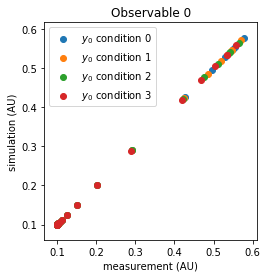

[0.4000123  0.40002545 0.40005266 0.40010894 0.40022538 0.40046616
 0.4009638  0.40199105 0.4041061  0.40843806 0.41721488 0.43460507
 0.46753068 0.52445703 0.60713044 0.69376801 0.73500837 0.70439349
 0.62886747 0.5355812 ] [0.4000123  0.40002545 0.40005266 0.40010894 0.40022538 0.40046616
 0.40096381 0.40199105 0.40410611 0.40843808 0.41721491 0.43460513
 0.46753079 0.52445723 0.60713074 0.69376834 0.73500865 0.70439376
 0.62886772 0.53558139]
[0.4000123  0.40002545 0.40005266 0.40010894 0.40022538 0.40046615
 0.40096376 0.40199086 0.40410531 0.40843473 0.41720084 0.43454691
 0.46729775 0.5235843  0.60424229 0.6861011  0.72067371 0.68526733
 0.60642    0.51180379] [0.4000123  0.40002545 0.40005265 0.40010894 0.40022537 0.40046615
 0.40096376 0.40199086 0.40410532 0.40843475 0.41720087 0.43454697
 0.46729786 0.52358451 0.60424258 0.68610141 0.72067398 0.6852676
 0.60642025 0.51180397]
[0.4000123  0.40002545 0.40005266 0.40010894 0.40022537 0.40046614
 0.40096372 0.40199068 0.40410453 

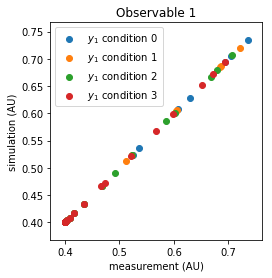

[0.6999792  0.69995696 0.69991095 0.69981577 0.69961885 0.6992116
 0.69836975 0.69663131 0.69304904 0.68569981 0.67075971 0.64095895
 0.58381563 0.4828983  0.33274096 0.17502923 0.08824506 0.06727818
 0.05651057 0.04468553] [0.6999792  0.69995696 0.69991096 0.69981577 0.69961885 0.6992116
 0.69836975 0.69663131 0.69304903 0.68569979 0.67075968 0.64095891
 0.58381555 0.48289817 0.33274078 0.17502906 0.08824498 0.06727813
 0.05651053 0.0446855 ]
[0.6999785  0.69995552 0.69990796 0.69980957 0.69960603 0.69918508
 0.69831495 0.6965182  0.69281623 0.68522334 0.66979577 0.63905514
 0.58023656 0.47681239 0.32424342 0.16659765 0.08234215 0.06252316
 0.05190231 0.04051998] [0.6999785  0.69995552 0.69990796 0.69980957 0.69960603 0.69918508
 0.69831495 0.6965182  0.69281622 0.68522332 0.66979575 0.63905509
 0.58023648 0.47681226 0.32424324 0.1665975  0.08234208 0.06252311
 0.05190228 0.04051995]
[0.6999778  0.69995407 0.69990496 0.69980337 0.6995932  0.69915856
 0.69826015 0.69640511 0.69258351 0

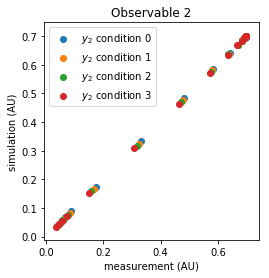

[0.2000356  0.20007366 0.20015241 0.20031533 0.2006524  0.20134958
 0.20279109 0.20576929 0.21191232 0.22454052 0.25031579 0.30212786
 0.4028219  0.58380281 0.8525968  1.1002188  1.15692673 1.11064669
 1.0570921  0.98989824] [0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134958
 0.20279109 0.20576929 0.21191232 0.22454052 0.25031579 0.30212787
 0.40282192 0.58380282 0.85259679 1.10021879 1.15692673 1.11064667
 1.0570921  0.98989824]
[0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134956
 0.20279101 0.20576892 0.21191075 0.22453385 0.25028764 0.3020111
 0.40235471 0.58207915 0.84730771 1.08908853 1.14285653 1.09576545
 1.03970746 0.97057368] [0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134956
 0.202791   0.20576892 0.21191075 0.22453385 0.25028765 0.30201111
 0.40235472 0.5820791  0.84730772 1.08908859 1.14285655 1.09576543
 1.03970746 0.97057369]
[0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134954
 0.20279092 0.20576855 0.21190918 

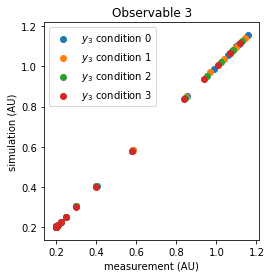

[3.4000123  3.40002545 3.40005266 3.40010894 3.40022538 3.40046616
 3.4009638  3.40199105 3.4041061  3.40843806 3.41721488 3.43460507
 3.46753068 3.52445703 3.60713044 3.69376801 3.73500837 3.70439349
 3.62886747 3.5355812 ] [3.4000122  3.40002535 3.40005255 3.40010884 3.40022527 3.40046606
 3.4009637  3.40199095 3.40410601 3.40843798 3.41721481 3.43460503
 3.46753069 3.52445712 3.60713064 3.69376824 3.73500855 3.70439366
 3.62886762 3.53558128]
[4.4000123  4.40002545 4.40005266 4.40010894 4.40022538 4.40046615
 4.40096376 4.40199086 4.40410531 4.40843473 4.41720084 4.43454691
 4.46729775 4.5235843  4.60424229 4.6861011  4.72067371 4.68526733
 4.60642    4.51180379] [4.4000122  4.40002535 4.40005255 4.40010884 4.40022527 4.40046605
 4.40096366 4.40199076 4.40410522 4.40843465 4.41720077 4.43454687
 4.46729776 4.52358441 4.60424248 4.68610131 4.72067388 4.6852675
 4.60642015 4.51180387]
[3.4000123  3.40002545 3.40005266 3.40010894 3.40022537 3.40046614
 3.40096372 3.40199068 3.40410453 

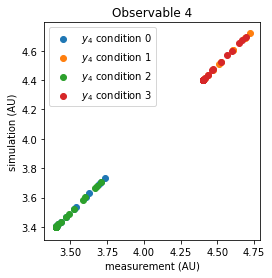

[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.12515789 0.15106393
 0.20141095 0.2919014  0.4262984  0.5501094  0.57846337 0.55532334
 0.52854605 0.49494912] [0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.1251579  0.15106394
 0.20141096 0.29190141 0.4262984  0.55010939 0.57846337 0.55532333
 0.52854605 0.49494912]
[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067478
 0.1013955  0.10288446 0.10595538 0.11226692 0.12514382 0.15100555
 0.20117735 0.29103957 0.42365386 0.54454426 0.57142826 0.54788272
 0.51985373 0.48528684] [0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067478
 0.1013955  0.10288446 0.10595537 0.11226692 0.12514382 0.15100555
 0.20117736 0.29103955 0.42365386 0.5445443  0.57142828 0.54788272
 0.51985373 0.48528684]
[0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067477
 0.10139546 0.10288428 0.10595459

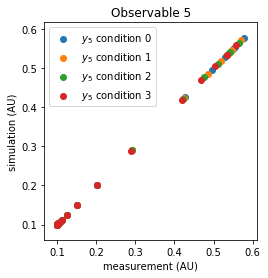

In [31]:
plotCorrelation(ymes, ysim)

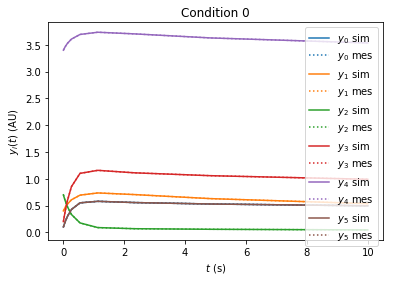

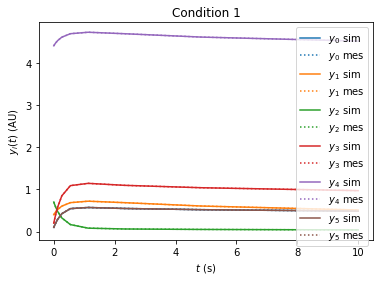

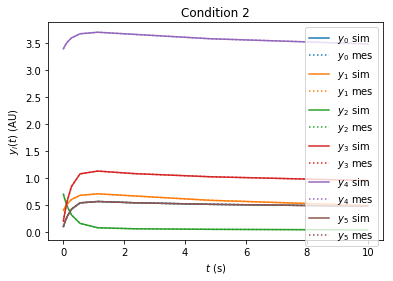

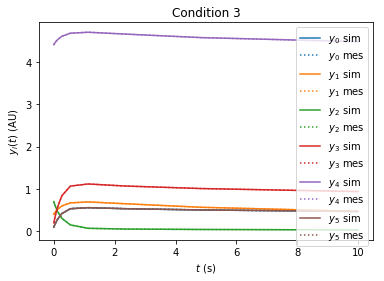

In [32]:
plotTrajectoryFit(ymes, ysim, timepoints)

## Ceres

In [33]:
!../../../misc/optimizationOptions.py example_data.h5 -s optimizer 1
!mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deletemeceres/ example_data.h5


[2018-08-08 14:46:54] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2018-08-08 14:46:54] [DBG] [1/dweindl] Seeding RNG with 1533732414
[2018-08-08 14:46:54] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2018-08-08 14:46:54] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2018-08-08 14:46:54] [DBG] [3/dweindl] Seeding RNG with 1533732414
[2018-08-08 14:46:54] [DBG] [2/dweindl] Seeding RNG with 1533732414
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-08-08 14:46:54] [DBG] [1/dweindl] Writing results to deletemeceres/_rank00001.h5.
[2018-08-08 14:46:54] [INF] [0/dweindl] Running with 4 MPI processes.
[2018-08-08 14:46:54] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2018-08-08 14:46:54] [DBG] [0/dweindl] Seeding RNG with 1533732414
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-08-08 14:46:54] [DBG] [2/dweindl] Writing results to deletemeceres/_rank00002.h5.
Hi

[2] Message received after waiting 0.001436s.
[2018-08-08 14:46:54] [DBG] [3/dweindl] Result for 0.0.0.0 (22): -9623.07 (0) (0.0038s)
[2018-08-08 14:46:54] [DBG] [2/dweindl] Result for 0.0.0.0 (23): -9623.07 (0) (0.0047s)
[1] Message received after waiting 0.001546s.
callbacks.cc:105    0: f:-1.904802e+03 d: 0.00e+00 g: 5.65e+08 h: 0.00e+00 s: 0.00e+00 e:  0 it: 2.30e-01 tt: 2.30e-01
[2018-08-08 14:46:54] [INF] [0/dweindl] iter: 0 cost: -1904.8 time_iter: 0.230422s time_optim: 0.230423s
[2018-08-08 14:46:54] [DBG] [2/dweindl] Result for 0.0.0.1 (23): -16708.8 (0) (0.0028s)
[2018-08-08 14:46:54] [DBG] [3/dweindl] Result for 0.0.0.1 (22): -16708.8 (0) (0.0104s)
[2018-08-08 14:46:54] [DBG] [2/dweindl] Result for 0.0.0.2 (23): -9570.43 (0) (0.0020s)
[2018-08-08 14:46:54] [DBG] [3/dweindl] Result for 0.0.0.2 (22): -9570.43 (0) (0.0017s)
[2018-08-08 14:46:54] [DBG] [2/dweindl] Result for 0.0.0.3 (23): -16650.1 (0) (0.0022s)
[2] Message received after waiting 0.000006s.
[2018-08-08 14:46:54] 

[2] Message received after waiting 0.005265s.
[2018-08-08 14:46:55] [DBG] [2/dweindl] Result for 0.0.0.0 (67): -9058.64 (0) (0.0015s)
[2018-08-08 14:46:55] [DBG] [2/dweindl] Result for 0.0.0.1 (67): -16068.4 (0) (0.0022s)
[2018-08-08 14:46:55] [DBG] [2/dweindl] Result for 0.0.0.2 (67): -9050.92 (0) (0.0016s)
[2018-08-08 14:46:55] [DBG] [1/dweindl] Result for 0.0.0.3 (66): 163.41 (0) (0.0209s)
[2018-08-08 14:46:55] [DBG] [2/dweindl] Result for 0.0.0.3 (67): -16060.5 (0) (0.0017s)
[2] Message received after waiting 0.000124s.
[2018-08-08 14:46:55] [DBG] [3/dweindl] Result for 0.0.0.2 (65): 163.08 (0) (0.0236s)
[3] Message received after waiting 0.001289s.
[1] Message received after waiting 0.000906s.
[2018-08-08 14:46:55] [DBG] [2/dweindl] Result for 0.0.0.0 (68): 162.348 (0) (0.0187s)
[2] Message received after waiting 0.000274s.
[2018-08-08 14:46:55] [DBG] [3/dweindl] Result for 0.0.0.1 (69): 162.727 (0) (0.0182s)
[2018-08-08 14:46:55] [DBG] [1/dweindl] Result for 0.0.0.2 (70): 163.08 

[2018-08-08 14:46:55] [DBG] [2/dweindl] Result for 0.0.0.0 (104): 209.383 (0) (0.0199s)
[2] Message received after waiting 0.000304s.
[2018-08-08 14:46:55] [DBG] [1/dweindl] Result for 0.0.0.2 (106): 209.884 (0) (0.0236s)
[1] Message received after waiting 0.000276s.
[2018-08-08 14:46:55] [DBG] [3/dweindl] Result for 0.0.0.1 (105): 209.642 (0) (0.0297s)
[2018-08-08 14:46:55] [DBG] [2/dweindl] Result for 0.0.0.3 (107): 210.11 (0) (0.0196s)
[3] Message received after waiting 0.005210s.
[2] Message received after waiting 0.000195s.
[2018-08-08 14:46:55] [DBG] [1/dweindl] Result for 0.0.0.0 (108): 209.383 (0) (0.0201s)
[2018-08-08 14:46:55] [DBG] [3/dweindl] Result for 0.0.0.1 (109): 209.642 (0) (0.0183s)
[2018-08-08 14:46:55] [DBG] [2/dweindl] Result for 0.0.0.2 (110): 209.884 (0) (0.0209s)
[3] Message received after waiting 0.001910s.
[1] Message received after waiting 0.002715s.
[2018-08-08 14:46:55] [DBG] [1/dweindl] Result for 0.0.0.0 (112): -8984.66 (0) (0.0021s)
[2] Message received

[2018-08-08 14:46:56] [DBG] [1/dweindl] Result for 0.0.0.2 (153): -8972.16 (0) (0.0035s)
[2018-08-08 14:46:56] [DBG] [1/dweindl] Result for 0.0.0.3 (153): -15970.3 (0) (0.0017s)
[3] Message received after waiting 0.001152s.
[1] Message received after waiting 0.002643s.
[2] Message received after waiting 0.005168s.
[2018-08-08 14:46:56] [DBG] [2/dweindl] Result for 0.0.0.1 (155): 253.448 (0) (0.0180s)
[2018-08-08 14:46:56] [DBG] [1/dweindl] Result for 0.0.0.2 (156): 253.688 (0) (0.0192s)
[2018-08-08 14:46:56] [DBG] [3/dweindl] Result for 0.0.0.0 (154): 253.192 (0) (0.0282s)
[2] Message received after waiting 0.005760s.
[1] Message received after waiting 0.004623s.
[3] Message received after waiting 0.001408s.
[2018-08-08 14:46:56] [DBG] [2/dweindl] Result for 0.0.0.3 (157): 253.912 (0) (0.0178s)
[2018-08-08 14:46:56] [DBG] [1/dweindl] Result for 0.0.0.0 (158): 253.192 (0) (0.0221s)
[2] Message received after waiting 0.005745s.
[1] Message received after waiting 0.001473s.
[2018-08-08 14

[2] Message received after waiting 0.000187s.
[2018-08-08 14:46:56] [DBG] [1/dweindl] Result for 0.0.0.2 (201): 297.671 (0) (0.0223s)
[3] Message received after waiting 0.009562s.
[1] Message received after waiting 0.000286s.
[2018-08-08 14:46:56] [DBG] [2/dweindl] Result for 0.0.0.0 (203): 319.264 (0) (0.0180s)
[2] Message received after waiting 0.000294s.
[2018-08-08 14:46:56] [DBG] [1/dweindl] Result for 0.0.0.1 (204): 319.524 (0) (0.0188s)
[2018-08-08 14:46:56] [DBG] [3/dweindl] Result for 0.0.0.3 (202): 297.895 (0) (0.0247s)
[1] Message received after waiting 0.000662s.
[2018-08-08 14:46:56] [DBG] [2/dweindl] Result for 0.0.0.2 (205): 319.762 (0) (0.0179s)
[3] Message received after waiting 0.000470s.
[2] Message received after waiting 0.002571s.
[2018-08-08 14:46:56] [DBG] [1/dweindl] Result for 0.0.0.3 (206): 319.985 (0) (0.0247s)
[2018-08-08 14:46:56] [DBG] [2/dweindl] Result for 0.0.0.1 (208): 319.524 (0) (0.0172s)
[1] Message received after waiting 0.000802s.
[2] Message rece

[2018-08-08 14:46:57] [DBG] [1/dweindl] Result for 0.0.0.1 (247): -15973.9 (0) (0.0015s)
[2018-08-08 14:46:57] [DBG] [1/dweindl] Result for 0.0.0.2 (247): -8971.86 (0) (0.0015s)
[2018-08-08 14:46:57] [DBG] [1/dweindl] Result for 0.0.0.3 (247): -15970 (0) (0.0015s)
[2] Message received after waiting 0.004255s.
[1] Message received after waiting 0.000106s.
[2018-08-08 14:46:57] [DBG] [2/dweindl] Result for 0.0.0.0 (248): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:57] [DBG] [2/dweindl] Result for 0.0.0.1 (248): -15973.9 (0) (0.0013s)
[2018-08-08 14:46:57] [DBG] [2/dweindl] Result for 0.0.0.2 (248): -8971.86 (0) (0.0013s)
[2018-08-08 14:46:57] [DBG] [2/dweindl] Result for 0.0.0.3 (248): -15970 (0) (0.0014s)
[2] Message received after waiting 0.000005s.
[2018-08-08 14:46:57] [DBG] [1/dweindl] Result for 0.0.0.0 (249): 364.325 (0) (0.0175s)
[1] Message received after waiting 0.000274s.
[2018-08-08 14:46:57] [DBG] [3/dweindl] Result for 0.0.0.3 (245): 342.271 (0) (0.0349s)
[3] Message received 

[2018-08-08 14:46:57] [DBG] [1/dweindl] Result for 0.0.0.3 (290): 415.945 (0) (0.0332s)
[2018-08-08 14:46:57] [DBG] [3/dweindl] Result for 0.0.0.0 (294): 415.124 (0) (0.0164s)
[2018-08-08 14:46:57] [DBG] [2/dweindl] Result for 0.0.0.1 (295): 415.776 (0) (0.0163s)
[1] Message received after waiting 0.001617s.
[3] Message received after waiting 0.000249s.
[2] Message received after waiting 0.000186s.
[2018-08-08 14:46:57] [DBG] [3/dweindl] Result for 0.0.0.3 (297): 415.945 (0) (0.0175s)
[2018-08-08 14:46:57] [DBG] [1/dweindl] Result for 0.0.0.2 (296): 415.88 (0) (0.0179s)
[2018-08-08 14:46:57] [DBG] [2/dweindl] Result for 0.0.0.0 (298): 448.006 (0) (0.0156s)
[3] Message received after waiting 0.000314s.
[2] Message received after waiting 0.000417s.
[1] Message received after waiting 0.001774s.
[2018-08-08 14:46:57] [DBG] [2/dweindl] Result for 0.0.0.2 (300): 449.276 (0) (0.0157s)
[2018-08-08 14:46:57] [DBG] [3/dweindl] Result for 0.0.0.1 (299): 449.408 (0) (0.0171s)
[2018-08-08 14:46:57]

[2018-08-08 14:46:57] [DBG] [3/dweindl] Result for 0.0.0.3 (336): 483.567 (0) (0.0179s)
[1] Message received after waiting 0.007468s.
[3] Message received after waiting 0.000474s.
callbacks.cc:105    1: f:-1.909033e+03 d: 4.23e+00 g: 4.58e+08 h: 2.01e-08 s: 2.15e-17 e: 16 it: 3.01e+00 tt: 3.20e+00
[2018-08-08 14:46:57] [INF] [0/dweindl] iter: 1 cost: -1909.03 time_iter: 3.01611s time_optim: 3.19544s
[2018-08-08 14:46:57] [DBG] [2/dweindl] Result for 0.0.0.0 (337): 483.999 (0) (0.0199s)
[2] Message received after waiting 0.000298s.
[2018-08-08 14:46:57] [DBG] [1/dweindl] Result for 0.0.0.1 (338): 468.169 (0) (0.0212s)
[2018-08-08 14:46:57] [DBG] [3/dweindl] Result for 0.0.0.2 (339): 473.741 (0) (0.0193s)
[1] Message received after waiting 0.000333s.
[3] Message received after waiting 0.000193s.
[2018-08-08 14:46:57] [DBG] [1/dweindl] Result for 0.0.0.0 (341): -8976.06 (0) (0.0015s)
[2018-08-08 14:46:57] [DBG] [3/dweindl] Result for 0.0.0.0 (342): -8976.06 (0) (0.0015s)
[2018-08-08 14:46

[1] Message received after waiting 0.003530s.
[3] Message received after waiting 0.000213s.
[2018-08-08 14:46:58] [DBG] [1/dweindl] Result for 0.0.0.0 (372): -8976.06 (0) (0.0016s)
[2018-08-08 14:46:58] [DBG] [1/dweindl] Result for 0.0.0.1 (372): -15973.9 (0) (0.0018s)
[2018-08-08 14:46:58] [DBG] [1/dweindl] Result for 0.0.0.2 (372): -8971.85 (0) (0.0018s)
[2018-08-08 14:46:58] [DBG] [1/dweindl] Result for 0.0.0.3 (372): -15970 (0) (0.0044s)
[1] Message received after waiting 0.001289s.
[2018-08-08 14:46:58] [DBG] [3/dweindl] Result for 0.0.0.0 (373): 483.216 (0) (0.0181s)
[3] Message received after waiting 0.000304s.
[2018-08-08 14:46:58] [DBG] [2/dweindl] Result for 0.0.0.3 (371): 484.174 (0) (0.0353s)
[2018-08-08 14:46:58] [DBG] [1/dweindl] Result for 0.0.0.1 (374): 469.413 (0) (0.0218s)
callbacks.cc:105    3: f:-1.911216e+03 d: 5.27e-01 g: 4.05e+08 h: 5.94e-08 s: 9.72e-16 e:  1 it: 1.88e-01 tt: 3.50e+00
[2018-08-08 14:46:58] [INF] [0/dweindl] iter: 3 cost: -1911.22 time_iter: 0.188

[2018-08-08 14:46:58] [DBG] [2/dweindl] Result for 0.0.0.3 (411): 485.885 (0) (0.0179s)
[3] Message received after waiting 0.000297s.
callbacks.cc:105    4: f:-1.920882e+03 d: 9.67e+00 g: 5.67e+08 h: 6.54e-07 s: 3.71e-14 e:  2 it: 2.88e-01 tt: 3.79e+00
[2018-08-08 14:46:58] [INF] [0/dweindl] iter: 4 cost: -1920.88 time_iter: 0.288842s time_optim: 3.79289s
[2] Message received after waiting 0.002186s.
[2018-08-08 14:46:58] [DBG] [1/dweindl] Result for 0.0.0.0 (412): 485.68 (0) (0.0229s)
[1] Message received after waiting 0.000297s.
[2018-08-08 14:46:58] [DBG] [3/dweindl] Result for 0.0.0.1 (413): 471.863 (0) (0.0202s)
[2018-08-08 14:46:58] [DBG] [2/dweindl] Result for 0.0.0.2 (414): 477.454 (0) (0.0179s)
[3] Message received after waiting 0.000285s.
[2] Message received after waiting 0.000193s.
[2018-08-08 14:46:58] [DBG] [3/dweindl] Result for 0.0.0.0 (416): -8976.06 (0) (0.0017s)
[2018-08-08 14:46:58] [DBG] [2/dweindl] Result for 0.0.0.0 (417): -8976.06 (0) (0.0014s)
[2018-08-08 14:46

[1] Message received after waiting 0.000332s.
[2] Message received after waiting 0.002905s.
[3] Message received after waiting 0.001695s.
[2018-08-08 14:46:58] [DBG] [2/dweindl] Result for 0.0.0.0 (453): 485.721 (0) (0.0179s)
[2018-08-08 14:46:58] [DBG] [1/dweindl] Result for 0.0.0.3 (452): 485.607 (0) (0.0223s)
[2018-08-08 14:46:58] [DBG] [3/dweindl] Result for 0.0.0.1 (454): 472.414 (0) (0.0202s)
[2] Message received after waiting 0.000287s.
[1] Message received after waiting 0.000261s.
callbacks.cc:105    5: f:-1.921677e+03 d: 7.96e-01 g: 5.85e+08 h: 5.63e-07 s: 1.96e-13 e:  2 it: 3.29e-01 tt: 4.12e+00
[2018-08-08 14:46:58] [INF] [0/dweindl] iter: 5 cost: -1921.68 time_iter: 0.32958s time_optim: 4.12247s
[3] Message received after waiting 0.000199s.
[2018-08-08 14:46:58] [DBG] [1/dweindl] Result for 0.0.0.3 (456): 485.607 (0) (0.0186s)
[2018-08-08 14:46:58] [DBG] [2/dweindl] Result for 0.0.0.2 (455): 477.935 (0) (0.0173s)
[2018-08-08 14:46:58] [DBG] [3/dweindl] Result for 0.0.0.0 (4

[2018-08-08 14:46:59] [DBG] [2/dweindl] Result for 0.0.0.0 (493): 489.892 (0) (0.0166s)
[2018-08-08 14:46:59] [DBG] [1/dweindl] Result for 0.0.0.2 (491): 485.645 (0) (0.0217s)
[2018-08-08 14:46:59] [DBG] [3/dweindl] Result for 0.0.0.3 (492): 485.728 (0) (0.0205s)
[2] Message received after waiting 0.000294s.
[1] Message received after waiting 0.000228s.
[3] Message received after waiting 0.000166s.
[2018-08-08 14:46:59] [DBG] [2/dweindl] Result for 0.0.0.1 (494): 475.29 (0) (0.0175s)
[2018-08-08 14:46:59] [DBG] [3/dweindl] Result for 0.0.0.3 (496): 486.929 (0) (0.0180s)
[2018-08-08 14:46:59] [DBG] [1/dweindl] Result for 0.0.0.2 (495): 482.697 (0) (0.0205s)
[2] Message received after waiting 0.000289s.
[3] Message received after waiting 0.000281s.
[2018-08-08 14:46:59] [INF] [0/dweindl] iter: 6 cost: -1934.81 time_iter: 0.297964s time_optim: 4.44709s
callbacks.cc:105    6: f:-1.934809e+03 d: 1.31e+01 g: 5.44e+08 h: 8.24e-07 s: 1.50e-01 e:  2 it: 2.97e-01 tt: 4.45e+00
[1] Message receive

[2] Message received after waiting 0.000273s.
[2018-08-08 14:46:59] [DBG] [1/dweindl] Result for 0.0.0.0 (533): 491.777 (0) (0.0170s)
[3] Message received after waiting 0.000720s.
callbacks.cc:105    8: f:-1.940531e+03 d: 2.09e-01 g: 2.16e+07 h: 1.40e-07 s: 1.00e+00 e:  1 it: 1.55e-01 tt: 4.72e+00
[2018-08-08 14:46:59] [INF] [0/dweindl] iter: 8 cost: -1940.53 time_iter: 0.155745s time_optim: 4.72355s
[1] Message received after waiting 0.000251s.
[2018-08-08 14:46:59] [DBG] [2/dweindl] Result for 0.0.0.1 (534): 475.111 (0) (0.0163s)
[2018-08-08 14:46:59] [DBG] [3/dweindl] Result for 0.0.0.2 (535): 485.529 (0) (0.0179s)
[2] Message received after waiting 0.000248s.
[2018-08-08 14:46:59] [DBG] [2/dweindl] Result for 0.0.0.0 (537): -8976.06 (0) (0.0013s)
[2018-08-08 14:46:59] [DBG] [2/dweindl] Result for 0.0.0.1 (537): -15973.9 (0) (0.0014s)
[2018-08-08 14:46:59] [DBG] [2/dweindl] Result for 0.0.0.2 (537): -8971.85 (0) (0.0012s)
[3] Message received after waiting 0.000232s.
[2018-08-08 14:

[2018-08-08 14:46:59] [DBG] [2/dweindl] Result for 0.0.0.1 (569): 473.962 (0) (0.0166s)
[2018-08-08 14:46:59] [DBG] [1/dweindl] Result for 0.0.0.0 (568): 492.402 (0) (0.0238s)
[2018-08-08 14:46:59] [DBG] [3/dweindl] Result for 0.0.0.2 (570): 485.08 (0) (0.0199s)
[2] Message received after waiting 0.000273s.
[1] Message received after waiting 0.000208s.
[2018-08-08 14:46:59] [DBG] [1/dweindl] Result for 0.0.0.0 (572): -8976.06 (0) (0.0014s)
[3] Message received after waiting 0.000330s.
[2018-08-08 14:46:59] [DBG] [1/dweindl] Result for 0.0.0.1 (572): -15973.9 (0) (0.0019s)
[2018-08-08 14:46:59] [DBG] [1/dweindl] Result for 0.0.0.2 (572): -8971.85 (0) (0.0014s)
[2018-08-08 14:46:59] [DBG] [1/dweindl] Result for 0.0.0.3 (572): -15970 (0) (0.0015s)
[1] Message received after waiting 0.000067s.
[2018-08-08 14:46:59] [DBG] [2/dweindl] Result for 0.0.0.3 (571): 489.095 (0) (0.0174s)
[2] Message received after waiting 0.000256s.
[2018-08-08 14:46:59] [DBG] [3/dweindl] Result for 0.0.0.0 (573):

[1] Message received after waiting 0.003081s.
[2018-08-08 14:46:59] [DBG] [2/dweindl] Result for 0.0.0.3 (611): 489.095 (0) (0.0165s)
[2018-08-08 14:46:59] [DBG] [3/dweindl] Result for 0.0.0.0 (612): 492.395 (0) (0.0186s)
[2] Message received after waiting 0.000260s.
line_search_minimizer.cc:413 Terminating: Parameter tolerance reached. Relative step_norm: 0.000000e+00 <= 1.000000e-08.
[2018-08-08 14:46:59] [INF] [0/dweindl] 0.2.0.0: Optimizer status 0, final llh: -1.940539e+03, time: 5.300531.
[3] Message received after waiting 0.000275s.
[2018-08-08 14:46:59] [DBG] [1/dweindl] Result for 0.0.0.1 (613): 473.963 (0) (0.0196s)
[1] Message received after waiting 0.000397s.
[2018-08-08 14:46:59] [DBG] [2/dweindl] Result for 0.0.0.2 (614): 485.085 (0) (0.0166s)
[2018-08-08 14:46:59] [DBG] [1/dweindl] Result for 0.0.0.0 (616): -8976.06 (0) (0.0014s)
[2018-08-08 14:46:59] [DBG] [1/dweindl] Result for 0.0.0.1 (616): -15973.9 (0) (0.0014s)
[2018-08-08 14:47:00] [DBG] [1/dweindl] Result for 0.0

In [34]:
compareResults('deletemeceres/_rank00000.h5', -expectedLlh)

#  __Exp___ __Act___ __Err____
0: 1.000000 0.999997 -0.000003
1: 0.500000 0.500000 -0.000000
2: 0.400000 0.399999 -0.000001
3: 2.000000 2.000002 0.000002
4: 0.100000 0.100000 -0.000000
5: 2.000000 2.000000 -0.000000
6: 3.000000 3.000000 -0.000000
7: 0.200000 0.000000 -0.200000
8: 4.000000 4.000000 -0.000000
Status: 0
Cost: -1940.539363 (expected: -608.698574)


# TODO

## preeequilibration
## different optimizers
## improve timing

In [35]:
list(model.getParameterNames())

['p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'scaling_x1',
 'offset_x2',
 'observable_x1withsigma_sigma']